# Imports

In [1]:
import time
import json
import os
import pickle


import pandas as pd
import numpy as np
import sklearn 

from sklearn.preprocessing import StandardScaler

import torch
print(torch.__version__)  # Should print a compatible version
print(torch.cuda.is_available())

import tsai
from tsai.basics import*


import matplotlib.pyplot as plt
%matplotlib inline

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, MAPE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.tuner import Tuner

import optuna
import joblib
# import plotly
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2.2.2+cu121
True


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Utils

In [2]:
class MSE(MultiHorizonMetric):
    """
    Mean Squared Error

    Defined as ``(y_pred - target)**2``
    """



    def loss(self, y_pred, target):
        loss = (self.to_prediction(y_pred) - target)**2
        return loss




In [3]:
def get_test_window_optuna(window_idx, test_windows, train, train_dataset, history_horizon_size, HPs): 

    window = test_windows[window_idx].copy()
    window['time_idx'] = list(range(0,history_horizon_size))
    window[["time_idx"]]+=train[["time_idx"]].max()+1
    train_plus_window = pd.concat([train, window], ignore_index=True).fillna(0.0)

    
    test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,
                                        train_plus_window, 
                                        predict=True, 
                                        stop_randomization=True)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'], num_workers=8)

    return test_dataloader


In [4]:
 def get_test_window(window_idx, test_windows, train, train_dataset, history_horizon_size): 

    window = test_windows[window_idx].copy()
    window['time_idx'] = list(range(0,history_horizon_size))
    window[["time_idx"]]+=train[["time_idx"]].max()+1
    train_plus_window = pd.concat([train, window], ignore_index=True).fillna(0.0)

    
    test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        train_plus_window, 
                                        predict=True, 
                                        stop_randomization=True)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=8)

    return test_dataloader


In [5]:
def get_total_loss(model, test_windows, train, train_dataset, history_horizon_size):

    window_losses_mape = []
    window_losses_smape = []
    window_losses_mae = []
    window_losses_rmse = []

    
    for window_idx, _ in tqdm(enumerate(test_windows), total=len(test_windows), desc = 'Window'):
        window_loader = get_test_window(window_idx, test_windows, train, train_dataset, history_horizon_size) #gets the window loader for a given idx
        window_preds = model.predict(window_loader, return_y=True) #inference for that window 
        
        window_loss_mape = MAPE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_mape = window_loss_mape.item() #item to get the float from tensor 
        window_losses_mape.append(window_loss_mape) #appending to master list 

        window_loss_smape = SMAPE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_smape = window_loss_smape.item() #item to get the float from tensor 
        window_losses_smape.append(window_loss_smape) #appending to master list 

        window_loss_mae = MAE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_mae = window_loss_mae.item() #item to get the float from tensor 
        window_losses_mae.append(window_loss_mae) #appending to master list 

        window_loss_rmse = RMSE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_rmse = window_loss_rmse.item() #item to get the float from tensor 
        window_losses_rmse.append(window_loss_rmse) #appending to master list 

    mean_loss_mape= np.mean(window_losses_mape)
    mean_loss_smape= np.mean(window_losses_smape)
    mean_loss_mae= np.mean(window_losses_mae)
    mean_loss_rmse= np.mean(window_losses_rmse)#return the mean lsos 

    print(f"Mean Losses Across Windows:")
    print(f"  - Mean MAPE: {mean_loss_mape:.4f}")
    print(f"  - Mean SMAPE: {mean_loss_smape:.4f}")
    print(f"  - Mean MAE: {mean_loss_mae:.4f}")
    print(f"  - Mean RMSE: {mean_loss_rmse:.4f}")

    
    return window_losses_mape, window_losses_smape, window_losses_mae, window_losses_rmse


        

    

    

In [6]:
def get_total_loss_optuna(model, test_windows, train, train_dataset, history_horizon_size, HPs):

    window_losses_mape = []
    window_losses_smape = []
    window_losses_mae = []
    window_losses_rmse = []

    
    for window_idx, _ in tqdm(enumerate(test_windows), total=len(test_windows), desc = 'Window'):
        window_loader = get_test_window_optuna(window_idx, test_windows, train, train_dataset, history_horizon_size, HPs) #gets the window loader for a given idx
        window_preds = model.predict(window_loader, return_y=True) #inference for that window 
        
        window_loss_mape = MAPE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_mape = window_loss_mape.item() #item to get the float from tensor 
        window_losses_mape.append(window_loss_mape) #appending to master list 

        window_loss_smape = SMAPE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_smape = window_loss_smape.item() #item to get the float from tensor 
        window_losses_smape.append(window_loss_smape) #appending to master list 

        window_loss_mae = MAE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_mae = window_loss_mae.item() #item to get the float from tensor 
        window_losses_mae.append(window_loss_mae) #appending to master list 

        window_loss_rmse = RMSE()(window_preds.output, window_preds.y) #loss for that window
        window_loss_rmse = window_loss_rmse.item() #item to get the float from tensor 
        window_losses_rmse.append(window_loss_rmse) #appending to master list 

    mean_loss_mape= np.mean(window_losses_mape)
    mean_loss_smape= np.mean(window_losses_smape)
    mean_loss_mae= np.mean(window_losses_mae)
    mean_loss_rmse= np.mean(window_losses_rmse)#return the mean lsos 

    print(f"Mean Losses Across Windows:")
    print(f"  - Mean MAPE: {mean_loss_mape:.4f}")
    print(f"  - Mean SMAPE: {mean_loss_smape:.4f}")
    print(f"  - Mean MAE: {mean_loss_mae:.4f}")
    print(f"  - Mean RMSE: {mean_loss_rmse:.4f}")

    
    return window_losses_mape, window_losses_smape, window_losses_mae, window_losses_rmse


        

    

    

In [7]:
def get_first_preds(model, test_windows, train, train_dataset, history_horizon_size):

    first_preds = []
    
    for window_idx, _ in tqdm(enumerate(test_windows), total=len(test_windows), desc = 'Window'):
        window_loader = get_test_window(window_idx, test_windows, train, train_dataset, history_horizon_size) #gets the window loader for a given idx
        window_preds = model.predict(window_loader, return_y=True) #inference for that window 
        window_first = window_preds.output[0][0].item()
        first_preds.append(window_first)
        if window_idx == len(test_windows) - 1: 
            first_preds.extend([item.item() for item in (window_preds.output[0][1:])])




    return first_preds 

        

    

    

In [8]:
def get_all_plots(start, end, step, model, test_windows, train, train_dataset, history_horizon_size):

    
    for window_idx in range(start, end, step):
            
            window_loader = get_test_window(window_idx, test_windows, train, train_dataset, history_horizon_size)
            window_predictions = model.predict(window_loader, mode="raw", return_x=True)
            tft.plot_prediction(window_predictions.x, window_predictions.output, idx=0, show_future_observed=True)
            plt.show()
            print(f'Plot for Window {window_idx}')
            
    interpretation = model.interpret_output(window_predictions.output, reduction="sum")
    model.plot_interpretation(interpretation)
        

    

    

In [9]:
def get_all_plots_archived(num, model, test_windows, train, train_dataset, history_horizon_size):

    
    for window_idx, _ in enumerate(test_windows):
            if window_idx == num: 
                break
            window_loader = get_test_window(window_idx, test_windows, train, train_dataset, history_horizon_size)
            window_predictions = model.predict(window_loader, mode="raw", return_x=True)
            tft.plot_prediction(window_predictions.x, window_predictions.output, idx=0, show_future_observed=True)
            
    interpretation = model.interpret_output(window_predictions.output, reduction="sum")
    model.plot_interpretation(interpretation)
        

    

    

In [10]:
def get_test_windows(test_dataset, history, horizon): 
    
    window_size = history+horizon
    windows = [test_dataset.iloc[i: i+window_size] for i in range(len(test_dataset) - window_size+1)]

    return windows

In [10]:
# exp.all() == tests.all()

# Data Loading

In [11]:

master_df = pd.read_csv("../Outputs/Data_Master.csv")

# EDA

In [14]:
master_df.columns

Index(['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'],
      dtype='object')

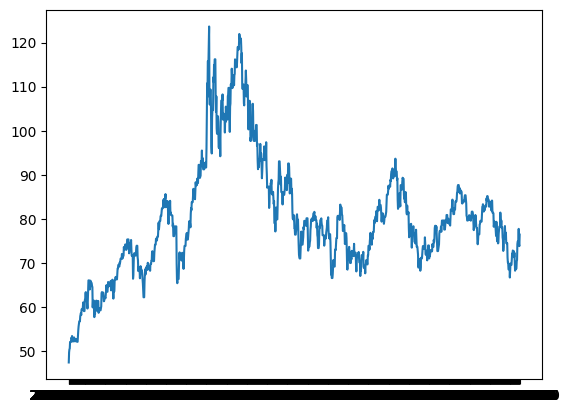

In [15]:
plt.plot(master_df['Date'], master_df['crude'])

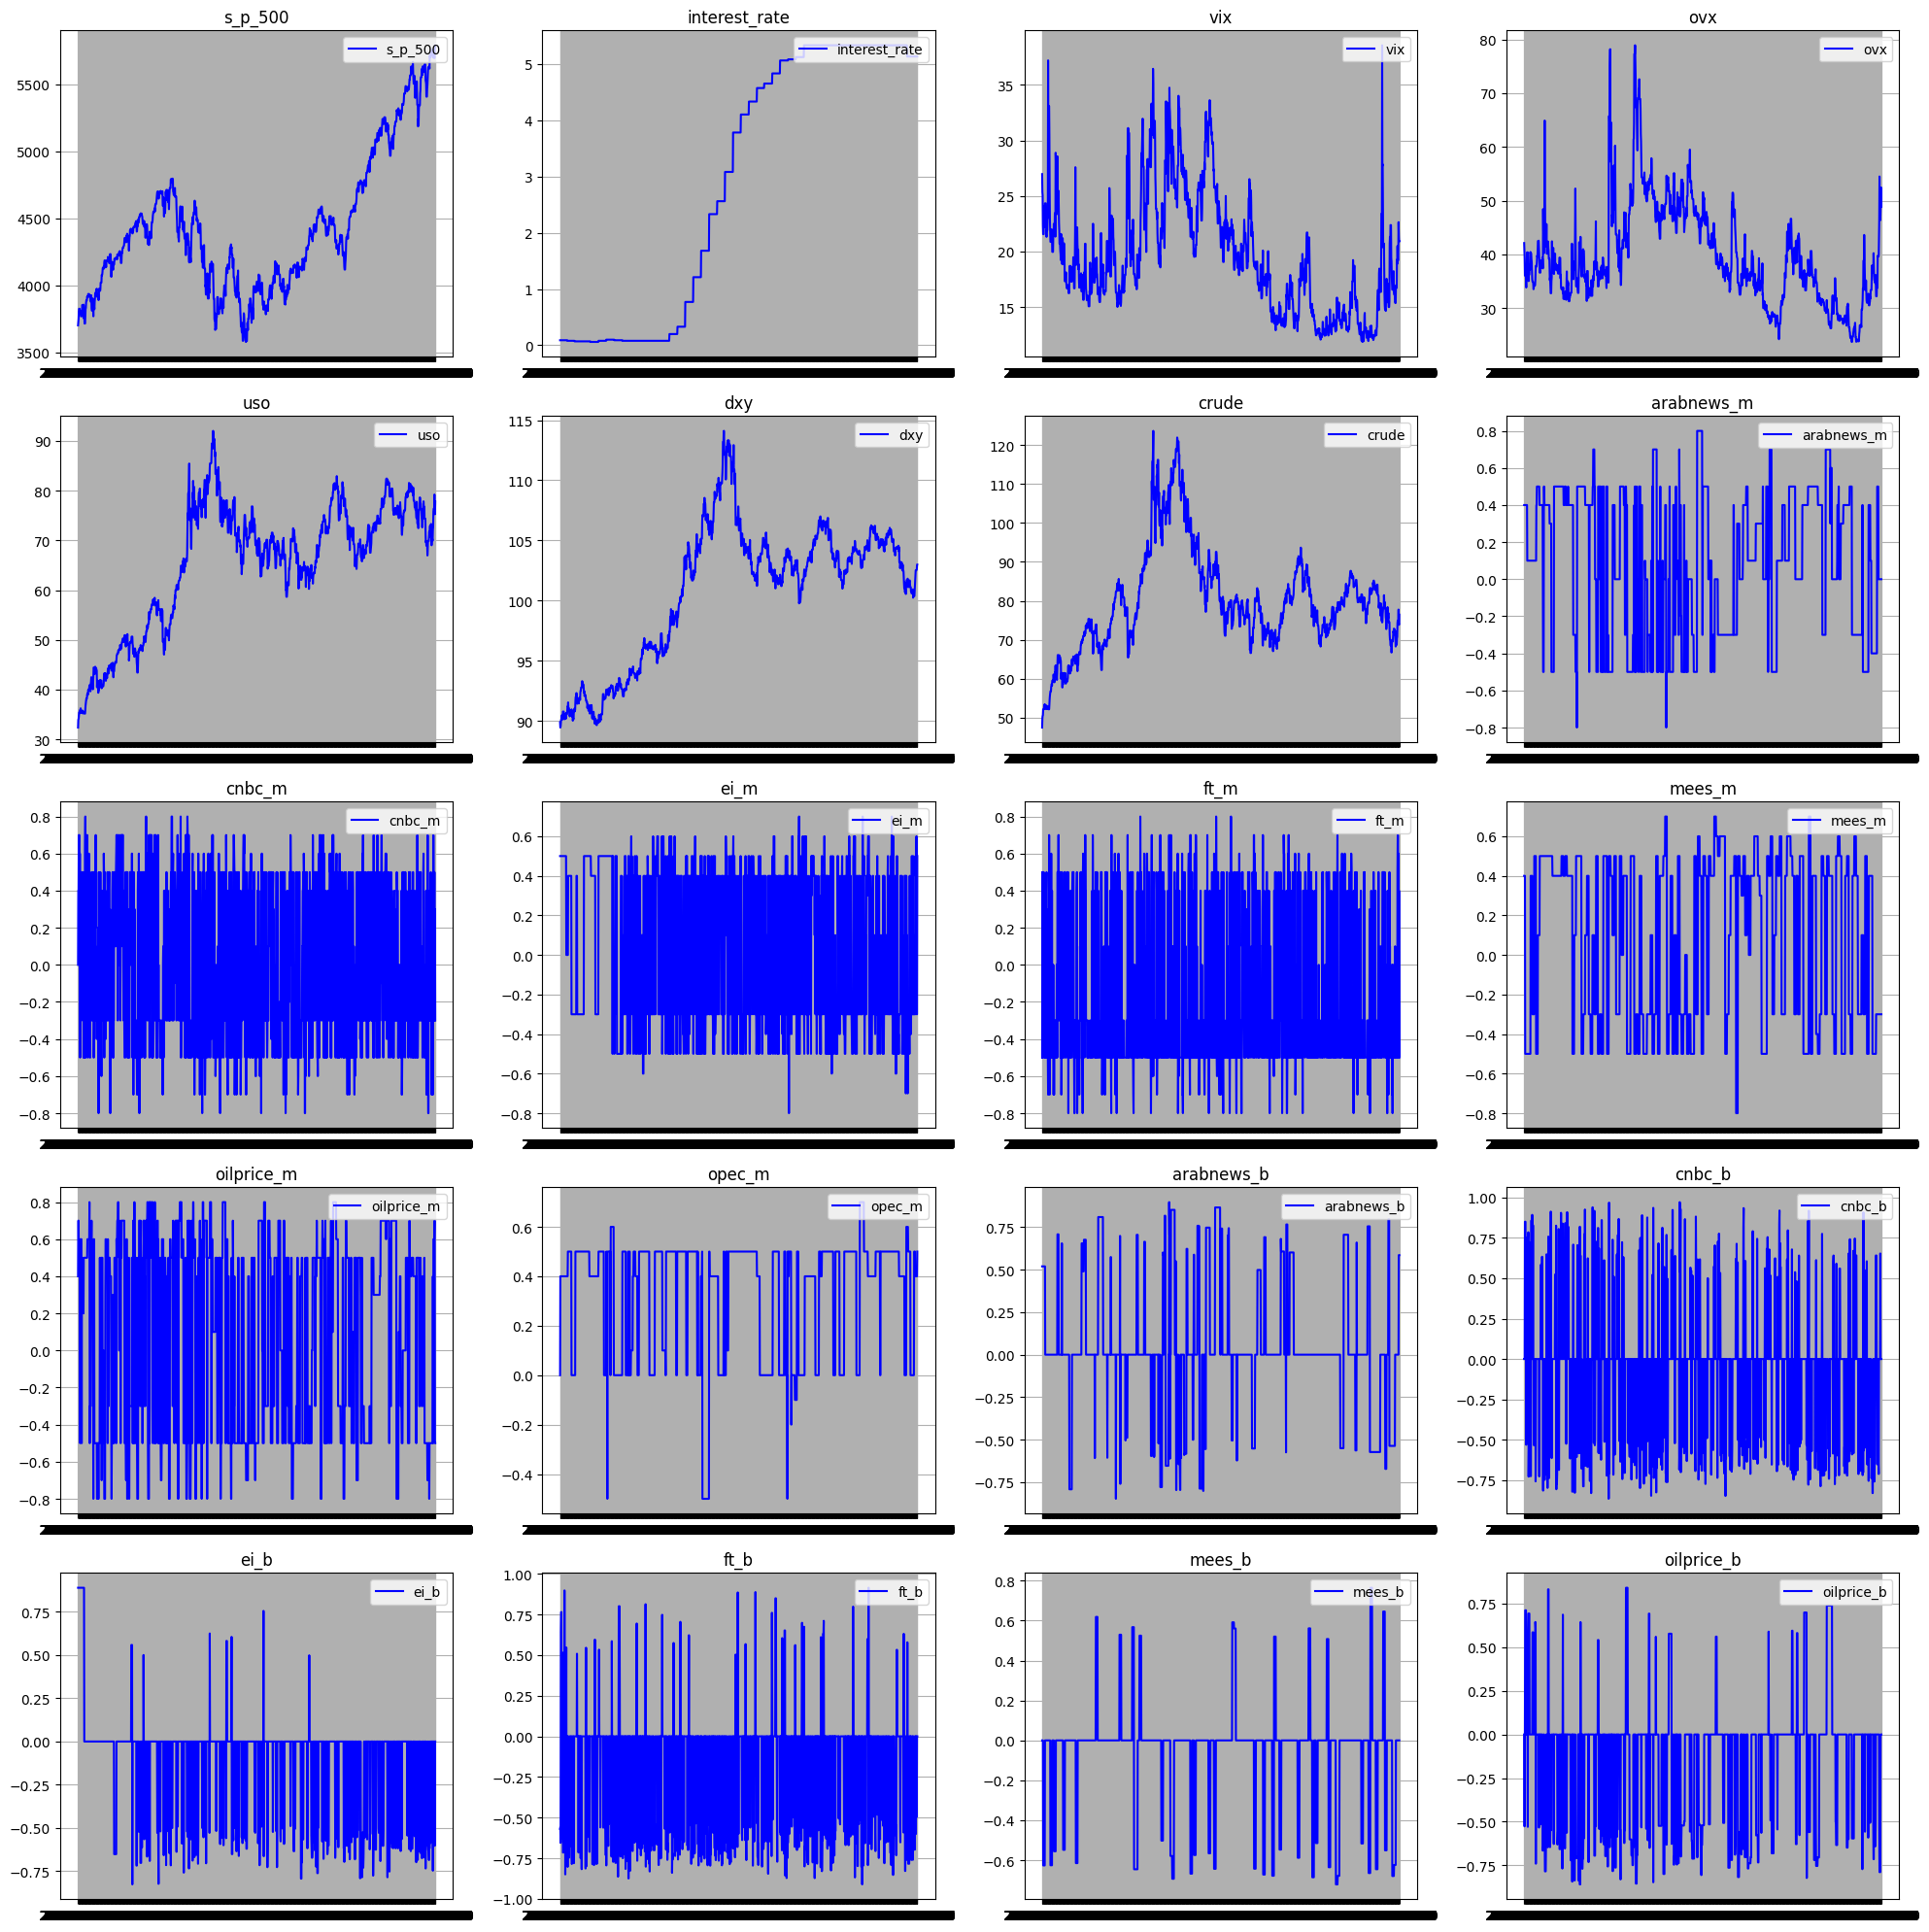

In [14]:
import matplotlib.pyplot as plt
import math

# List of variables to plot (excluding 'Date')
variables = [
    's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
    'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
    'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
    'oilprice_b'
]

# Number of variables and layout configuration
num_vars = len(variables)
plots_per_row = 4
num_rows = math.ceil(num_vars / plots_per_row)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(20, num_rows * 4))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(variables):
    axes[i].plot(master_df['Date'], master_df[var], label=var, color='blue')
    axes[i].set_title(var)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Data Prep for Modelling

In [12]:
CALENDAR_CYCLES= {
    "weekday": 7,
    "week": 52,
    "month": 12,
}

In [13]:
def add_cyclical_calendar_features(df: pd.DataFrame, date_col: str, features: Union[str, List[str]]):
    """Cyclical encoding of calendar features based on a date column."""
    
    if isinstance(features, str):
        features = [features]

    # Ensure the date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"

        if feat == "week":
            # Use ISO calendar week
            values = df[date_col].dt.isocalendar().week
        else:
            # For other features (weekday, month), use .dt accessor
            values = getattr(df[date_col].dt, feat)

        # Apply cyclical encoding
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df


In [14]:
master_df_processed = add_cyclical_calendar_features(master_df, 'Date', features=["weekday", "week", 'month'])
master_df_processed

Date  s_p_500  interest_rate    vix    ovx    uso     dxy  crude  \
0    2021-01-04  3700.65           0.09  26.97  42.12  32.38   89.87  47.47   
1    2021-01-05  3726.86           0.09  25.34  40.39  33.94   89.44  49.78   
2    2021-01-06  3748.14           0.09  25.07  39.31  34.11   89.53  50.45   
3    2021-01-07  3803.79           0.09  22.37  36.06  34.53   89.83  50.63   
4    2021-01-08  3824.68           0.09  21.56  36.65  35.43   90.10  52.14   
...         ...      ...            ...    ...    ...    ...     ...    ...   
1371 2024-10-06  5751.07           5.13  19.21  46.37  76.35  102.52  74.93   
1372 2024-10-07  5695.94           5.13  22.64  48.32  79.20  102.54  77.76   
1373 2024-10-08  5751.13           5.13  21.42  52.35  75.79  102.55  74.26   
1374 2024-10-09  5792.04           5.13  20.86  48.80  75.25  102.93  73.85   
1375 2024-10-10  5780.05           5.13  20.93  52.36  77.77  102.99  76.46   

      arabnews_m  cnbc_m  ...      ei_b      ft_b    mees_b  oilprice_b  \
0            0.4     0.0  ...  0.889924 -0.569241  0.000000    0.000000   
1            0.4     0.4  ...  0.889924 -0.560321  0.000000   -0.526396   
2            0.4     0.4  ...  0.889924 -0.654790  0.000000   -0.526396   
3            0.4     0.7  ...  0.889924  0.644426  0.000000    0.000000   
4            0.4     0.7  ...  0.889924  0.764327 -0.626426    0.711697   
...          ...     ...  ...       ...       ...       ...         ...   
1371         0.0     0.0  ...  0.000000  0.000000  0.000000   -0.788622   
1372         0.0     0.5  ...  0.000000  0.000000  0.000000    0.000000   
1373         0.0    -0.3  ... -0.603633 -0.496074  0.000000    0.000000   
1374         0.0     0.3  ...  0.000000  0.000000  0.000000    0.000000   
1375         0.0    -0.3  ...  0.000000  0.000000  0.000000    0.000000   

      weekday_sin  weekday_cos  week_sin  week_cos  month_sin  month_cos  
0        0.000000     1.000000  0.120537  0.992709   0.500000   0.866025  
1        0.781831     0.623490  0.120537  0.992709   0.500000   0.866025  
2        0.974928    -0.222521  0.120537  0.992709   0.500000   0.866025  
3        0.433884    -0.900969  0.120537  0.992709   0.500000   0.866025  
4       -0.433884    -0.900969  0.120537  0.992709   0.500000   0.866025  
...           ...          ...       ...       ...        ...        ...  
1371    -0.781831     0.623490 -0.992709  0.120537  -0.866025   0.500000  
1372     0.000000     1.000000 -0.970942  0.239316  -0.866025   0.500000  
1373     0.781831     0.623490 -0.970942  0.239316  -0.866025   0.500000  
1374     0.974928    -0.222521 -0.970942  0.239316  -0.866025   0.500000  
1375     0.433884    -0.900969 -0.970942  0.239316  -0.866025   0.500000  

[1376 rows x 27 columns]

In [15]:
master_df_processed.columns

Index(['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
       'month_sin', 'month_cos'],
      dtype='object')

In [16]:
# scaler = StandardScaler()
master_df_processed = master_df_processed[['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
       'month_sin', 'month_cos']]

In [19]:
# master_df_processed["weekend"] = (master_df_processed['Date'].dt.dayofweek > 4).astype(int)

## Train-Val-Test Splits

In [17]:
split = round(len(master_df_processed)*0.8)
print(split)

train = master_df_processed.iloc[: split]
test = master_df_processed.iloc[split:]

# test_dates = test[['Date']]
test.shape

1101


(275, 20)

In [18]:
val_split = round(len(test)*0.5)

val= test.iloc[: val_split]
test = test.iloc[val_split:]

test_dates = test[['Date']]
val_dates = val[['Date']]
test.shape

(137, 20)

In [19]:
train= train.reset_index()
train= (train.merge((train[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)

val= val.reset_index()
val= (val.merge((val[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)

test= test.reset_index()
test= (test.merge((test[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)

#test = test.iloc[150:214]
#test = test.iloc[:64]

In [20]:
print(train.shape)
print(val.shape)
print(test.shape)

(1101, 21)
(138, 21)
(137, 21)


In [21]:
constant_tr= [1 for item in train['vix']]
train['constant'] = constant_tr

constant_vl= [1 for item in val['vix']]
val['constant'] = constant_vl

constant_te= [1 for item in test['vix']]
test['constant'] = constant_te

In [66]:
con = pd.concat([val, test])

con.reset_index(inplace = True)
con = con.drop(columns = ['level_0'])

In [25]:
val_windows = [val.iloc[i:i+128] for i in range(len(val) - 128 + 1)]

In [27]:
len(val_windows)

11

In [41]:
tests = [test.iloc[i:i+64] for i in range(len(test) - 64 + 1)]

In [42]:
tests[0].shape

(64, 29)

In [43]:
tests = get_test_windows(test, 16, 48)

In [44]:
tests[0].shape

(64, 29)

In [33]:
tests[0].shape

(64, 29)

In [41]:
train

index  s_p_500  interest_rate    vix    ovx    uso     dxy  crude  \
0         0  3700.65           0.09  26.97  42.12  32.38   89.87  47.47   
1         1  3726.86           0.09  25.34  40.39  33.94   89.44  49.78   
2         2  3748.14           0.09  25.07  39.31  34.11   89.53  50.45   
3         3  3803.79           0.09  22.37  36.06  34.53   89.83  50.63   
4         4  3824.68           0.09  21.56  36.65  35.43   90.10  52.14   
...     ...      ...            ...    ...    ...    ...     ...    ...   
1096   1096  4697.24           5.33  13.35  36.07  69.03  102.41  74.00   
1097   1097  4697.24           5.33  13.35  36.07  69.03  102.41  74.00   
1098   1098  4697.24           5.33  13.35  36.07  69.03  102.41  74.00   
1099   1099  4763.54           5.33  13.08  36.79  66.40  102.21  71.06   
1100   1100  4756.50           5.33  12.76  36.09  67.39  102.57  72.43   

      arabnews_b    cnbc_b  ...    mees_b  oilprice_b  weekday_sin  \
0       0.519839  0.000000  ...  0.000000    0.000000     0.000000   
1       0.519839  0.000000  ...  0.000000   -0.526396     0.781831   
2       0.519839  0.000000  ...  0.000000   -0.526396     0.974928   
3       0.519839  0.848916  ...  0.000000    0.000000     0.433884   
4       0.519839  0.848916  ... -0.626426    0.711697    -0.433884   
...          ...       ...  ...       ...         ...          ...   
1096    0.000000  0.917254  ...  0.507777   -0.558835    -0.433884   
1097    0.000000 -0.730377  ...  0.507777   -0.558835    -0.974928   
1098    0.000000  0.000000  ...  0.507777   -0.558835    -0.781831   
1099    0.000000 -0.538682  ...  0.507777   -0.558835     0.000000   
1100    0.000000  0.000000  ...  0.507777   -0.558835     0.781831   

      weekday_cos  week_sin  week_cos  month_sin  month_cos  time_idx  \
0        1.000000  0.120537  0.992709        0.5   0.866025         0   
1        0.623490  0.120537  0.992709        0.5   0.866025         1   
2       -0.222521  0.120537  0.992709        0.5   0.866025         2   
3       -0.900969  0.120537  0.992709        0.5   0.866025         3   
4       -0.900969  0.120537  0.992709        0.5   0.866025         4   
...           ...       ...       ...        ...        ...       ...   
1096    -0.900969  0.120537  0.992709        0.5   0.866025      1096   
1097    -0.222521  0.120537  0.992709        0.5   0.866025      1097   
1098     0.623490  0.120537  0.992709        0.5   0.866025      1098   
1099     1.000000  0.239316  0.970942        0.5   0.866025      1099   
1100     0.623490  0.239316  0.970942        0.5   0.866025      1100   

      constant  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
1096         1  
1097         1  
1098         1  
1099         1  
1100         1  

[1101 rows x 22 columns]

# Model Building

In [27]:
max_encoder_length = 112#history
max_prediction_length = 48 #forecast
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="crude", # target variable
    max_encoder_length=max_encoder_length, # maximum size of lookup window
    max_prediction_length=max_prediction_length, # maximum size of horizon window
    group_ids = ['constant'], 
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'], 
    target_normalizer=EncoderNormalizer(),
    lags={'crude': [7,30, 365]}, # add lagged values of target variable
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [25]:
max_encoder_length = 50
max_prediction_length = 16
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="crude", # target variable
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    group_ids = ['constant'], 
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'], 
    target_normalizer=EncoderNormalizer(),
    lags={'crude': [7,365]}, # add lagged values of target variable
    predict_mode = True
)





In [28]:
validation_dataset = TimeSeriesDataSet.from_dataset(
  training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
  train, # data from which new dataset will be generated
  predict=True, # predict the decoder length on the last entries in the time index
  stop_randomization=True,
)

In [16]:
# test['time_idx'] = list(range(0,64))

In [643]:
# test["time_idx"]+=train["time_idx"].max()+1 - 64


150    1101
151    1102
152    1103
153    1104
154    1105
       ... 
209    1160
210    1161
211    1162
212    1163
213    1164
Name: time_idx, Length: 64, dtype: int64

In [20]:

# test["time_idx"]+=train["time_idx"].max()+1
# test = pd.concat([train, test], ignore_index=True).fillna(0.0)



# test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
#                                         test, 
#                                         predict=True, 
#                                         stop_randomization=True)
# test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [29]:
batch_size = 64  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)
#test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [39]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate = .01584893192461113, 
    hidden_size=12,
    attention_head_size=4,
    dropout=0.3,
    loss=MSE(),
    # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

#0.0031622776601683794
#0.000331131121482591, 

Number of parameters in network: 29.6k


## LR Finder

In [31]:
trainer = pl.Trainer(
    accelerator="gpu"
)

Finding best initial lr: 100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


suggested learning rate: 0.01584893192461113


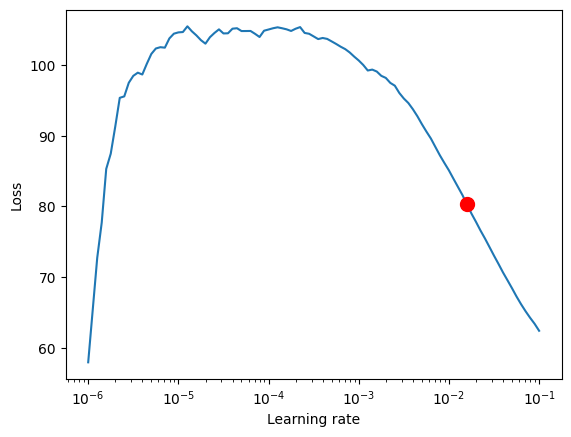

In [32]:
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Training

In [11]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val=0.1,
    
)

In [12]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

NameError: name 'tft' is not defined

# Validation

In [42]:
predictions = tft.predict(val_dataloader, return_y=True)
MAE()(predictions.output, predictions.y)

tensor(5.6405, device='cuda:0')

In [43]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

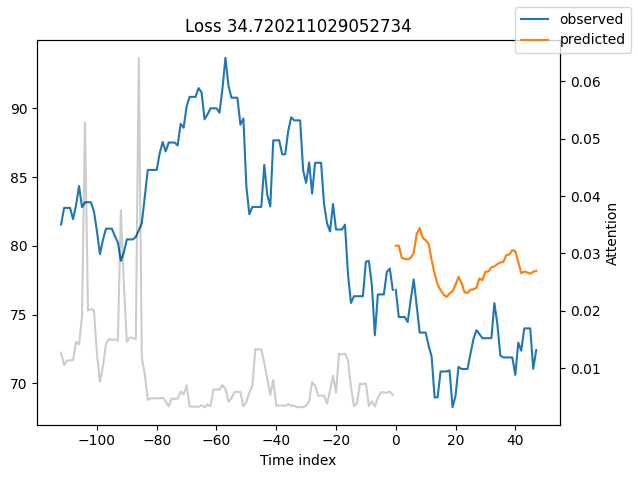

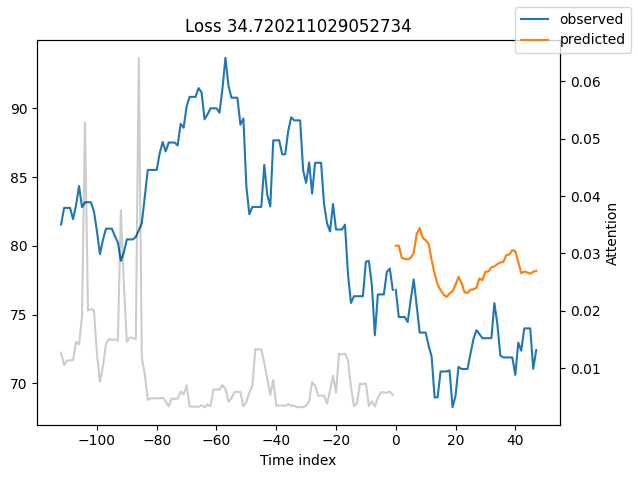

In [44]:

tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

In [186]:
test_dataloader = get_test_window(0, tests, train, training_dataset, 160)


IndexError: list index out of range

In [35]:
mape, smape, mae, rmse = get_total_loss(tft, tests, train, training_dataset, 64)

Window: 100%|██████████| 212/212 [02:32<00:00,  1.39it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.0435
  - Mean SMAPE: 0.0437
  - Mean MAE: 3.4275
  - Mean RMSE: 3.7857


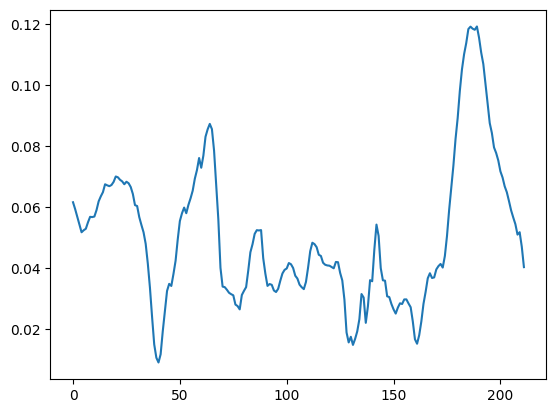

In [142]:
plt.plot(list(range(len(smape))), smape ) 

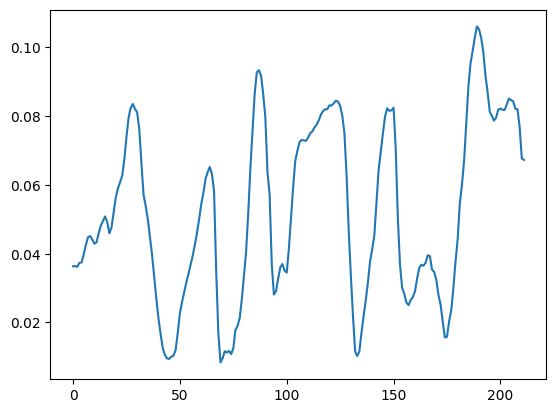

In [234]:
plt.plot(list(range(len(smape))), mape ) 

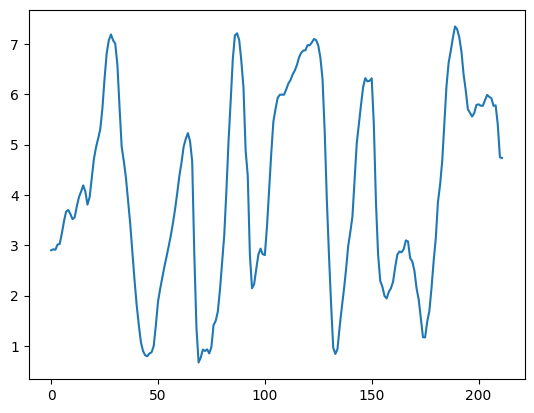

In [233]:
plt.plot(list(range(len(smape))), mae ) 

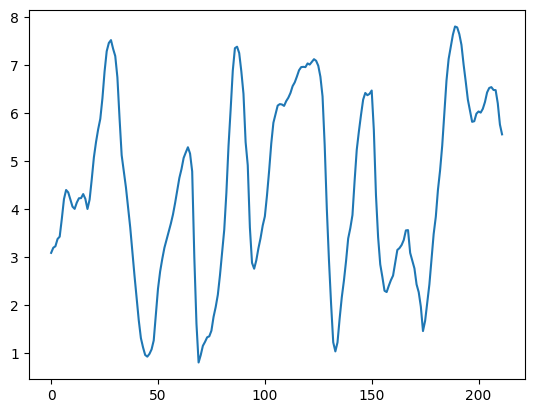

In [235]:
plt.plot(list(range(len(smape))), rmse ) 

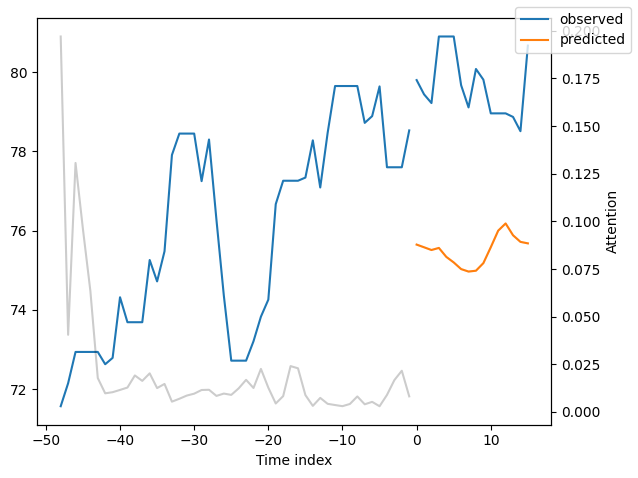

Plot for Window 0


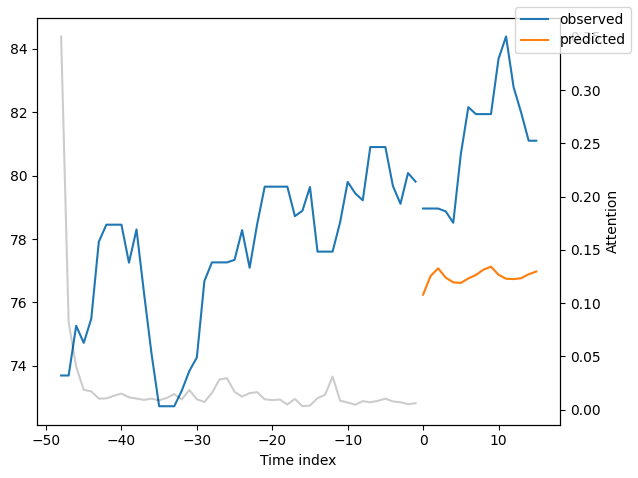

Plot for Window 10


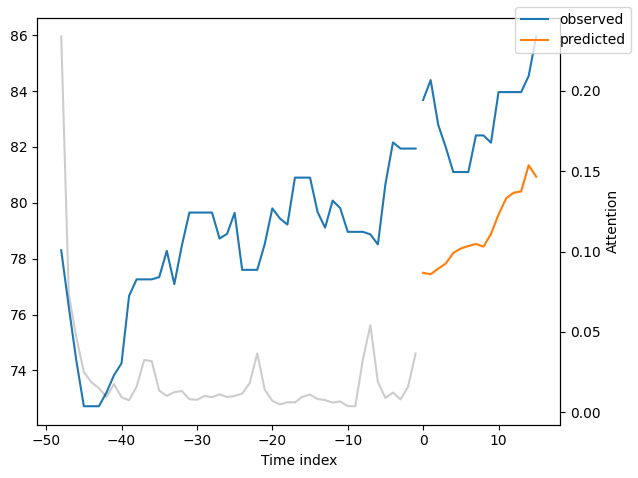

Plot for Window 20


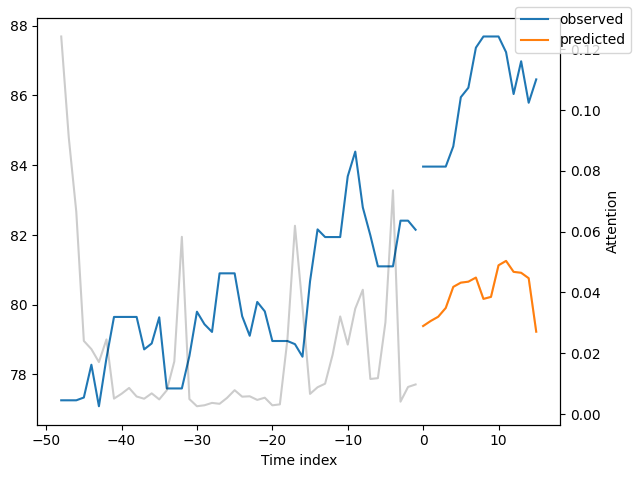

Plot for Window 30


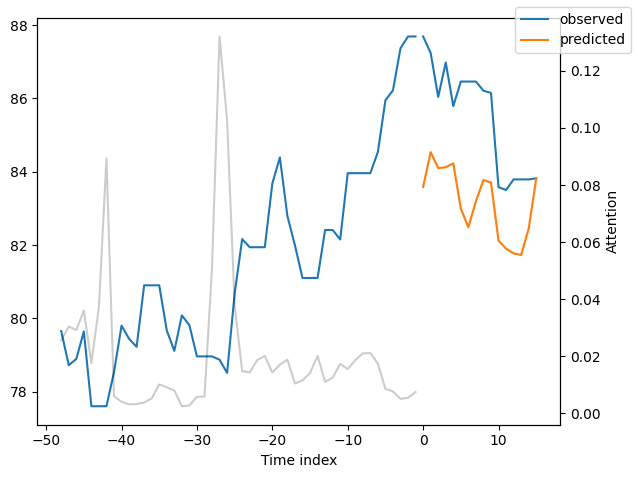

Plot for Window 40


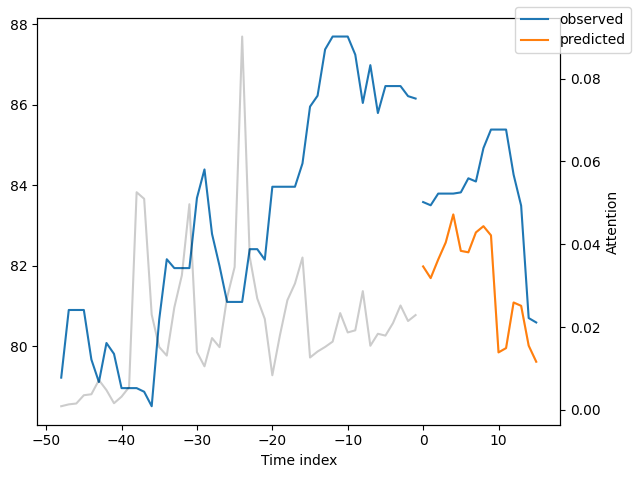

Plot for Window 50


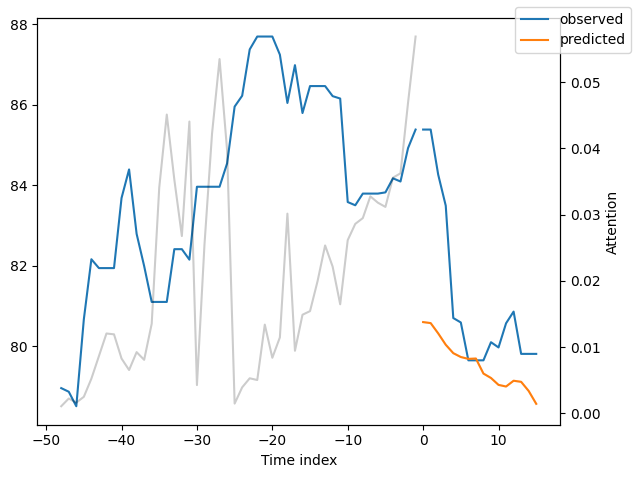

Plot for Window 60


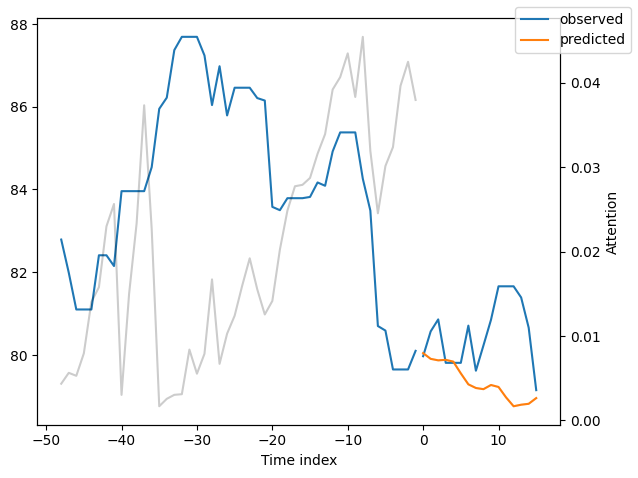

Plot for Window 70


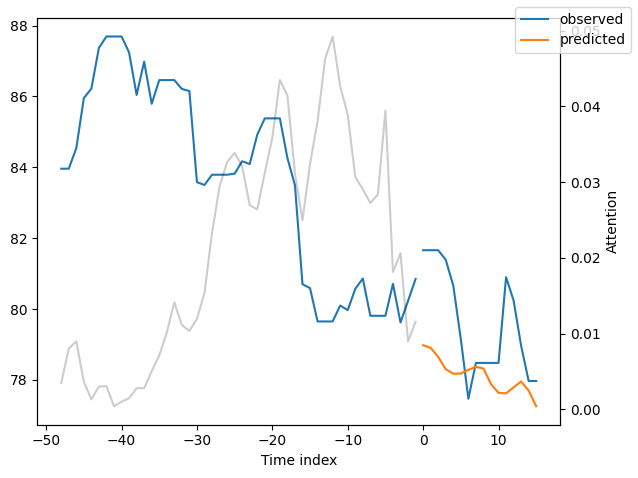

Plot for Window 80


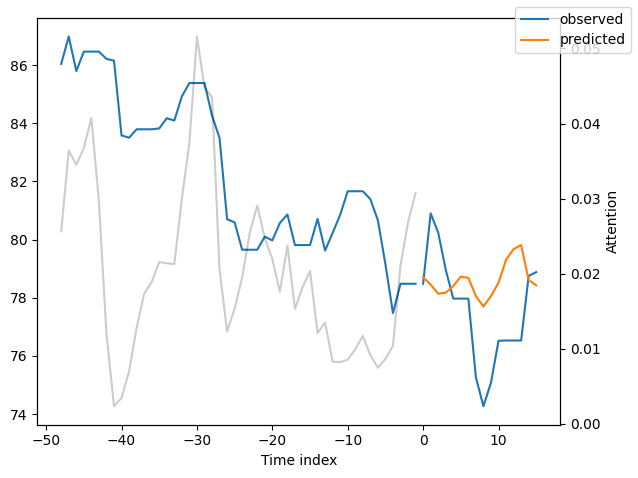

Plot for Window 90


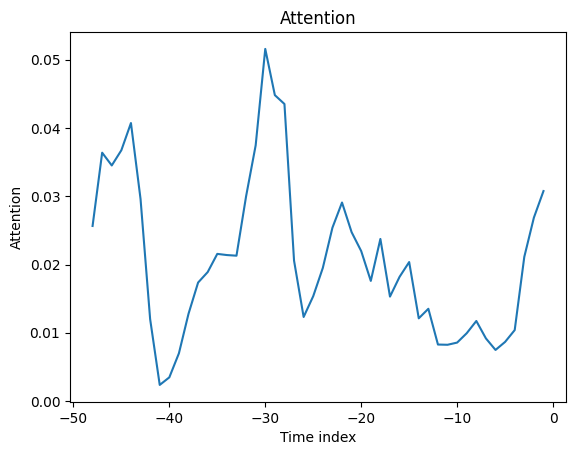

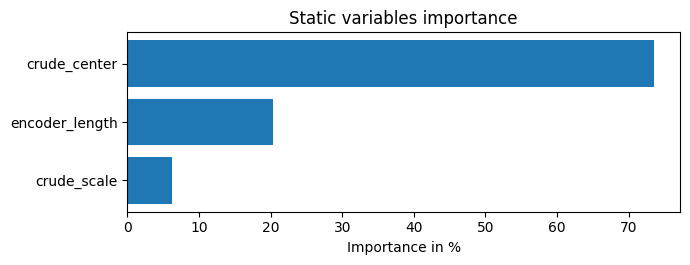

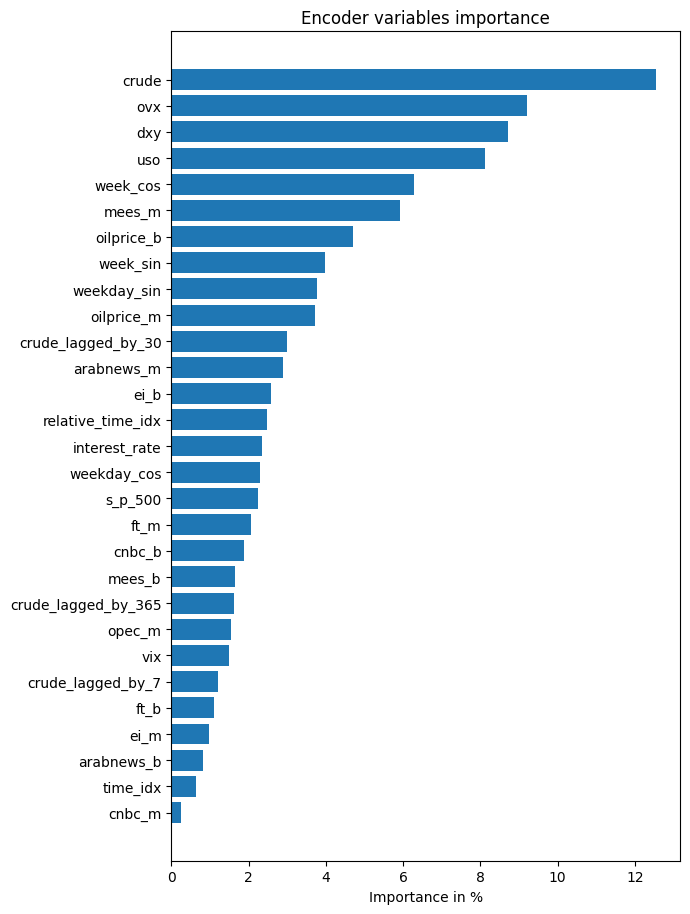

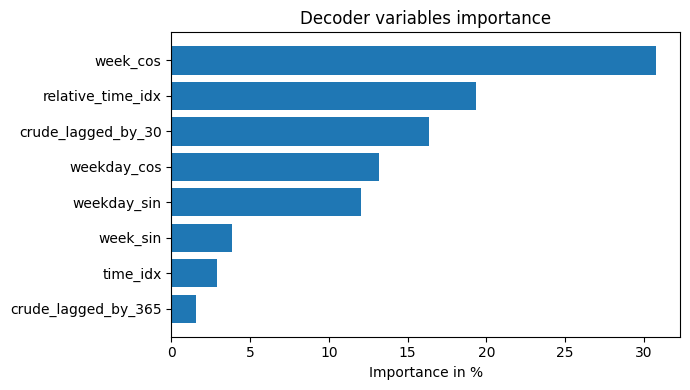

In [40]:
get_all_plots(0, 100,10,  tft, tests, train, training_dataset, 64)

In [41]:
first_preds =  get_first_preds(tft, tests, train, training_dataset, 64)

Window: 100%|██████████| 212/212 [02:45<00:00,  1.28it/s]


In [146]:
len(first_preds)

227

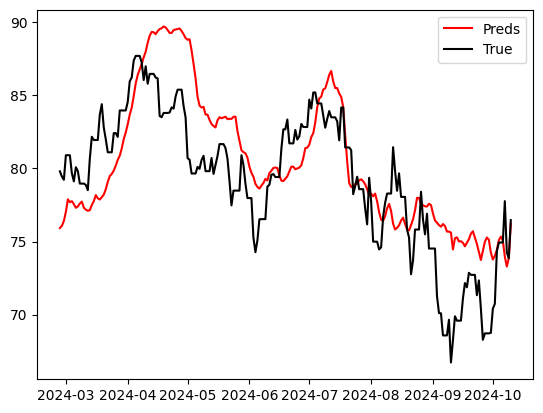

In [147]:
plt.plot(test_dates[['Date']][48:], first_preds, color = 'r', label = 'Preds')
plt.plot(test_dates[['Date']][48:], test[['crude']][48:], color = 'k', label = 'True')

plt.legend()
plt.show()
         

In [64]:
test

index  s_p_500  interest_rate    vix    ovx    uso     dxy  crude  \
0     1101  4783.45           5.33  12.69  36.35  66.56  102.36  71.57   
1     1102  4780.24           5.33  12.44  36.78  67.65  102.29  72.15   
2     1103  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
3     1104  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
4     1105  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
..     ...      ...            ...    ...    ...    ...     ...    ...   
270   1371  5751.07           5.13  19.21  46.37  76.35  102.52  74.93   
271   1372  5695.94           5.13  22.64  48.32  79.20  102.54  77.76   
272   1373  5751.13           5.13  21.42  52.35  75.79  102.55  74.26   
273   1374  5792.04           5.13  20.86  48.80  75.25  102.93  73.85   
274   1375  5780.05           5.13  20.93  52.36  77.77  102.99  76.46   

     arabnews_m  cnbc_m  ...    mees_b  oilprice_b  weekday_sin  weekday_cos  \
0           0.5     0.5  ...  0.507777    0.000000     0.974928    -0.222521   
1           0.5     0.5  ...  0.507777    0.000000     0.433884    -0.900969   
2           0.5    -0.3  ... -0.635409    0.000000    -0.433884    -0.900969   
3           0.5    -0.3  ... -0.635409    0.000000    -0.974928    -0.222521   
4           0.5    -0.3  ... -0.635409    0.000000    -0.781831     0.623490   
..          ...     ...  ...       ...         ...          ...          ...   
270         0.0     0.0  ...  0.000000   -0.788622    -0.781831     0.623490   
271         0.0     0.5  ...  0.000000    0.000000     0.000000     1.000000   
272         0.0    -0.3  ...  0.000000    0.000000     0.781831     0.623490   
273         0.0     0.3  ...  0.000000    0.000000     0.974928    -0.222521   
274         0.0    -0.3  ...  0.000000    0.000000     0.433884    -0.900969   

     week_sin  week_cos  month_sin  month_cos  time_idx  constant  
0    0.239316  0.970942   0.500000   0.866025         0         1  
1    0.239316  0.970942   0.500000   0.866025         1         1  
2    0.239316  0.970942   0.500000   0.866025         2         1  
3    0.239316  0.970942   0.500000   0.866025         3         1  
4    0.239316  0.970942   0.500000   0.866025         4         1  
..        ...       ...        ...        ...       ...       ...  
270 -0.992709  0.120537  -0.866025   0.500000       270         1  
271 -0.970942  0.239316  -0.866025   0.500000       271         1  
272 -0.970942  0.239316  -0.866025   0.500000       272         1  
273 -0.970942  0.239316  -0.866025   0.500000       273         1  
274 -0.970942  0.239316  -0.866025   0.500000       274         1  

[275 rows x 29 columns]

# Hyperparameter Tuning - Optuna with Weights & Biases

In [40]:
def objective(trial):

    HPs = {   'epochs': trial.suggest_int("epochs", 5, 20, step = 5), 
              'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
              'hidden_size': trial.suggest_int("hidden_size", 16, 128, step=16),
              'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
              'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
              'hidden_continous_size': trial.suggest_int("hidden_continous_size", 16, 128, step=16), 
              'dropout': trial.suggest_float("dropout", 0.1, 0.4, step=0.1), 
              'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE']),
              'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1), # using percentages
              'batch_size': trial.suggest_int("batch_size", 32, 128, step= 16)
              }

    # config = dict(trial.params)
    # config["trial.number"] = trial.number
    # wandb.init(
    #     project="optuna",
    #     entity="nzw0301",  # NOTE: this entity depends on your wandb account.
    #     config=config,
    #     group=STUDY_NAME,
    #     reinit=True,
    # )

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None

In [41]:
def train_model(HPs): 


    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    hidden_continuous_size=HPs['hidden_continous_size'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    print('Success')

    try: 
        window_losses_mape, window_losses_smape, window_losses_mae, window_losses_rmse = get_total_loss_optuna(tft, val_windows, train, training_dataset, 64, HPs) 
    except Exception as e: 
        print(e)

    loss = np.mean(window_losses_smape)
    return loss


    




    

In [77]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_tuning', 
                            storage='sqlite:///tft_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 
                                                 # file and continues the hyperparameer tuning
study.optimize(objective, n_trials=5)

# save the 'study' object into a pickle file for analysis
joblib.dump(study, "tft_tuning.pkl")

[I 2024-11-26 03:46:26,946] Using an existing study with name 'tft_tuning' instead of creating a new one.


Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  7.38it/s, v_num=5.4e+7, train_loss_step=0.0524]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s, v_num=5.4e+7, train_loss_step=0.0542, val_loss=0.0215, train_loss_epoch=0.062]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  5.00it/s, v_num=5.4e+7, train_loss_step=0.0493, val_loss=0.0195, train_loss_epoch=0.0552]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s, v_num=5.4e+7, train_loss_step=0.0438, val_loss=0.0166, train_loss_epoch=0.0529]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.71it/s, v_num=5.4e+7, train_loss_step=0.0386, val_loss=0.0305, train_loss_epoch=0.0481]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s, v_num=5.4e+7, train_loss_step=0.0403, val_loss=0.0269, train_loss_epoch=0.0422]
Val

Window: 100%|██████████| 75/75 [00:56<00:00,  1.33it/s]
[I 2024-11-26 03:47:50,326] Trial 20 finished with value: 0.05302069462835789 and parameters: {'epochs': 10, 'learning_rate': 0.0058171102033571604, 'hidden_size': 32, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 80, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 80}. Best is trial 18 with value: 0.026583481381336847.


Mean Losses Across Windows:
  - Mean MAPE: 0.0520
  - Mean SMAPE: 0.0530
  - Mean MAE: 4.3037
  - Mean RMSE: 4.5293
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.70it/s, v_num=5.4e+7, train_loss_step=0.0594]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, v_num=5.4e+7, train_loss_step=0.0493, val_loss=0.0331, train_loss_epoch=0.0651]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s, v_num=5.4e+7, train_loss_step=0.047, val_loss=0.0229, train_loss_epoch=0.0534] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.50it/s, v_num=5.4e+7, train_loss_step=0.0479, val_loss=0.0189, train_loss_epoch=0.0485]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s, v_num=5.4e+7, train_loss_step=0.0444, val_loss=0.0165, train_loss_epoch=0.0466]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 10

Window: 100%|██████████| 75/75 [00:59<00:00,  1.27it/s]
[I 2024-11-26 03:49:06,047] Trial 21 finished with value: 0.03910271008809407 and parameters: {'epochs': 5, 'learning_rate': 0.007837029121318232, 'hidden_size': 64, 'lstm_layers': 3, 'attention_head_size': 2, 'hidden_continous_size': 32, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 1.0, 'batch_size': 48}. Best is trial 18 with value: 0.026583481381336847.


Mean Losses Across Windows:
  - Mean MAPE: 0.0382
  - Mean SMAPE: 0.0391
  - Mean MAE: 3.1997
  - Mean RMSE: 3.4814
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.42it/s, v_num=5.4e+7, train_loss_step=0.0658]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, v_num=5.4e+7, train_loss_step=0.0494, val_loss=0.0154, train_loss_epoch=0.065]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.52it/s, v_num=5.4e+7, train_loss_step=0.0411, val_loss=0.0635, train_loss_epoch=0.0525]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s, v_num=5.4e+7, train_loss_step=0.0415, val_loss=0.022, train_loss_epoch=0.0447] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s, v_num=5.4e+7, train_loss_step=0.0384, val_loss=0.0236, train_loss_epoch=0.042] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100

Window: 100%|██████████| 75/75 [00:58<00:00,  1.28it/s]
[I 2024-11-26 03:50:34,756] Trial 22 finished with value: 0.03833592429757118 and parameters: {'epochs': 10, 'learning_rate': 0.0027552624468798557, 'hidden_size': 48, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 16, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 1.0, 'batch_size': 48}. Best is trial 18 with value: 0.026583481381336847.


Mean Losses Across Windows:
  - Mean MAPE: 0.0378
  - Mean SMAPE: 0.0383
  - Mean MAE: 3.1295
  - Mean RMSE: 3.5668
Epoch 0: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s, v_num=5.4e+7, train_loss_step=0.0592]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s, v_num=5.4e+7, train_loss_step=0.0552, val_loss=0.0219, train_loss_epoch=0.0656]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s, v_num=5.4e+7, train_loss_step=0.0446, val_loss=0.0238, train_loss_epoch=0.056] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s, v_num=5.4e+7, train_loss_step=0.0449, val_loss=0.0171, train_loss_epoch=0.0472]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, v_num=5.4e+7, train_loss_step=0.0415, val_loss=0.0246, train_loss_epoch=0.0419]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 10

Window: 100%|██████████| 75/75 [00:59<00:00,  1.27it/s]
[I 2024-11-26 03:52:47,023] Trial 23 finished with value: 0.049060956935087836 and parameters: {'epochs': 20, 'learning_rate': 0.002624215863368106, 'hidden_size': 32, 'lstm_layers': 3, 'attention_head_size': 2, 'hidden_continous_size': 48, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.9, 'batch_size': 32}. Best is trial 18 with value: 0.026583481381336847.


Mean Losses Across Windows:
  - Mean MAPE: 0.0508
  - Mean SMAPE: 0.0491
  - Mean MAE: 4.1735
  - Mean RMSE: 4.4723
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  7.82it/s, v_num=5.4e+7, train_loss_step=0.058] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.34it/s, v_num=5.4e+7, train_loss_step=0.0632, val_loss=0.0191, train_loss_epoch=0.0872]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s, v_num=5.4e+7, train_loss_step=0.0672, val_loss=0.0212, train_loss_epoch=0.0671]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.15it/s, v_num=5.4e+7, train_loss_step=0.0546, val_loss=0.0162, train_loss_epoch=0.0673]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s, v_num=5.4e+7, train_loss_step=0.0602, val_loss=0.0223, train_loss_epoch=0.0586]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 10

Window: 100%|██████████| 75/75 [00:59<00:00,  1.25it/s]
[I 2024-11-26 03:54:35,332] Trial 24 finished with value: 0.04040146774301926 and parameters: {'epochs': 15, 'learning_rate': 0.021533439772735117, 'hidden_size': 80, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 64, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.8, 'batch_size': 48}. Best is trial 18 with value: 0.026583481381336847.


Mean Losses Across Windows:
  - Mean MAPE: 0.0398
  - Mean SMAPE: 0.0404
  - Mean MAE: 3.3091
  - Mean RMSE: 3.6672


['tft_tuning.pkl']

# Building Best Model

In [43]:
# study = joblib.load("tft_tuning.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.031780966222286225
 Params: 
    epochs: 20
    learning_rate: 0.006508045556624078
    hidden_size: 80
    lstm_layers: 4
    attention_head_size: 2
    hidden_continous_size: 16
    dropout: 0.4
    loss: MAPE
    gradient_clip_val: 0.1
    batch_size: 32


In [48]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = 4, 
    learning_rate =  0.006508045556624078, 
    hidden_size=80,
    attention_head_size=2,
    dropout=0.4,
    hidden_continuous_size=16, 
    loss=MAPE(),
    # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

#0.0031622776601683794
#0.000331131121482591, 

Number of parameters in network: 804.7k


In [49]:

batch_size = 32  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [50]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val=0.1,
    
)


In [51]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s, v_num=5.4e+7, train_loss_step=0.0453]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s, v_num=5.4e+7, train_loss_step=0.0629, val_loss=0.0599, train_loss_epoch=0.0649]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s, v_num=5.4e+7, train_loss_step=0.0404, val_loss=0.0192, train_loss_epoch=0.0516]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s, v_num=5.4e+7, train_loss_step=0.0399, val_loss=0.0179, train_loss_epoch=0.0498]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s, v_num=5.4e+7, train_loss_step=0.0382, val_loss=0.0237, train_loss_epoch=0.0454]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s, v_num=5.4e+7, train_loss_step=0.0365, val_loss=0.0255, train_loss_epoc

In [78]:
# study = joblib.load("tft_tuning.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.026583481381336847
 Params: 
    epochs: 10
    learning_rate: 0.006872695266178679
    hidden_size: 32
    lstm_layers: 3
    attention_head_size: 3
    hidden_continous_size: 64
    dropout: 0.4
    loss: MAPE
    gradient_clip_val: 1.0
    batch_size: 48


In [79]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = 3, 
    learning_rate =  0.026583481381336847, 
    hidden_size=32,
    attention_head_size=3,
    dropout=0.4,
    hidden_continuous_size=64, 
    loss=MAPE(),
    # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

#0.0031622776601683794
#0.000331131121482591, 

Number of parameters in network: 369.8k


In [80]:

batch_size = 48  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [81]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val=1,
    
)


In [82]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.57it/s, v_num=5.4e+7, train_loss_step=0.0678]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, v_num=5.4e+7, train_loss_step=0.061, val_loss=0.016, train_loss_epoch=0.0673] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, v_num=5.4e+7, train_loss_step=0.0533, val_loss=0.0214, train_loss_epoch=0.0571]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s, v_num=5.4e+7, train_loss_step=0.0471, val_loss=0.0214, train_loss_epoch=0.0543]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.32it/s, v_num=5.4e+7, train_loss_step=0.0498, val_loss=0.028, train_loss_epoch=0.0527] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, v_num=5.4e+7, train_loss_step=0.0474, val_loss=0.0222, train_loss_epoch

In [83]:
mape, smape, mae, rmse = get_total_loss(tft, tests, train, training_dataset, 64)

Window: 100%|██████████| 74/74 [00:57<00:00,  1.29it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.0720
  - Mean SMAPE: 0.0690
  - Mean MAE: 5.2531
  - Mean RMSE: 5.9329


In [85]:
mape, smape, mae, rmse = get_total_loss(tft, val_windows, train, training_dataset, 64)

Window: 100%|██████████| 75/75 [00:59<00:00,  1.27it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.0254
  - Mean SMAPE: 0.0254
  - Mean MAE: 2.1106
  - Mean RMSE: 2.3600


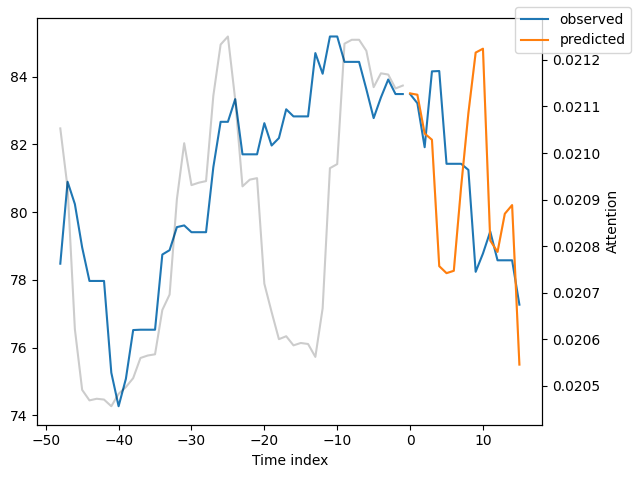

Plot for Window 0


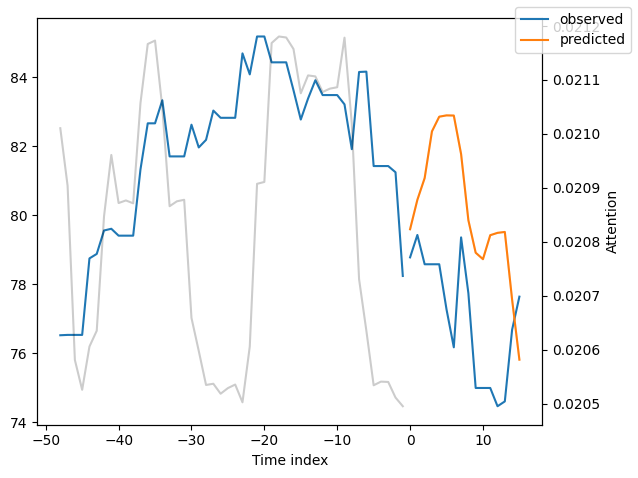

Plot for Window 10


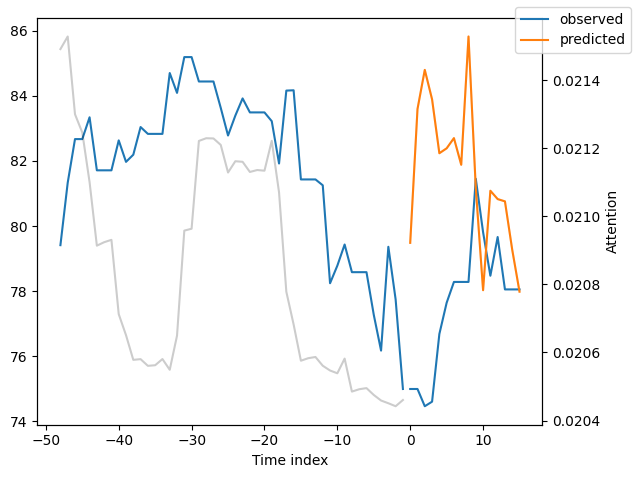

Plot for Window 20


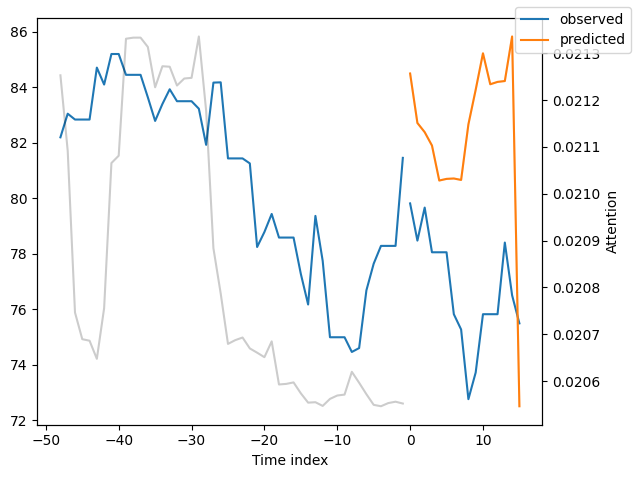

Plot for Window 30


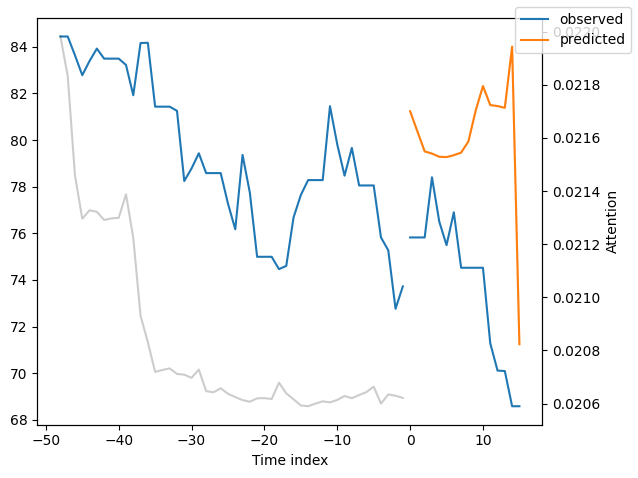

Plot for Window 40


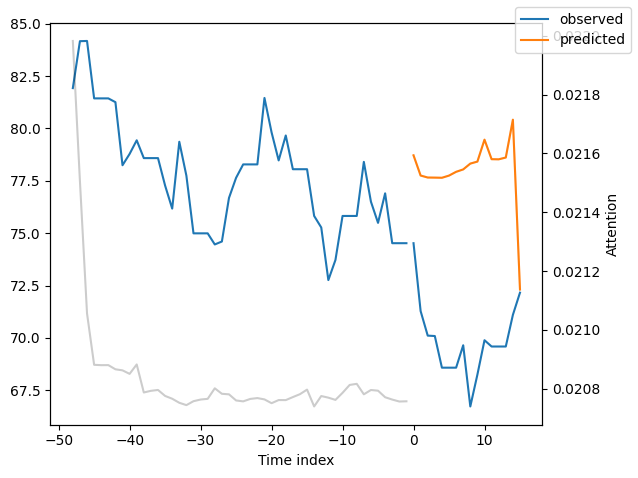

Plot for Window 50


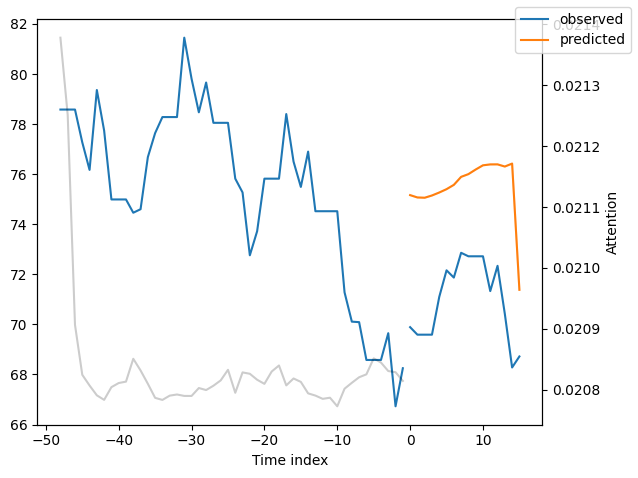

Plot for Window 60


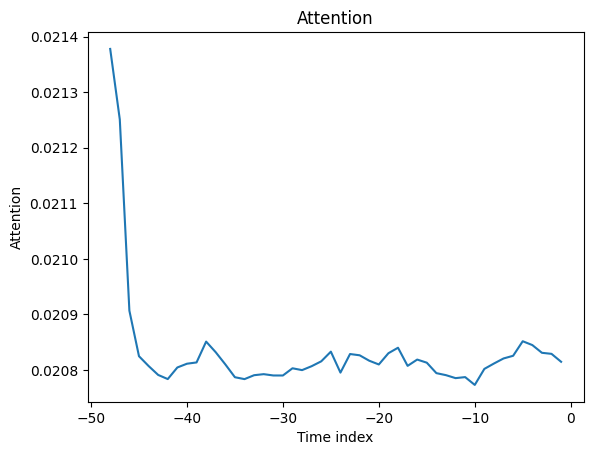

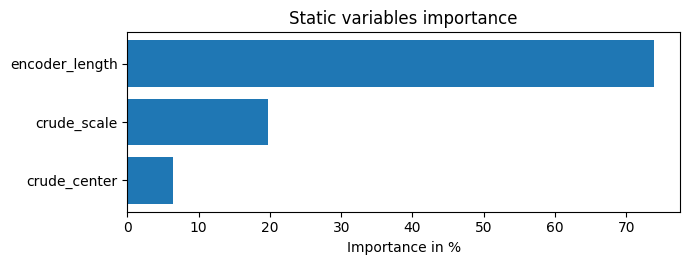

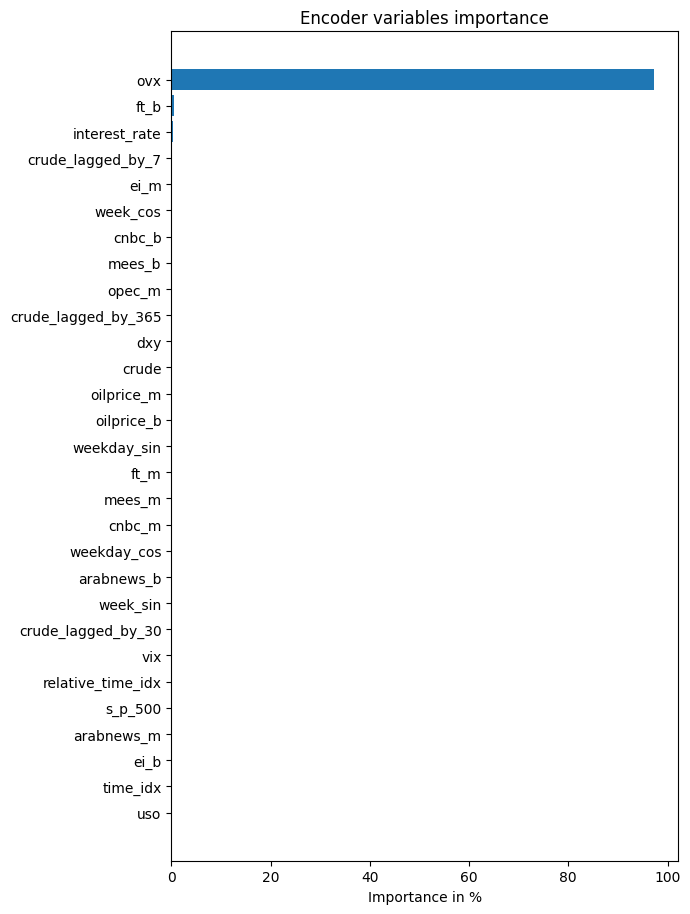

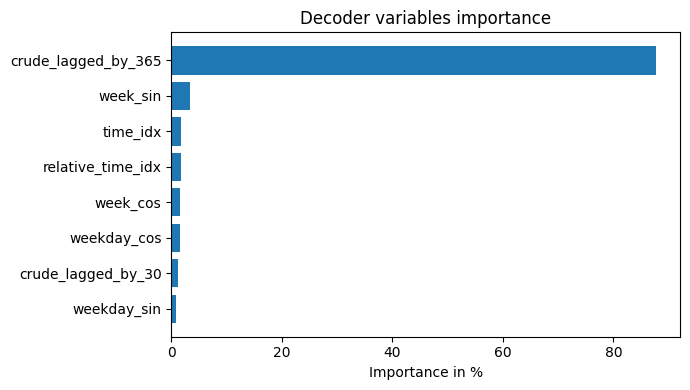

In [84]:
 get_all_plots(0, 70, 10, tft, tests, train, training_dataset, 64)

In [67]:
first_preds_test = get_first_preds(tft, tests, train, training_dataset, 64)

Window: 100%|██████████| 74/74 [00:55<00:00,  1.33it/s]


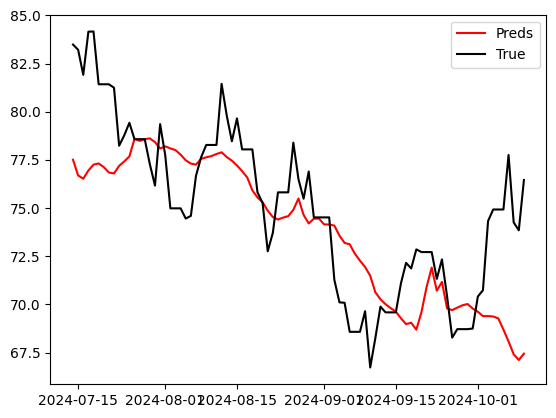

In [88]:
plt.plot(test_dates[['Date']][48:], first_preds_test, color = 'r', label = 'Preds')
plt.plot(test_dates[['Date']][48:], test[['crude']][48:], color = 'k', label = 'True')

plt.legend()
plt.show()
         

In [70]:
first_preds_val = get_first_preds(tft, val_windows, train, training_dataset, 64)

Window: 100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


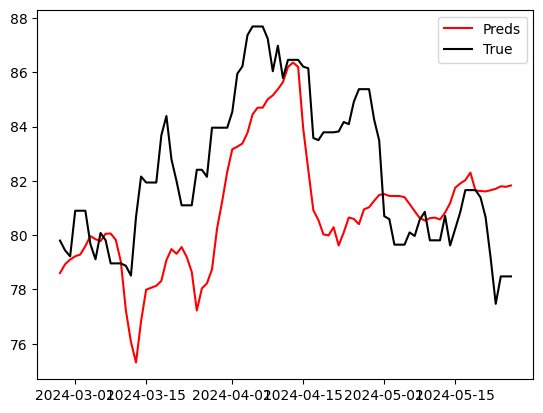

In [87]:
plt.plot(val_dates[['Date']][48:], first_preds_val, color = 'r', label = 'Preds')
plt.plot(val_dates[['Date']][48:], val[['crude']][48:], color = 'k', label = 'True')

plt.legend()
plt.show()
         

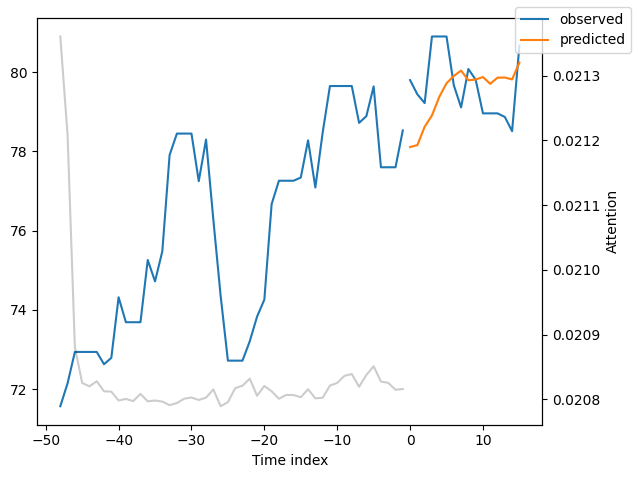

Plot for Window 0


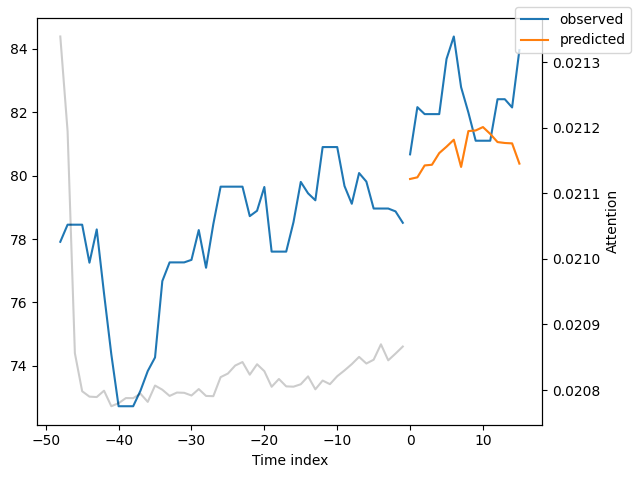

Plot for Window 15


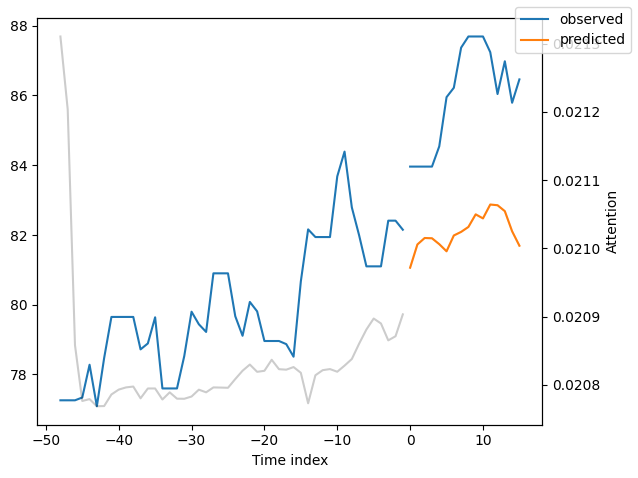

Plot for Window 30


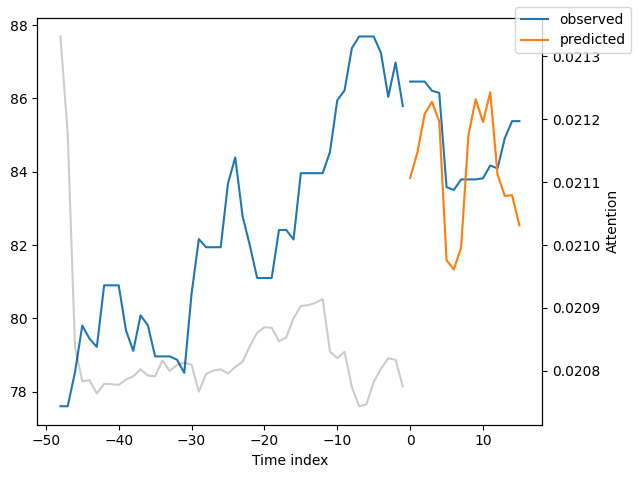

Plot for Window 45


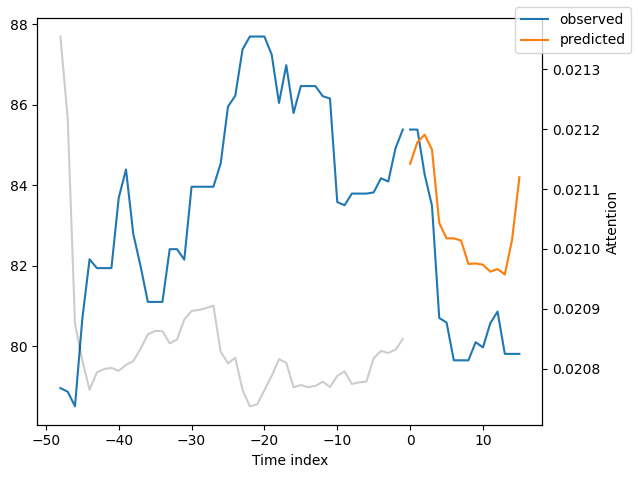

Plot for Window 60


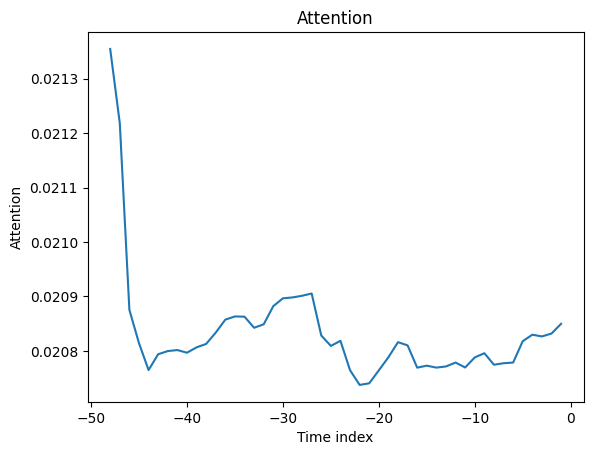

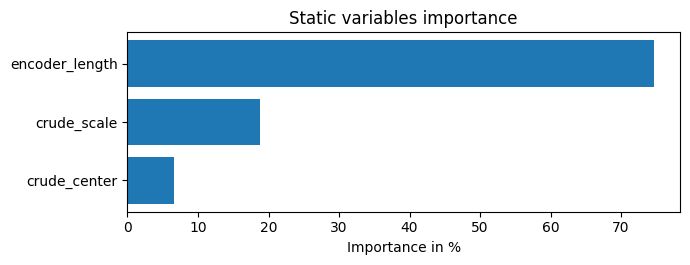

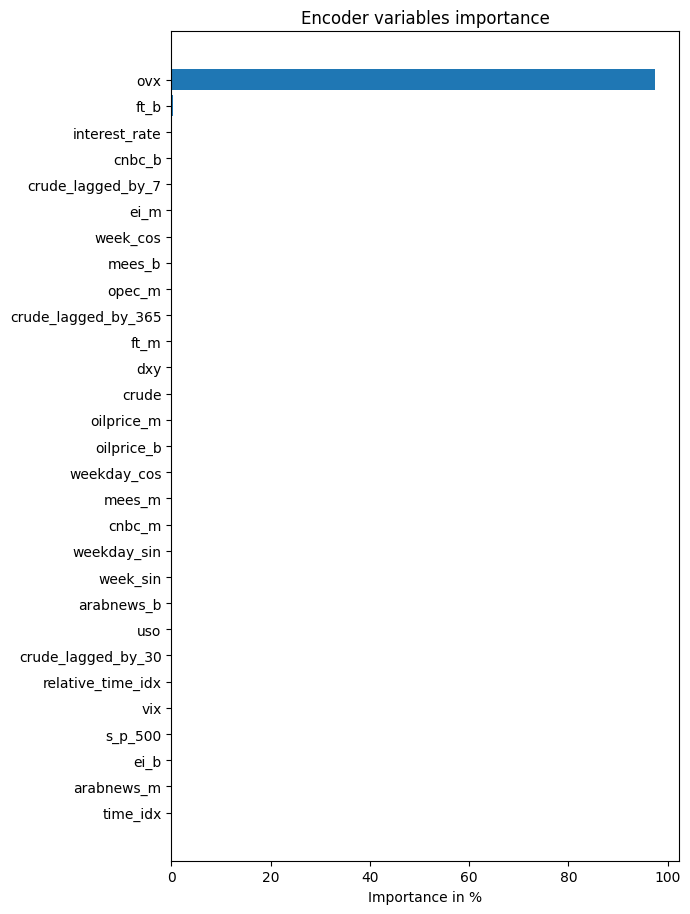

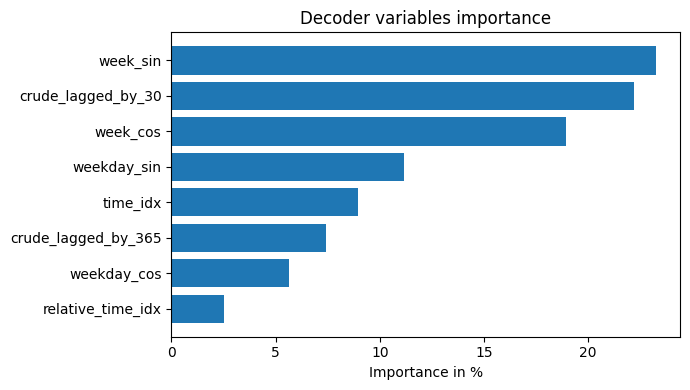

In [86]:
 get_all_plots(0, 75, 15, tft, val_windows, train, training_dataset, 64)

# Optuna Small Model

## Run

In [19]:
def objective(trial):

    HPs = {   'epochs': trial.suggest_int("epochs", 5, 20, step = 5), 
              'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
              'hidden_size': trial.suggest_int("hidden_size", 16, 128, step=16),
              'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
              'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
              'hidden_continous_size': trial.suggest_int("hidden_continous_size", 16, 128, step=16), 
              'dropout': trial.suggest_float("dropout", 0.1, 0.4, step=0.1), 
              'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE']),
              'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1), # using percentages
              'batch_size': trial.suggest_int("batch_size", 32, 128, step= 16), 
              'max_encoder_length': trial.suggest_int('max_encoder_length', 16, 112, step = 16 )
              }

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None

In [20]:
def train_model(HPs): 



    max_encoder_length = HPs['max_encoder_length']#history
    max_prediction_length = 16 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
           'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
           'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    
    tests = get_test_windows(test, max_encoder_length, max_prediction_length)
    val_windows = get_test_windows(val, max_encoder_length, max_prediction_length)

    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    hidden_continuous_size=HPs['hidden_continous_size'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    print('Success')

    try: 
        window_losses_mape, window_losses_smape, window_losses_mae, window_losses_rmse = get_total_loss_optuna(tft, 
                                                                                                               val_windows, 
                                                                                                               train, 
                                                                                                               training_dataset, 
                                                                                                               max_encoder_length + max_prediction_length,
                                                                                                               HPs) 
    except Exception as e: 
        print(e)

    loss = np.mean(window_losses_smape)
    return loss


    




    

In [21]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_small_tuning', 
                            storage='sqlite:///tft_small_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 
                                                 # file and continues the hyperparameer tuning
study.optimize(objective, n_trials=100)

# save the 'study' object into a pickle file for analysis
joblib.dump(study, "tft_small_tuning.pkl")

[I 2024-12-12 17:19:24,543] Using an existing study with name 'tft_small_tuning' instead of creating a new one.


Epoch 0: 100%|██████████| 21/21 [00:04<00:00,  4.38it/s, v_num=5.47e+7, train_loss_step=6.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 21/21 [00:03<00:00,  6.04it/s, v_num=5.47e+7, train_loss_step=4.640, val_loss=1.790, train_loss_epoch=5.760]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 21/21 [00:03<00:00,  5.53it/s, v_num=5.47e+7, train_loss_step=4.730, val_loss=1.450, train_loss_epoch=5.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 21/21 [00:02<00:00,  7.55it/s, v_num=5.47e+7, train_loss_step=5.200, val_loss=1.660, train_loss_epoch=5.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 21/21 [00:02<00:00,  7.09it/s, v_num=5.47e+7, train_loss_step=3.510, val_loss=1.500, train_loss_epoch=4.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 21/21 [00:03<00:00,  6.57it/s, v_num=5.47e+7, train_loss_step=3.820, val_loss=1.670, train_loss_epoch=4.420]


Window: 100%|██████████| 107/107 [02:06<00:00,  1.18s/it]
[I 2024-12-12 17:23:07,252] Trial 181 finished with value: 0.03986540322722954 and parameters: {'epochs': 15, 'learning_rate': 0.006849477819222363, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 4, 'hidden_continous_size': 80, 'dropout': 0.2, 'loss': 'RMSE', 'gradient_clip_val': 0.1, 'batch_size': 32, 'max_encoder_length': 16}. Best is trial 3 with value: 0.02829304992876671.


Mean Losses Across Windows:
  - Mean MAPE: 0.0392
  - Mean SMAPE: 0.0399
  - Mean MAE: 3.1740
  - Mean RMSE: 3.5325
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s, v_num=5.47e+7, train_loss_step=6.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  4.48it/s, v_num=5.47e+7, train_loss_step=5.720, val_loss=4.570, train_loss_epoch=6.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  4.76it/s, v_num=5.47e+7, train_loss_step=4.880, val_loss=4.470, train_loss_epoch=5.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s, v_num=5.47e+7, train_loss_step=4.430, val_loss=2.810, train_loss_epoch=4.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s, v_num=5.47e+7, train_loss_step=4.550, val_loss=3.610, train_loss_epoch=4.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████

Window: 100%|██████████| 59/59 [01:10<00:00,  1.19s/it]
[I 2024-12-12 17:24:43,475] Trial 185 finished with value: 0.056426032604176106 and parameters: {'epochs': 5, 'learning_rate': 0.0006534697468183952, 'hidden_size': 48, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 96, 'dropout': 0.30000000000000004, 'loss': 'RMSE', 'gradient_clip_val': 0.5, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 3 with value: 0.02829304992876671.


Mean Losses Across Windows:
  - Mean MAPE: 0.0553
  - Mean SMAPE: 0.0564
  - Mean MAE: 4.6304
  - Mean RMSE: 4.8553
Epoch 0: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, v_num=5.47e+7, train_loss_step=7.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:03<00:00,  3.92it/s, v_num=5.47e+7, train_loss_step=6.480, val_loss=2.380, train_loss_epoch=6.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s, v_num=5.47e+7, train_loss_step=5.480, val_loss=1.620, train_loss_epoch=6.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:02<00:00,  5.87it/s, v_num=5.47e+7, train_loss_step=3.900, val_loss=1.470, train_loss_epoch=5.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 14/14 [00:03<00:00,  4.08it/s, v_num=5.47e+7, train_loss_step=4.240, val_loss=2.220, train_loss_epoch=4.810]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████

Window: 100%|██████████| 91/91 [01:48<00:00,  1.20s/it]
[I 2024-12-12 17:27:43,064] Trial 188 finished with value: 0.05127483010701426 and parameters: {'epochs': 15, 'learning_rate': 0.003485242873388258, 'hidden_size': 48, 'lstm_layers': 3, 'attention_head_size': 4, 'hidden_continous_size': 112, 'dropout': 0.2, 'loss': 'RMSE', 'gradient_clip_val': 1.0, 'batch_size': 48, 'max_encoder_length': 32}. Best is trial 3 with value: 0.02829304992876671.


Mean Losses Across Windows:
  - Mean MAPE: 0.0500
  - Mean SMAPE: 0.0513
  - Mean MAE: 4.1116
  - Mean RMSE: 4.3374
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, v_num=5.47e+7, train_loss_step=7.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=5.47e+7, train_loss_step=5.610, val_loss=2.500, train_loss_epoch=9.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=5.47e+7, train_loss_step=5.160, val_loss=2.220, train_loss_epoch=6.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, v_num=5.47e+7, train_loss_step=5.000, val_loss=2.730, train_loss_epoch=5.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=5.47e+7, train_loss_step=5.060, val_loss=1.530, train_loss_epoch=5.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4

Window: 100%|██████████| 43/43 [00:59<00:00,  1.38s/it]
[I 2024-12-12 17:29:24,916] Trial 192 finished with value: 0.03626950132812178 and parameters: {'epochs': 10, 'learning_rate': 0.028788084378423392, 'hidden_size': 32, 'lstm_layers': 2, 'attention_head_size': 3, 'hidden_continous_size': 64, 'dropout': 0.30000000000000004, 'loss': 'RMSE', 'gradient_clip_val': 0.1, 'batch_size': 128, 'max_encoder_length': 80}. Best is trial 3 with value: 0.02829304992876671.


Mean Losses Across Windows:
  - Mean MAPE: 0.0367
  - Mean SMAPE: 0.0363
  - Mean MAE: 3.0197
  - Mean RMSE: 3.2940
Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  5.32it/s, v_num=5.47e+7, train_loss_step=6.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:04<00:00,  2.20it/s, v_num=5.47e+7, train_loss_step=5.040, val_loss=3.010, train_loss_epoch=7.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s, v_num=5.47e+7, train_loss_step=3.950, val_loss=5.300, train_loss_epoch=5.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s, v_num=5.47e+7, train_loss_step=3.670, val_loss=2.680, train_loss_epoch=4.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s, v_num=5.47e+7, train_loss_step=3.230, val_loss=1.550, train_loss_epoch=3.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9

Window: 100%|██████████| 27/27 [00:38<00:00,  1.43s/it]
[I 2024-12-12 17:31:22,487] Trial 194 finished with value: 0.023986074090417888 and parameters: {'epochs': 15, 'learning_rate': 0.003570195372352183, 'hidden_size': 16, 'lstm_layers': 4, 'attention_head_size': 4, 'hidden_continous_size': 96, 'dropout': 0.1, 'loss': 'RMSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0235
  - Mean SMAPE: 0.0240
  - Mean MAE: 1.9530
  - Mean RMSE: 2.2622
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s, v_num=5.47e+7, train_loss_step=6.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s, v_num=5.47e+7, train_loss_step=5.320, val_loss=3.960, train_loss_epoch=8.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s, v_num=5.47e+7, train_loss_step=5.020, val_loss=3.030, train_loss_epoch=5.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s, v_num=5.47e+7, train_loss_step=4.360, val_loss=2.930, train_loss_epoch=4.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=5.47e+7, train_loss_step=3.660, val_loss=3.400, train_loss_epoch=4.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7

Window: 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]
[I 2024-12-12 17:33:11,843] Trial 197 finished with value: 0.056096240050262876 and parameters: {'epochs': 15, 'learning_rate': 0.003217425887978327, 'hidden_size': 48, 'lstm_layers': 4, 'attention_head_size': 2, 'hidden_continous_size': 128, 'dropout': 0.1, 'loss': 'RMSE', 'gradient_clip_val': 0.4, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0538
  - Mean SMAPE: 0.0561
  - Mean MAE: 4.4259
  - Mean RMSE: 5.2926
Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s, v_num=5.47e+7, train_loss_step=4.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:01<00:00,  5.20it/s, v_num=5.47e+7, train_loss_step=3.560, val_loss=6.730, train_loss_epoch=4.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:02<00:00,  4.15it/s, v_num=5.47e+7, train_loss_step=3.120, val_loss=4.450, train_loss_epoch=3.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:02<00:00,  4.00it/s, v_num=5.47e+7, train_loss_step=3.240, val_loss=2.230, train_loss_epoch=3.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s, v_num=5.47e+7, train_loss_step=2.810, val_loss=1.550, train_loss_epoch=3.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9

Window: 100%|██████████| 27/27 [00:33<00:00,  1.23s/it]
[I 2024-12-12 17:35:01,883] Trial 199 finished with value: 0.047380417585372925 and parameters: {'epochs': 20, 'learning_rate': 0.00044428971499029456, 'hidden_size': 80, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 80, 'dropout': 0.1, 'loss': 'MAE', 'gradient_clip_val': 0.6, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0486
  - Mean SMAPE: 0.0474
  - Mean MAE: 3.9249
  - Mean RMSE: 4.1408
Epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, v_num=5.47e+7, train_loss_step=0.0678]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s, v_num=5.47e+7, train_loss_step=0.056, val_loss=0.0363, train_loss_epoch=0.0776] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s, v_num=5.47e+7, train_loss_step=0.047, val_loss=0.049, train_loss_epoch=0.0615] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s, v_num=5.47e+7, train_loss_step=0.0429, val_loss=0.0356, train_loss_epoch=0.0506]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s, v_num=5.47e+7, train_loss_step=0.0396, val_loss=0.0358, train_loss_epoch=0.0435]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███

Window: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it]
[I 2024-12-12 17:36:35,503] Trial 202 finished with value: 0.041908630254593765 and parameters: {'epochs': 15, 'learning_rate': 0.0016589935242661792, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 4, 'hidden_continous_size': 112, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.4, 'batch_size': 96, 'max_encoder_length': 112}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0429
  - Mean SMAPE: 0.0419
  - Mean MAE: 3.4348
  - Mean RMSE: 3.5782
Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s, v_num=5.47e+7, train_loss_step=7.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s, v_num=5.47e+7, train_loss_step=5.800, val_loss=1.630, train_loss_epoch=8.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, v_num=5.47e+7, train_loss_step=5.310, val_loss=2.520, train_loss_epoch=6.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, v_num=5.47e+7, train_loss_step=4.630, val_loss=3.550, train_loss_epoch=5.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.22it/s, v_num=5.47e+7, train_loss_step=4.970, val_loss=2.020, train_loss_epoch=5.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████

Window: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it]


Mean Losses Across Windows:
  - Mean MAPE: 0.0437
  - Mean SMAPE: 0.0443
  - Mean MAE: 3.6617
  - Mean RMSE: 3.9424


[I 2024-12-12 17:38:51,099] Trial 204 finished with value: 0.04429234504320864 and parameters: {'epochs': 15, 'learning_rate': 0.006381148133095736, 'hidden_size': 48, 'lstm_layers': 2, 'attention_head_size': 3, 'hidden_continous_size': 48, 'dropout': 0.4, 'loss': 'RMSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 64, 'max_encoder_length': 64}. Best is trial 194 with value: 0.023986074090417888.


Epoch 0: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s, v_num=5.47e+7, train_loss_step=6.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s, v_num=5.47e+7, train_loss_step=5.490, val_loss=3.990, train_loss_epoch=7.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s, v_num=5.47e+7, train_loss_step=4.970, val_loss=5.030, train_loss_epoch=5.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s, v_num=5.47e+7, train_loss_step=4.290, val_loss=6.080, train_loss_epoch=4.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s, v_num=5.47e+7, train_loss_step=3.780, val_loss=2.890, train_loss_epoch=4.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s, v_num=5.47e+7, train_loss_step=3.560, val_loss=3.270, train_loss_epoch=3.930]
Validation: 

Window: 100%|██████████| 27/27 [00:41<00:00,  1.55s/it]
[I 2024-12-12 17:41:14,148] Trial 207 finished with value: 0.07707250987490018 and parameters: {'epochs': 20, 'learning_rate': 0.0003185647050956816, 'hidden_size': 128, 'lstm_layers': 4, 'attention_head_size': 4, 'hidden_continous_size': 64, 'dropout': 0.1, 'loss': 'RMSE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 112, 'max_encoder_length': 96}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0804
  - Mean SMAPE: 0.0771
  - Mean MAE: 6.5183
  - Mean RMSE: 6.6524
Epoch 0: 100%|██████████| 14/14 [00:02<00:00,  5.51it/s, v_num=5.47e+7, train_loss_step=6.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:03<00:00,  3.95it/s, v_num=5.47e+7, train_loss_step=5.740, val_loss=1.740, train_loss_epoch=6.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:03<00:00,  4.01it/s, v_num=5.47e+7, train_loss_step=5.460, val_loss=1.780, train_loss_epoch=6.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:02<00:00,  5.77it/s, v_num=5.47e+7, train_loss_step=5.050, val_loss=1.470, train_loss_epoch=5.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 14/14 [00:03<00:00,  3.91it/s, v_num=5.47e+7, train_loss_step=4.750, val_loss=1.350, train_loss_epoch=5.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████

Window: 100%|██████████| 91/91 [01:57<00:00,  1.29s/it]
[I 2024-12-12 17:44:01,870] Trial 210 finished with value: 0.04159188648215034 and parameters: {'epochs': 10, 'learning_rate': 0.04116251419489474, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 4, 'hidden_continous_size': 96, 'dropout': 0.2, 'loss': 'RMSE', 'gradient_clip_val': 0.2, 'batch_size': 48, 'max_encoder_length': 32}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0412
  - Mean SMAPE: 0.0416
  - Mean MAE: 3.3908
  - Mean RMSE: 3.7132
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  7.67it/s, v_num=5.47e+7, train_loss_step=4.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s, v_num=5.47e+7, train_loss_step=4.680, val_loss=4.720, train_loss_epoch=6.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s, v_num=5.47e+7, train_loss_step=4.080, val_loss=2.100, train_loss_epoch=5.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s, v_num=5.47e+7, train_loss_step=3.120, val_loss=1.460, train_loss_epoch=4.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s, v_num=5.47e+7, train_loss_step=3.480, val_loss=2.760, train_loss_epoch=3.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████

Window: 100%|██████████| 43/43 [00:59<00:00,  1.39s/it]
[I 2024-12-12 17:46:00,604] Trial 214 finished with value: 0.04872404194848482 and parameters: {'epochs': 10, 'learning_rate': 0.00978854997794797, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 4, 'hidden_continous_size': 96, 'dropout': 0.2, 'loss': 'RMSE', 'gradient_clip_val': 0.2, 'batch_size': 48, 'max_encoder_length': 80}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0500
  - Mean SMAPE: 0.0487
  - Mean MAE: 4.0907
  - Mean RMSE: 4.4367
Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s, v_num=5.47e+7, train_loss_step=7.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:03<00:00,  2.50it/s, v_num=5.47e+7, train_loss_step=5.780, val_loss=3.250, train_loss_epoch=6.750]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s, v_num=5.47e+7, train_loss_step=5.850, val_loss=1.980, train_loss_epoch=6.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s, v_num=5.47e+7, train_loss_step=4.950, val_loss=1.940, train_loss_epoch=5.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s, v_num=5.47e+7, train_loss_step=4.630, val_loss=2.420, train_loss_epoch=5.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 8/8

Window: 100%|██████████| 91/91 [02:06<00:00,  1.39s/it]
[I 2024-12-12 17:48:29,275] Trial 218 finished with value: 0.03433670120948291 and parameters: {'epochs': 5, 'learning_rate': 0.0013949908855886766, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 4, 'hidden_continous_size': 80, 'dropout': 0.30000000000000004, 'loss': 'RMSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 80, 'max_encoder_length': 32}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0337
  - Mean SMAPE: 0.0343
  - Mean MAE: 2.7681
  - Mean RMSE: 3.0838
Epoch 0: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s, v_num=5.47e+7, train_loss_step=5.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s, v_num=5.47e+7, train_loss_step=4.310, val_loss=7.050, train_loss_epoch=6.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s, v_num=5.47e+7, train_loss_step=3.520, val_loss=5.840, train_loss_epoch=4.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:05<00:00,  3.94it/s, v_num=5.47e+7, train_loss_step=4.270, val_loss=3.200, train_loss_epoch=3.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s, v_num=5.47e+7, train_loss_step=3.150, val_loss=3.320, train_loss_epoch=3.830]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████

Window: 100%|██████████| 59/59 [01:19<00:00,  1.35s/it]
[I 2024-12-12 17:50:50,493] Trial 223 finished with value: 0.03904633217696416 and parameters: {'epochs': 10, 'learning_rate': 0.0046917768981332075, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 112, 'dropout': 0.1, 'loss': 'RMSE', 'gradient_clip_val': 0.5, 'batch_size': 32, 'max_encoder_length': 64}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0396
  - Mean SMAPE: 0.0390
  - Mean MAE: 3.2681
  - Mean RMSE: 3.5855
Epoch 0: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s, v_num=5.47e+7, train_loss_step=5.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s, v_num=5.47e+7, train_loss_step=4.230, val_loss=5.590, train_loss_epoch=7.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:03<00:00,  2.39it/s, v_num=5.47e+7, train_loss_step=3.680, val_loss=2.340, train_loss_epoch=4.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:03<00:00,  2.27it/s, v_num=5.47e+7, train_loss_step=3.800, val_loss=2.820, train_loss_epoch=3.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s, v_num=5.47e+7, train_loss_step=3.140, val_loss=2.740, train_loss_epoch=3.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9

Window: 100%|██████████| 27/27 [00:39<00:00,  1.48s/it]
[I 2024-12-12 17:52:47,516] Trial 227 finished with value: 0.03333122938595436 and parameters: {'epochs': 15, 'learning_rate': 0.0021940837300184262, 'hidden_size': 64, 'lstm_layers': 2, 'attention_head_size': 4, 'hidden_continous_size': 96, 'dropout': 0.2, 'loss': 'RMSE', 'gradient_clip_val': 0.1, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 194 with value: 0.023986074090417888.


Mean Losses Across Windows:
  - Mean MAPE: 0.0337
  - Mean SMAPE: 0.0333
  - Mean MAE: 2.7399
  - Mean RMSE: 2.9058
Epoch 0: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s, v_num=5.47e+7, train_loss_step=0.0543]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s, v_num=5.47e+7, train_loss_step=0.0433, val_loss=0.024, train_loss_epoch=0.071]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s, v_num=5.47e+7, train_loss_step=0.0415, val_loss=0.0235, train_loss_epoch=0.0519]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s, v_num=5.47e+7, train_loss_step=0.0374, val_loss=0.0216, train_loss_epoch=0.0443]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s, v_num=5.47e+7, train_loss_step=0.0419, val_loss=0.0174, train_loss_epoch=0.040] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:

Window: 100%|██████████| 11/11 [00:15<00:00,  1.42s/it]
[I 2024-12-12 17:54:06,868] Trial 229 finished with value: 0.010967263105240736 and parameters: {'epochs': 10, 'learning_rate': 0.0006670835481117511, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 80, 'dropout': 0.30000000000000004, 'loss': 'SMAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 48, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0110
  - Mean SMAPE: 0.0110
  - Mean MAE: 0.8786
  - Mean RMSE: 1.0808
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s, v_num=5.47e+7, train_loss_step=0.0758]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s, v_num=5.47e+7, train_loss_step=0.068, val_loss=0.0304, train_loss_epoch=0.0776] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s, v_num=5.47e+7, train_loss_step=0.0534, val_loss=0.0274, train_loss_epoch=0.0662]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s, v_num=5.47e+7, train_loss_step=0.0418, val_loss=0.0295, train_loss_epoch=0.0557]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s, v_num=5.47e+7, train_loss_step=0.040, val_loss=0.0279, train_loss_epoch=0.0436] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██

Window: 100%|██████████| 11/11 [00:15<00:00,  1.39s/it]
[I 2024-12-12 17:54:41,128] Trial 232 finished with value: 0.09784572165120732 and parameters: {'epochs': 5, 'learning_rate': 0.0007885787349846898, 'hidden_size': 48, 'lstm_layers': 4, 'attention_head_size': 2, 'hidden_continous_size': 48, 'dropout': 0.30000000000000004, 'loss': 'SMAPE', 'gradient_clip_val': 0.4, 'batch_size': 80, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0932
  - Mean SMAPE: 0.0978
  - Mean MAE: 7.4947
  - Mean RMSE: 7.5658
Epoch 0: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s, v_num=5.47e+7, train_loss_step=0.0605]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:04<00:00,  2.23it/s, v_num=5.47e+7, train_loss_step=0.0637, val_loss=0.0317, train_loss_epoch=0.069]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:03<00:00,  2.66it/s, v_num=5.47e+7, train_loss_step=0.0561, val_loss=0.0286, train_loss_epoch=0.0618]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:04<00:00,  2.06it/s, v_num=5.47e+7, train_loss_step=0.0501, val_loss=0.0278, train_loss_epoch=0.0573]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:04<00:00,  1.83it/s, v_num=5.47e+7, train_loss_step=0.0489, val_loss=0.0275, train_loss_epoch=0.0547]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███

Window: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]
[I 2024-12-12 17:56:20,032] Trial 233 finished with value: 0.024044320325959812 and parameters: {'epochs': 15, 'learning_rate': 0.0002060344424585119, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 64, 'dropout': 0.30000000000000004, 'loss': 'SMAPE', 'gradient_clip_val': 0.6, 'batch_size': 64, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0245
  - Mean SMAPE: 0.0240
  - Mean MAE: 1.9536
  - Mean RMSE: 2.2844
Epoch 0: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, v_num=5.47e+7, train_loss_step=0.080] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:04<00:00,  2.12it/s, v_num=5.47e+7, train_loss_step=0.0769, val_loss=0.0361, train_loss_epoch=0.0853]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:03<00:00,  2.54it/s, v_num=5.47e+7, train_loss_step=0.0786, val_loss=0.0263, train_loss_epoch=0.0819]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s, v_num=5.47e+7, train_loss_step=0.0756, val_loss=0.026, train_loss_epoch=0.0794] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s, v_num=5.47e+7, train_loss_step=0.0756, val_loss=0.0278, train_loss_epoch=0.0778]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]
[I 2024-12-12 17:57:56,523] Trial 236 finished with value: 0.024507608942010185 and parameters: {'epochs': 15, 'learning_rate': 0.0001033758235373477, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 64, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 64, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0242
  - Mean SMAPE: 0.0245
  - Mean MAE: 1.9470
  - Mean RMSE: 2.1402
Epoch 0: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s, v_num=5.47e+7, train_loss_step=0.0702]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:03<00:00,  3.20it/s, v_num=5.47e+7, train_loss_step=0.0615, val_loss=0.0346, train_loss_epoch=0.0799]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, v_num=5.47e+7, train_loss_step=0.0511, val_loss=0.0302, train_loss_epoch=0.0638]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, v_num=5.47e+7, train_loss_step=0.0447, val_loss=0.0327, train_loss_epoch=0.0549]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s, v_num=5.47e+7, train_loss_step=0.0368, val_loss=0.0249, train_loss_epoch=0.0472]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 

Window: 100%|██████████| 11/11 [00:15<00:00,  1.40s/it]


Mean Losses Across Windows:
  - Mean MAPE: 0.0269
  - Mean SMAPE: 0.0271
  - Mean MAE: 2.1680
  - Mean RMSE: 2.4981


[I 2024-12-12 17:59:43,525] Trial 238 finished with value: 0.027142096988179466 and parameters: {'epochs': 15, 'learning_rate': 0.00042274016342376335, 'hidden_size': 96, 'lstm_layers': 4, 'attention_head_size': 2, 'hidden_continous_size': 48, 'dropout': 0.30000000000000004, 'loss': 'SMAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 48, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Epoch 0: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s, v_num=5.47e+7, train_loss_step=0.0798]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s, v_num=5.47e+7, train_loss_step=0.0799, val_loss=0.0879, train_loss_epoch=0.0916]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:04<00:00,  2.18it/s, v_num=5.47e+7, train_loss_step=0.0682, val_loss=0.0471, train_loss_epoch=0.0816]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s, v_num=5.47e+7, train_loss_step=0.0708, val_loss=0.0235, train_loss_epoch=0.0763]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:04<00:00,  2.20it/s, v_num=5.47e+7, train_loss_step=0.0696, val_loss=0.0182, train_loss_epoch=0.0742]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9 [00:04<00:00,  2.12it/s, v_num=5.47e+7, train_loss_step=0.0699, val_loss=0.0169, train_loss_epoch=0.07

Window: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]
[I 2024-12-12 18:01:17,632] Trial 240 finished with value: 0.0925104550339959 and parameters: {'epochs': 15, 'learning_rate': 0.0001062703362914241, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 64, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 64, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0971
  - Mean SMAPE: 0.0925
  - Mean MAE: 7.7855
  - Mean RMSE: 7.8414
Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s, v_num=5.47e+7, train_loss_step=0.0845]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:02<00:00,  3.48it/s, v_num=5.47e+7, train_loss_step=0.0681, val_loss=0.0803, train_loss_epoch=0.0909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s, v_num=5.47e+7, train_loss_step=0.0727, val_loss=0.0311, train_loss_epoch=0.081] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, v_num=5.47e+7, train_loss_step=0.0763, val_loss=0.0287, train_loss_epoch=0.0766]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s, v_num=5.47e+7, train_loss_step=0.0676, val_loss=0.026, train_loss_epoch=0.073]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 11/11 [00:14<00:00,  1.35s/it]
[I 2024-12-12 18:02:32,612] Trial 242 finished with value: 0.02427471327510747 and parameters: {'epochs': 15, 'learning_rate': 0.0002036231351406725, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 32, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.8, 'batch_size': 64, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0242
  - Mean SMAPE: 0.0243
  - Mean MAE: 1.9523
  - Mean RMSE: 2.3338
Epoch 0: 100%|██████████| 9/9 [00:00<00:00,  9.62it/s, v_num=5.47e+7, train_loss_step=0.0804]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s, v_num=5.47e+7, train_loss_step=0.075, val_loss=0.0672, train_loss_epoch=0.0821] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s, v_num=5.47e+7, train_loss_step=0.0711, val_loss=0.0569, train_loss_epoch=0.0791]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:02<00:00,  3.12it/s, v_num=5.47e+7, train_loss_step=0.0776, val_loss=0.0499, train_loss_epoch=0.0767]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, v_num=5.47e+7, train_loss_step=0.0746, val_loss=0.0469, train_loss_epoch=0.0754]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 27/27 [00:34<00:00,  1.26s/it]
[I 2024-12-12 18:04:04,704] Trial 244 finished with value: 0.04279431924913769 and parameters: {'epochs': 15, 'learning_rate': 0.0002144329768645788, 'hidden_size': 16, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 16, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.9, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0440
  - Mean SMAPE: 0.0428
  - Mean MAE: 3.5402
  - Mean RMSE: 3.8599
Epoch 0: 100%|██████████| 12/12 [00:01<00:00,  6.78it/s, v_num=5.47e+7, train_loss_step=0.0777]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s, v_num=5.47e+7, train_loss_step=0.0769, val_loss=0.0369, train_loss_epoch=0.0855]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s, v_num=5.47e+7, train_loss_step=0.0595, val_loss=0.0632, train_loss_epoch=0.0765]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:03<00:00,  3.71it/s, v_num=5.47e+7, train_loss_step=0.0508, val_loss=0.0277, train_loss_epoch=0.0664]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s, v_num=5.47e+7, train_loss_step=0.0523, val_loss=0.0301, train_loss_epoch=0.0568]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 

Window: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it]
[I 2024-12-12 18:05:43,089] Trial 247 finished with value: 0.03411237895488739 and parameters: {'epochs': 20, 'learning_rate': 0.0005986342838820104, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 32, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.8, 'batch_size': 48, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0349
  - Mean SMAPE: 0.0341
  - Mean MAE: 2.7940
  - Mean RMSE: 3.1841
Epoch 0: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, v_num=5.47e+7, train_loss_step=0.0763]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s, v_num=5.47e+7, train_loss_step=0.0671, val_loss=0.0555, train_loss_epoch=0.0871]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:02<00:00,  3.17it/s, v_num=5.47e+7, train_loss_step=0.0742, val_loss=0.0322, train_loss_epoch=0.0783]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:03<00:00,  2.53it/s, v_num=5.47e+7, train_loss_step=0.0664, val_loss=0.0184, train_loss_epoch=0.0725]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s, v_num=5.47e+7, train_loss_step=0.0663, val_loss=0.0156, train_loss_epoch=0.0703]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 27/27 [00:38<00:00,  1.42s/it]
[I 2024-12-12 18:07:40,570] Trial 249 finished with value: 0.027701562339508976 and parameters: {'epochs': 15, 'learning_rate': 0.00019701658198046507, 'hidden_size': 16, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 32, 'dropout': 0.30000000000000004, 'loss': 'SMAPE', 'gradient_clip_val': 0.8, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0279
  - Mean SMAPE: 0.0277
  - Mean MAE: 2.2714
  - Mean RMSE: 2.5025
Epoch 0: 100%|██████████| 18/18 [00:02<00:00,  6.88it/s, v_num=5.47e+7, train_loss_step=0.0733]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 18/18 [00:03<00:00,  4.84it/s, v_num=5.47e+7, train_loss_step=0.0616, val_loss=0.0234, train_loss_epoch=0.0731]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 18/18 [00:03<00:00,  5.28it/s, v_num=5.47e+7, train_loss_step=0.0508, val_loss=0.0183, train_loss_epoch=0.0639]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 18/18 [00:03<00:00,  5.63it/s, v_num=5.47e+7, train_loss_step=0.0449, val_loss=0.0186, train_loss_epoch=0.0537]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 18/18 [00:03<00:00,  5.35it/s, v_num=5.47e+7, train_loss_step=0.0394, val_loss=0.0216, train_loss_epoch=0.0448]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 

Window: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]
[I 2024-12-12 18:09:29,214] Trial 252 finished with value: 0.07250980965115807 and parameters: {'epochs': 20, 'learning_rate': 0.00035305369029660003, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 2, 'hidden_continous_size': 32, 'dropout': 0.30000000000000004, 'loss': 'SMAPE', 'gradient_clip_val': 1.0, 'batch_size': 32, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0754
  - Mean SMAPE: 0.0725
  - Mean MAE: 6.0431
  - Mean RMSE: 6.1610
Epoch 0: 100%|██████████| 12/12 [00:02<00:00,  4.84it/s, v_num=5.47e+7, train_loss_step=5.870]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:03<00:00,  3.49it/s, v_num=5.47e+7, train_loss_step=6.020, val_loss=1.120, train_loss_epoch=6.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s, v_num=5.47e+7, train_loss_step=5.490, val_loss=1.220, train_loss_epoch=6.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:03<00:00,  3.73it/s, v_num=5.47e+7, train_loss_step=4.940, val_loss=2.880, train_loss_epoch=5.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s, v_num=5.47e+7, train_loss_step=4.400, val_loss=3.170, train_loss_epoch=5.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████

Window: 100%|██████████| 27/27 [00:38<00:00,  1.41s/it]
[I 2024-12-12 18:11:34,358] Trial 254 finished with value: 0.0421139334362966 and parameters: {'epochs': 15, 'learning_rate': 0.00025636599070721726, 'hidden_size': 64, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 16, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.9, 'batch_size': 48, 'max_encoder_length': 96}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0432
  - Mean SMAPE: 0.0421
  - Mean MAE: 3.5123
  - Mean RMSE: 3.7664
Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, v_num=5.47e+7, train_loss_step=0.074] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s, v_num=5.47e+7, train_loss_step=0.0787, val_loss=0.030, train_loss_epoch=0.0836]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=5.47e+7, train_loss_step=0.0793, val_loss=0.0282, train_loss_epoch=0.0815]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s, v_num=5.47e+7, train_loss_step=0.0841, val_loss=0.0292, train_loss_epoch=0.0792]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s, v_num=5.47e+7, train_loss_step=0.0744, val_loss=0.0302, train_loss_epoch=0.077] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███

Window: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it]
[I 2024-12-12 18:12:45,465] Trial 257 finished with value: 0.01661260730840943 and parameters: {'epochs': 10, 'learning_rate': 0.00015605055244024904, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 48, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0164
  - Mean SMAPE: 0.0166
  - Mean MAE: 1.3260
  - Mean RMSE: 1.6213
Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  3.83it/s, v_num=5.47e+7, train_loss_step=0.0866]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s, v_num=5.47e+7, train_loss_step=0.0855, val_loss=0.129, train_loss_epoch=0.091]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s, v_num=5.47e+7, train_loss_step=0.0826, val_loss=0.106, train_loss_epoch=0.0862]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s, v_num=5.47e+7, train_loss_step=0.072, val_loss=0.0848, train_loss_epoch=0.0807] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.74it/s, v_num=5.47e+7, train_loss_step=0.0686, val_loss=0.0671, train_loss_epoch=0.0767]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████

Window: 100%|██████████| 43/43 [01:06<00:00,  1.54s/it]
[I 2024-12-12 18:14:42,171] Trial 258 finished with value: 0.04613550925670668 and parameters: {'epochs': 10, 'learning_rate': 0.00014698596210271832, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 2, 'hidden_continous_size': 48, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.6, 'batch_size': 96, 'max_encoder_length': 80}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0449
  - Mean SMAPE: 0.0461
  - Mean MAE: 3.7953
  - Mean RMSE: 3.9913
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s, v_num=5.47e+7, train_loss_step=0.0702]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s, v_num=5.47e+7, train_loss_step=0.0555, val_loss=0.0402, train_loss_epoch=0.0744]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s, v_num=5.47e+7, train_loss_step=0.0521, val_loss=0.0458, train_loss_epoch=0.0658]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s, v_num=5.47e+7, train_loss_step=0.0482, val_loss=0.029, train_loss_epoch=0.0571] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=5.47e+7, train_loss_step=0.0421, val_loss=0.0257, train_loss_epoch=0.0504]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]
[I 2024-12-12 18:16:14,778] Trial 262 finished with value: 0.03258651757129916 and parameters: {'epochs': 10, 'learning_rate': 0.0010224163864608726, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 80, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.5, 'batch_size': 80, 'max_encoder_length': 96}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0330
  - Mean SMAPE: 0.0326
  - Mean MAE: 2.6759
  - Mean RMSE: 2.8072
Epoch 0: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s, v_num=5.47e+7, train_loss_step=0.0753]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s, v_num=5.47e+7, train_loss_step=0.0711, val_loss=0.0435, train_loss_epoch=0.0743]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:03<00:00,  2.26it/s, v_num=5.47e+7, train_loss_step=0.0632, val_loss=0.0221, train_loss_epoch=0.0702]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s, v_num=5.47e+7, train_loss_step=0.0711, val_loss=0.0245, train_loss_epoch=0.0675]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:03<00:00,  2.52it/s, v_num=5.47e+7, train_loss_step=0.0564, val_loss=0.0294, train_loss_epoch=0.0651]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]
[I 2024-12-12 18:17:31,841] Trial 265 finished with value: 0.019867196679115295 and parameters: {'epochs': 10, 'learning_rate': 0.00016698646102269795, 'hidden_size': 32, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 48, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 64, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0201
  - Mean SMAPE: 0.0199
  - Mean MAE: 1.6051
  - Mean RMSE: 1.7848
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s, v_num=5.47e+7, train_loss_step=0.0774]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s, v_num=5.47e+7, train_loss_step=0.0768, val_loss=0.0217, train_loss_epoch=0.0805]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=5.47e+7, train_loss_step=0.0745, val_loss=0.0188, train_loss_epoch=0.0775]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s, v_num=5.47e+7, train_loss_step=0.080, val_loss=0.0179, train_loss_epoch=0.0773] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s, v_num=5.47e+7, train_loss_step=0.0752, val_loss=0.0197, train_loss_epoch=0.0741]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]
[I 2024-12-12 18:18:46,476] Trial 267 finished with value: 0.03944192013957284 and parameters: {'epochs': 10, 'learning_rate': 0.0001527160976275756, 'hidden_size': 16, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 48, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0386
  - Mean SMAPE: 0.0394
  - Mean MAE: 3.1099
  - Mean RMSE: 3.2521
Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s, v_num=5.47e+7, train_loss_step=0.0637]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s, v_num=5.47e+7, train_loss_step=0.0641, val_loss=0.0191, train_loss_epoch=0.0695]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s, v_num=5.47e+7, train_loss_step=0.061, val_loss=0.0185, train_loss_epoch=0.0648] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s, v_num=5.47e+7, train_loss_step=0.0517, val_loss=0.0184, train_loss_epoch=0.0603]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s, v_num=5.47e+7, train_loss_step=0.0483, val_loss=0.0187, train_loss_epoch=0.0566]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]
[I 2024-12-12 18:19:59,734] Trial 270 finished with value: 0.05892251872203567 and parameters: {'epochs': 10, 'learning_rate': 0.0005458587557434885, 'hidden_size': 32, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 64, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 80, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0571
  - Mean SMAPE: 0.0589
  - Mean MAE: 4.5965
  - Mean RMSE: 4.7613
Epoch 0: 100%|██████████| 9/9 [00:02<00:00,  3.55it/s, v_num=5.47e+7, train_loss_step=0.0885]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s, v_num=5.47e+7, train_loss_step=0.0634, val_loss=0.0334, train_loss_epoch=0.0945]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:04<00:00,  2.21it/s, v_num=5.47e+7, train_loss_step=0.0647, val_loss=0.0224, train_loss_epoch=0.0736]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:04<00:00,  1.85it/s, v_num=5.47e+7, train_loss_step=0.0616, val_loss=0.0528, train_loss_epoch=0.0659]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:04<00:00,  2.20it/s, v_num=5.47e+7, train_loss_step=0.0534, val_loss=0.0683, train_loss_epoch=0.0625]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 27/27 [00:39<00:00,  1.46s/it]
[I 2024-12-12 18:21:36,075] Trial 272 finished with value: 0.13903265391234998 and parameters: {'epochs': 10, 'learning_rate': 0.00028143665423980446, 'hidden_size': 48, 'lstm_layers': 4, 'attention_head_size': 3, 'hidden_continous_size': 64, 'dropout': 0.30000000000000004, 'loss': 'MAPE', 'gradient_clip_val': 0.6, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.1293
  - Mean SMAPE: 0.1390
  - Mean MAE: 10.5927
  - Mean RMSE: 10.8030
Epoch 0: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s, v_num=5.47e+7, train_loss_step=0.0763]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s, v_num=5.47e+7, train_loss_step=0.0597, val_loss=0.017, train_loss_epoch=0.0833]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s, v_num=5.47e+7, train_loss_step=0.058, val_loss=0.0528, train_loss_epoch=0.0682] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s, v_num=5.47e+7, train_loss_step=0.0451, val_loss=0.0368, train_loss_epoch=0.0599]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.99it/s, v_num=5.47e+7, train_loss_step=0.0377, val_loss=0.0222, train_loss_epoch=0.0506]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█

Window: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Mean Losses Across Windows:
  - Mean MAPE: 0.0139
  - Mean SMAPE: 0.0138
  - Mean MAE: 1.1111
  - Mean RMSE: 1.3247


[I 2024-12-12 18:22:47,175] Trial 275 finished with value: 0.013799317350441759 and parameters: {'epochs': 10, 'learning_rate': 0.0022431351765258914, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 80, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.5, 'batch_size': 96, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Epoch 0: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s, v_num=5.47e+7, train_loss_step=0.0799]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s, v_num=5.47e+7, train_loss_step=0.0685, val_loss=0.0156, train_loss_epoch=0.0836]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s, v_num=5.47e+7, train_loss_step=0.0616, val_loss=0.0195, train_loss_epoch=0.0678]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s, v_num=5.47e+7, train_loss_step=0.0442, val_loss=0.0186, train_loss_epoch=0.0602]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s, v_num=5.47e+7, train_loss_step=0.0411, val_loss=0.0224, train_loss_epoch=0.0525]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s, v_num=5.47e+7, train_loss_step=0.0404, val_loss=0.0269, train_loss_epoch=0.04

Window: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]
[I 2024-12-12 18:23:51,676] Trial 277 finished with value: 0.020160467279228298 and parameters: {'epochs': 10, 'learning_rate': 0.0027760360933557697, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 80, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0205
  - Mean SMAPE: 0.0202
  - Mean MAE: 1.6340
  - Mean RMSE: 1.9973
Epoch 0: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s, v_num=5.47e+7, train_loss_step=0.0655]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s, v_num=5.47e+7, train_loss_step=0.0587, val_loss=0.0342, train_loss_epoch=0.0751]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s, v_num=5.47e+7, train_loss_step=0.0548, val_loss=0.0315, train_loss_epoch=0.0626]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s, v_num=5.47e+7, train_loss_step=0.0466, val_loss=0.0364, train_loss_epoch=0.0568]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s, v_num=5.47e+7, train_loss_step=0.0429, val_loss=0.0441, train_loss_epoch=0.0496]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 11/11 [00:17<00:00,  1.55s/it]
[I 2024-12-12 18:25:04,313] Trial 279 finished with value: 0.07167625562711195 and parameters: {'epochs': 10, 'learning_rate': 0.0019121500391579536, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 80, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0690
  - Mean SMAPE: 0.0717
  - Mean MAE: 5.5567
  - Mean RMSE: 5.7223
Epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s, v_num=5.47e+7, train_loss_step=0.0682]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s, v_num=5.47e+7, train_loss_step=0.0573, val_loss=0.0211, train_loss_epoch=0.0799]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s, v_num=5.47e+7, train_loss_step=0.0555, val_loss=0.0198, train_loss_epoch=0.061] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s, v_num=5.47e+7, train_loss_step=0.0474, val_loss=0.0277, train_loss_epoch=0.0542]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s, v_num=5.47e+7, train_loss_step=0.0452, val_loss=0.0552, train_loss_epoch=0.0509]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██

Window: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it]
[I 2024-12-12 18:25:50,999] Trial 282 finished with value: 0.08239345387978987 and parameters: {'epochs': 5, 'learning_rate': 0.0024816646576633606, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 80, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.5, 'batch_size': 96, 'max_encoder_length': 112}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0860
  - Mean SMAPE: 0.0824
  - Mean MAE: 6.8966
  - Mean RMSE: 6.9637
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=5.47e+7, train_loss_step=0.0642]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=5.47e+7, train_loss_step=0.0568, val_loss=0.0245, train_loss_epoch=0.0755]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=5.47e+7, train_loss_step=0.0458, val_loss=0.0487, train_loss_epoch=0.060] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=5.47e+7, train_loss_step=0.0431, val_loss=0.0316, train_loss_epoch=0.0476]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=5.47e+7, train_loss_step=0.0405, val_loss=0.0541, train_loss_epoch=0.0437]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 27/27 [00:42<00:00,  1.56s/it]
[I 2024-12-12 18:27:26,787] Trial 284 finished with value: 0.06009220787220531 and parameters: {'epochs': 10, 'learning_rate': 0.0010347492667728334, 'hidden_size': 96, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 80, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.4, 'batch_size': 128, 'max_encoder_length': 96}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0622
  - Mean SMAPE: 0.0601
  - Mean MAE: 5.0285
  - Mean RMSE: 5.2194
Epoch 0: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s, v_num=5.47e+7, train_loss_step=0.0639]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s, v_num=5.47e+7, train_loss_step=0.0539, val_loss=0.0283, train_loss_epoch=0.0716]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s, v_num=5.47e+7, train_loss_step=0.0435, val_loss=0.0399, train_loss_epoch=0.0564]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s, v_num=5.47e+7, train_loss_step=0.0452, val_loss=0.110, train_loss_epoch=0.045]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s, v_num=5.47e+7, train_loss_step=0.0366, val_loss=0.0526, train_loss_epoch=0.0422]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██

Window: 100%|██████████| 43/43 [01:06<00:00,  1.54s/it]
[I 2024-12-12 18:29:20,567] Trial 287 finished with value: 0.047280579415518185 and parameters: {'epochs': 10, 'learning_rate': 0.005189580872185999, 'hidden_size': 32, 'lstm_layers': 2, 'attention_head_size': 1, 'hidden_continous_size': 80, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 0.5, 'batch_size': 112, 'max_encoder_length': 80}. Best is trial 229 with value: 0.010967263105240736.


Mean Losses Across Windows:
  - Mean MAPE: 0.0488
  - Mean SMAPE: 0.0473
  - Mean MAE: 3.9784
  - Mean RMSE: 4.3441
Epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s, v_num=5.47e+7, train_loss_step=0.0565]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  33%|███▎      | 2/6 [00:01<00:03,  1.02it/s, v_num=5.47e+7, train_loss_step=0.049, val_loss=0.0601, train_loss_epoch=0.0628] 

[W 2024-12-12 18:29:30,188] Trial 291 failed with parameters: {'epochs': 10, 'learning_rate': 0.004054467707080575, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 96, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 112} because of the following error: The value None could not be cast to float..
[W 2024-12-12 18:29:30,188] Trial 291 failed with value None.


An error occurred: name 'exit' is not defined
Epoch 1:  33%|███▎      | 2/6 [00:04<00:08,  0.49it/s, v_num=5.47e+7, train_loss_step=0.049, val_loss=0.0601, train_loss_epoch=0.0628]


Exception ignored in: <function _releaseLock at 0x14d51a49ea20>
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] 

[W 2024-12-12 18:29:39,937] Trial 292 failed with parameters: {'epochs': 10, 'learning_rate': 0.012083298547166608, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 96, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 112} because of the following error: The value None could not be cast to float..
[W 2024-12-12 18:29:39,938] Trial 292 failed with value None.


An error occurred: DataLoader worker (pid(s) 4150634, 4150697, 4150760, 4150823) exited unexpectedly
Epoch 0: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s, v_num=5.47e+7, train_loss_step=0.0608]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  17%|█▋        | 1/6 [00:02<00:11,  0.42it/s, v_num=5.47e+7, train_loss_step=0.0567, val_loss=0.0696, train_loss_epoch=0.0738]

[W 2024-12-12 18:29:50,998] Trial 293 failed with parameters: {'epochs': 10, 'learning_rate': 0.003742534050739732, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 96, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 112} because of the following error: The value None could not be cast to float..
[W 2024-12-12 18:29:50,998] Trial 293 failed with value None.


An error occurred: name 'exit' is not defined
Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s]                             

[W 2024-12-12 18:29:54,597] Trial 294 failed with parameters: {'epochs': 10, 'learning_rate': 0.0038295175507514685, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 96, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 112} because of the following error: The value None could not be cast to float..
[W 2024-12-12 18:29:54,598] Trial 294 failed with value None.


An error occurred: name 'exit' is not defined


Exception ignored in: <function _releaseLock at 0x14d51a49ea20>
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] 

[W 2024-12-12 18:29:58,575] Trial 295 failed with parameters: {'epochs': 10, 'learning_rate': 0.011110104185504087, 'hidden_size': 16, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continous_size': 96, 'dropout': 0.1, 'loss': 'MAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 112} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ext3/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 574, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/ext3/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 981, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/ext3/miniforge3/lib/python3.12/site-

Epoch 0:   0%|          | 0/6 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [22]:
joblib.dump(study, "tft_small_tuning.pkl")

['tft_small_tuning.pkl']

In [26]:
study.best_value

0.010967263105240736

## Small Best Model

In [19]:
study = joblib.load("tft_small_tuning.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.010967263105240736
 Params: 
    epochs: 10
    learning_rate: 0.0006670835481117511
    hidden_size: 32
    lstm_layers: 4
    attention_head_size: 3
    hidden_continous_size: 80
    dropout: 0.30000000000000004
    loss: SMAPE
    gradient_clip_val: 0.30000000000000004
    batch_size: 48
    max_encoder_length: 112


In [ ]:
Trial 194 finished with value: 0.023986074090417888 and parameters: {'epochs': 15, 'learning_rate': 0.003570195372352183, 'hidden_size': 16, 'lstm_layers': 4, 'attention_head_size': 4, 'hidden_continous_size': 96, 'dropout': 0.1, 'loss': 'RMSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 194 with value: 0.023986074090417888.

In [74]:
    max_encoder_length = 96#history
    max_prediction_length = 16 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
           'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
           'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    
    tests = get_test_windows(test, max_encoder_length, max_prediction_length)
    val_windows = get_test_windows(val, max_encoder_length, max_prediction_length)


In [75]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = 4, 
    learning_rate = 0.003570195372352183, 
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=96, 
    loss=RMSE(),
    # logging every 10 batches

)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

#0.0031622776601683794
#0.000331131121482591, 

Number of parameters in network: 184.5k


In [76]:

batch_size = 64  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [77]:
trainer = pl.Trainer(
    max_epochs=9,
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val=0.3,
    
)


In [78]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  5.50it/s, v_num=5.47e+7, train_loss_step=6.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s, v_num=5.47e+7, train_loss_step=4.800, val_loss=1.470, train_loss_epoch=7.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, v_num=5.47e+7, train_loss_step=3.960, val_loss=4.630, train_loss_epoch=5.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s, v_num=5.47e+7, train_loss_step=3.440, val_loss=2.910, train_loss_epoch=4.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s, v_num=5.47e+7, train_loss_step=3.260, val_loss=3.400, train_loss_epoch=3.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s, v_num=5.47e+7, train_loss_step=3.140, val_loss=1.660, train_loss_epoch=3.490]
Validation: 

In [79]:
mape, smape, mae, rmse = get_total_loss(tft, val_windows, train, training_dataset, 112)


Window: 100%|██████████| 27/27 [00:27<00:00,  1.00s/it]

Mean Losses Across Windows:
  - Mean MAPE: 0.0404
  - Mean SMAPE: 0.0394
  - Mean MAE: 3.2586
  - Mean RMSE: 3.4587


In [81]:

mape, smape, mae, rmse = get_total_loss(tft, tests, train, training_dataset, 112)


Window: 100%|██████████| 26/26 [00:25<00:00,  1.00it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.1768
  - Mean SMAPE: 0.1617
  - Mean MAE: 12.4435
  - Mean RMSE: 12.7201


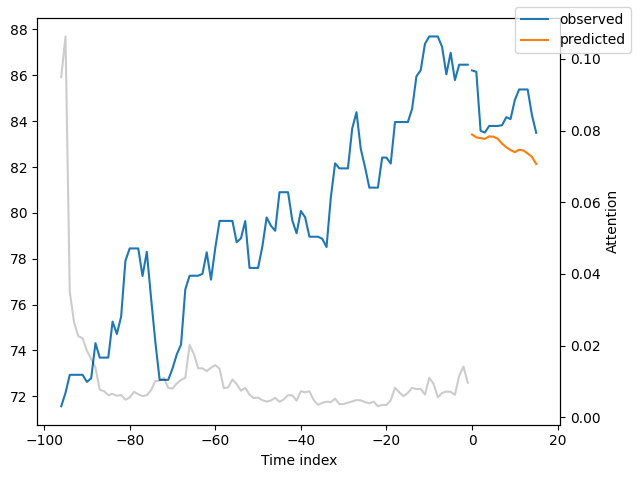

Plot for Window 0


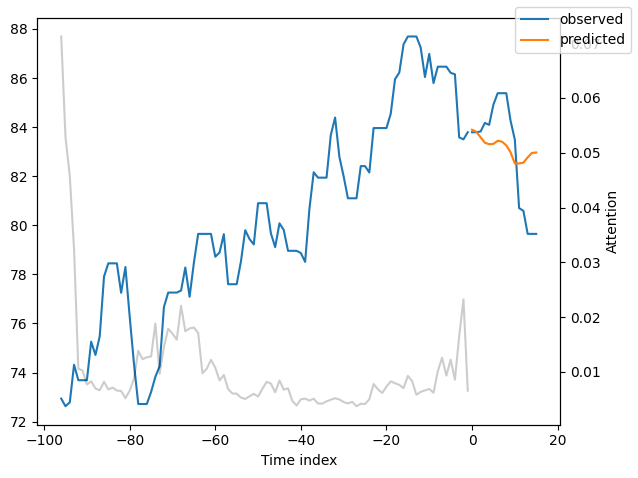

Plot for Window 5


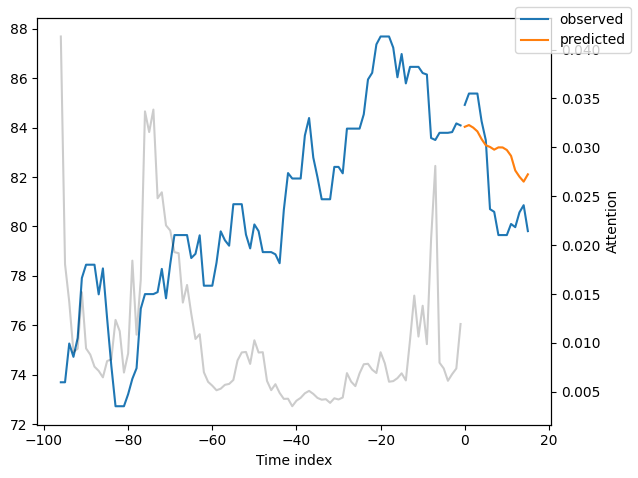

Plot for Window 10


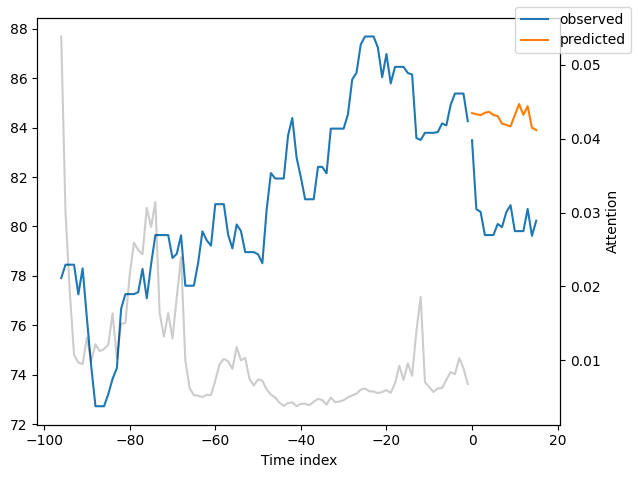

Plot for Window 15


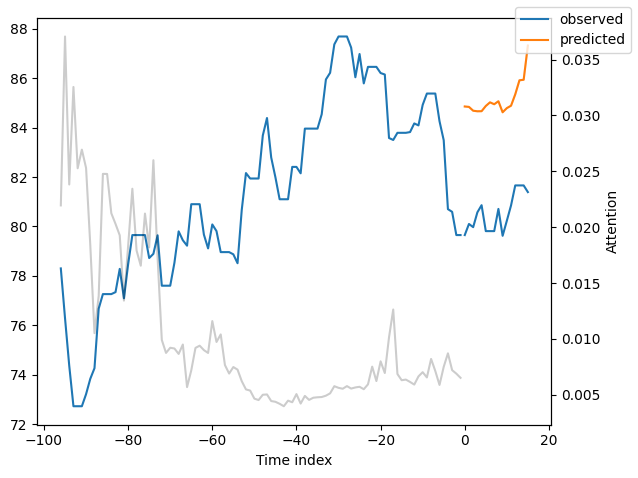

Plot for Window 20


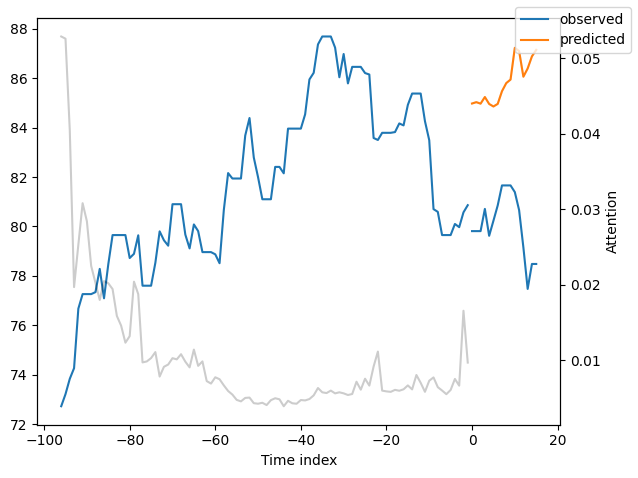

Plot for Window 25


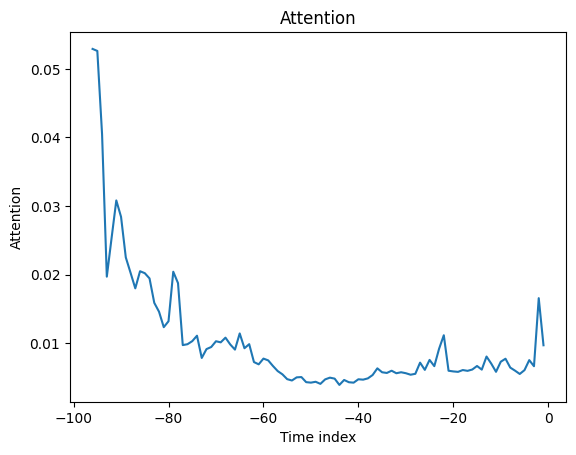

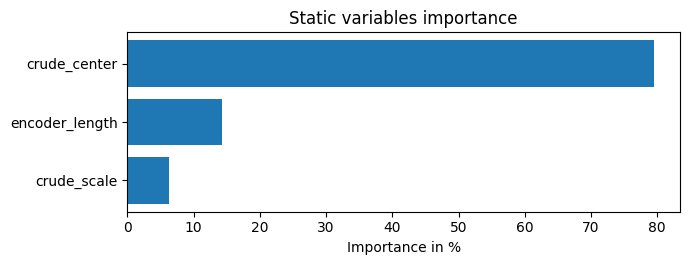

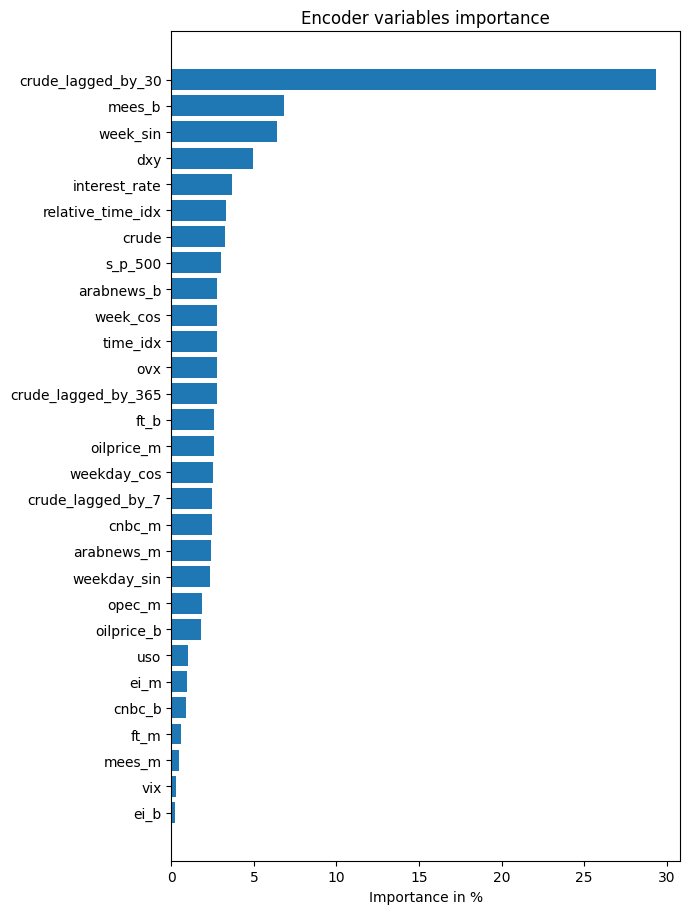

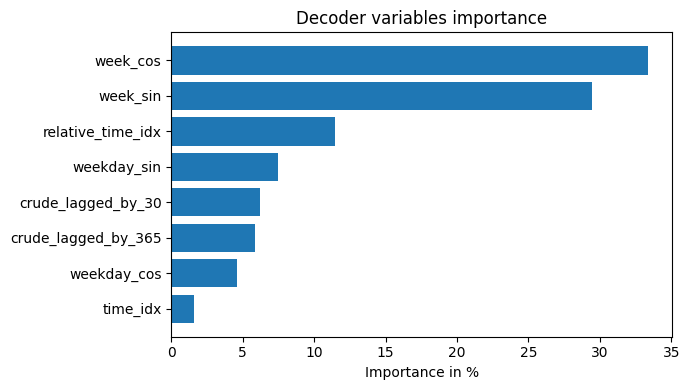

In [84]:
get_all_plots(0, 26, 5, tft, val_windows, train, training_dataset, 112)

Window: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


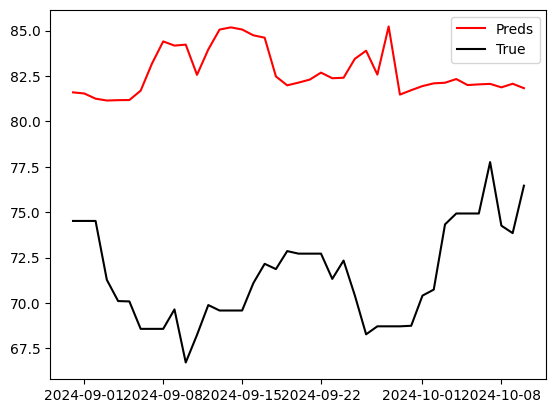

In [85]:
first_preds_test = get_first_preds(tft, tests, train, training_dataset, 112)
plt.plot(test_dates[['Date']][96:], first_preds_test, color = 'r', label = 'Preds')
plt.plot(test_dates[['Date']][96:], test[['crude']][96:], color = 'k', label = 'True')

plt.legend()
plt.show()
         

# Optuna Large Model

# Optuna Large Large Model

## Runs

In [47]:
def objective(trial):

    HPs = {   'epochs': trial.suggest_int("epochs", 5, 15, step = 5), 
              'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
              'hidden_size': trial.suggest_int("hidden_size", 8, 16, step=4),
              'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
              'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
              'dropout': trial.suggest_float("dropout", 0.1, 0.5, step=0.1), 
              'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE', 'MSE']),
              'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1), # using percentages
              'batch_size': trial.suggest_int("batch_size", 32, 128, step= 16), 
              'max_encoder_length': trial.suggest_int('max_encoder_length', 32, 128, step = 32 )
              }

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None

In [48]:
def train_model(HPs): 



    max_encoder_length = HPs['max_encoder_length']#history
    max_prediction_length = 96 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
                                    'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
                                    'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    

    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    predictions = tft.predict(val_dataloader, return_y=True)
    smape = SMAPE()(predictions.output, predictions.y).item()
    mape = MAPE()(predictions.output, predictions.y).item()
    rmse = RMSE()(predictions.output, predictions.y).item()
    mae = MAE()(predictions.output, predictions.y).item()
    mse = MSE()(predictions.output, predictions.y).item()

    print(f"""
    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): {smape*100:.2f}%
    MAPE  (Mean Absolute Percentage Error):          {mape*100:.2f}%
    RMSE  (Root Mean Squared Error):                {rmse:.2f}
    MAE   (Mean Absolute Error):                    {mae:.2f}
    MSE   (Mean Squared Error):                    {mse:.2f}
    """)

    

   
    return mse


    




    

In [49]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_large_large_tuning', 
                            storage='sqlite:///tft_large_large_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 
                                                 # file and continues the hyperparameer tuning
study.optimize(objective, n_trials=10)

# save the 'study' object into a pickle file for analysis
joblib.dump(study, "tft_large_large_tuning.pkl")

[I 2024-12-13 22:30:17,541] Using an existing study with name 'tft_large_large_tuning' instead of creating a new one.


Number of parameters in network: 25.9k
Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  6.73it/s, v_num=5.48e+7, train_loss_step=89.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s, v_num=5.48e+7, train_loss_step=64.50, val_loss=80.60, train_loss_epoch=89.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  4.21it/s, v_num=5.48e+7, train_loss_step=64.10, val_loss=101.0, train_loss_epoch=71.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s, v_num=5.48e+7, train_loss_step=62.70, val_loss=89.30, train_loss_epoch=72.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s, v_num=5.48e+7, train_loss_step=60.10, val_loss=68.60, train_loss_epoch=70.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  4.19it/s, v_num=5.48e+7, train_loss_step=61.30, val_loss=50.9

[I 2024-12-13 22:30:47,482] Trial 1 finished with value: 42.5684928894043 and parameters: {'epochs': 10, 'learning_rate': 0.0006652528410571817, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 1, 'dropout': 0.4, 'loss': 'MSE', 'gradient_clip_val': 0.8, 'batch_size': 48, 'max_encoder_length': 128}. Best is trial 0 with value: 30.319055557250977.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.19%
    MAPE  (Mean Absolute Percentage Error):          5.91%
    RMSE  (Root Mean Squared Error):                6.52
    MAE   (Mean Absolute Error):                    4.83
    MSE   (Mean Squared Error):                    42.57
    
Number of parameters in network: 20.1k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.50it/s, v_num=5.48e+7, train_loss_step=12.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=5.48e+7, train_loss_step=10.60, val_loss=9.620, train_loss_epoch=11.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=5.48e+7, train_loss_step=10.80, val_loss=9.510, train_loss_epoch=11.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=5.48e+7, train_loss_step=10.80, val_loss=9.400,

[I 2024-12-13 22:31:08,948] Trial 2 finished with value: 75.85334014892578 and parameters: {'epochs': 10, 'learning_rate': 0.00010223818165833409, 'hidden_size': 8, 'lstm_layers': 4, 'attention_head_size': 4, 'dropout': 0.5, 'loss': 'RMSE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 112, 'max_encoder_length': 64}. Best is trial 0 with value: 30.319055557250977.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 9.58%
    MAPE  (Mean Absolute Percentage Error):          10.23%
    RMSE  (Root Mean Squared Error):                8.71
    MAE   (Mean Absolute Error):                    7.58
    MSE   (Mean Squared Error):                    75.85
    
Number of parameters in network: 20.2k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 11.05it/s, v_num=5.48e+7, train_loss_step=9.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=5.48e+7, train_loss_step=9.500, val_loss=6.560, train_loss_epoch=12.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=5.48e+7, train_loss_step=8.030, val_loss=6.630, train_loss_epoch=9.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=5.48e+7, train_loss_step=7.430, val_loss=6.510

[I 2024-12-13 22:31:39,559] Trial 3 finished with value: 23.849424362182617 and parameters: {'epochs': 15, 'learning_rate': 0.004908194856939661, 'hidden_size': 8, 'lstm_layers': 4, 'attention_head_size': 1, 'dropout': 0.30000000000000004, 'loss': 'RMSE', 'gradient_clip_val': 0.6, 'batch_size': 96, 'max_encoder_length': 96}. Best is trial 3 with value: 23.849424362182617.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.69%
    MAPE  (Mean Absolute Percentage Error):          4.59%
    RMSE  (Root Mean Squared Error):                4.88
    MAE   (Mean Absolute Error):                    3.69
    MSE   (Mean Squared Error):                    23.85
    
Number of parameters in network: 17.9k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s, v_num=5.48e+7, train_loss_step=5.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s, v_num=5.48e+7, train_loss_step=5.170, val_loss=6.710, train_loss_epoch=7.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s, v_num=5.48e+7, train_loss_step=4.980, val_loss=7.490, train_loss_epoch=5.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s, v_num=5.48e+7, train_loss_step=4.300, val_loss=5.030,

[I 2024-12-13 22:32:10,432] Trial 4 finished with value: 13.020024299621582 and parameters: {'epochs': 15, 'learning_rate': 0.018184354694103916, 'hidden_size': 8, 'lstm_layers': 2, 'attention_head_size': 1, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 80, 'max_encoder_length': 128}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.80%
    MAPE  (Mean Absolute Percentage Error):          3.80%
    RMSE  (Root Mean Squared Error):                3.61
    MAE   (Mean Absolute Error):                    2.97
    MSE   (Mean Squared Error):                    13.02
    
Number of parameters in network: 16.8k
Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 14.44it/s, v_num=5.48e+7, train_loss_step=0.106]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s, v_num=5.48e+7, train_loss_step=0.128, val_loss=0.134, train_loss_epoch=0.118]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s, v_num=5.48e+7, train_loss_step=0.114, val_loss=0.130, train_loss_epoch=0.115]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s, v_num=5.48e+7, train_loss_step=0.102, val_loss=0.126,

[I 2024-12-13 22:32:22,363] Trial 5 finished with value: 123.73004150390625 and parameters: {'epochs': 5, 'learning_rate': 0.00019769689612852246, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 1, 'dropout': 0.5, 'loss': 'SMAPE', 'gradient_clip_val': 0.4, 'batch_size': 64, 'max_encoder_length': 96}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 11.87%
    MAPE  (Mean Absolute Percentage Error):          12.90%
    RMSE  (Root Mean Squared Error):                11.12
    MAE   (Mean Absolute Error):                    9.55
    MSE   (Mean Squared Error):                    123.73
    
Number of parameters in network: 25.7k
Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  5.04it/s, v_num=5.48e+7, train_loss_step=0.117]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  3.30it/s, v_num=5.48e+7, train_loss_step=0.0927, val_loss=0.0546, train_loss_epoch=0.125]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  3.62it/s, v_num=5.48e+7, train_loss_step=0.0882, val_loss=0.0785, train_loss_epoch=0.0997]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s, v_num=5.48e+7, train_loss_step=0.0734, val_l

[I 2024-12-13 22:33:05,155] Trial 6 finished with value: 163.77406311035156 and parameters: {'epochs': 15, 'learning_rate': 0.0009736648518037035, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 3, 'dropout': 0.4, 'loss': 'SMAPE', 'gradient_clip_val': 0.1, 'batch_size': 64, 'max_encoder_length': 128}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 15.64%
    MAPE  (Mean Absolute Percentage Error):          14.30%
    RMSE  (Root Mean Squared Error):                12.80
    MAE   (Mean Absolute Error):                    11.44
    MSE   (Mean Squared Error):                    163.77
    
Number of parameters in network: 48.6k
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s, v_num=5.48e+7, train_loss_step=7.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.14it/s, v_num=5.48e+7, train_loss_step=6.980, val_loss=7.550, train_loss_epoch=7.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.13it/s, v_num=5.48e+7, train_loss_step=7.240, val_loss=6.770, train_loss_epoch=7.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s, v_num=5.48e+7, train_loss_step=5.680, val_loss=6

[I 2024-12-13 22:33:45,151] Trial 7 finished with value: 57.4549560546875 and parameters: {'epochs': 15, 'learning_rate': 0.0005216761236603766, 'hidden_size': 16, 'lstm_layers': 4, 'attention_head_size': 3, 'dropout': 0.1, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 64, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 8.61%
    MAPE  (Mean Absolute Percentage Error):          9.10%
    RMSE  (Root Mean Squared Error):                7.58
    MAE   (Mean Absolute Error):                    6.80
    MSE   (Mean Squared Error):                    57.45
    
Number of parameters in network: 28.2k
Epoch 0: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s, v_num=5.48e+7, train_loss_step=0.0561]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:01<00:00,  7.88it/s, v_num=5.48e+7, train_loss_step=0.0532, val_loss=0.0473, train_loss_epoch=0.0697]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:01<00:00,  7.90it/s, v_num=5.48e+7, train_loss_step=0.0456, val_loss=0.0622, train_loss_epoch=0.0537]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:01<00:00,  8.16it/s, v_num=5.48e+7, train_loss_step=0.0454,

[I 2024-12-13 22:34:29,832] Trial 8 finished with value: 22.30187225341797 and parameters: {'epochs': 15, 'learning_rate': 0.011147185195387575, 'hidden_size': 12, 'lstm_layers': 2, 'attention_head_size': 3, 'dropout': 0.2, 'loss': 'MAPE', 'gradient_clip_val': 1.0, 'batch_size': 32, 'max_encoder_length': 64}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.24%
    MAPE  (Mean Absolute Percentage Error):          5.42%
    RMSE  (Root Mean Squared Error):                4.72
    MAE   (Mean Absolute Error):                    4.08
    MSE   (Mean Squared Error):                    22.30
    
Number of parameters in network: 18.9k
Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 14.49it/s, v_num=5.48e+7, train_loss_step=8.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  8.41it/s, v_num=5.48e+7, train_loss_step=5.970, val_loss=8.010, train_loss_epoch=9.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  9.66it/s, v_num=5.48e+7, train_loss_step=5.170, val_loss=6.970, train_loss_epoch=7.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  8.63it/s, v_num=5.48e+7, train_loss_step=3.870, val_los

[I 2024-12-13 22:34:55,213] Trial 9 finished with value: 28.75379180908203 and parameters: {'epochs': 10, 'learning_rate': 0.01731957346436621, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 3, 'dropout': 0.1, 'loss': 'RMSE', 'gradient_clip_val': 0.6, 'batch_size': 32, 'max_encoder_length': 128}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.23%
    MAPE  (Mean Absolute Percentage Error):          5.30%
    RMSE  (Root Mean Squared Error):                5.36
    MAE   (Mean Absolute Error):                    4.11
    MSE   (Mean Squared Error):                    28.75
    
Number of parameters in network: 40.1k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, v_num=5.48e+7, train_loss_step=6.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=5.48e+7, train_loss_step=5.570, val_loss=11.80, train_loss_epoch=8.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s, v_num=5.48e+7, train_loss_step=5.600, val_loss=9.470, train_loss_epoch=6.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s, v_num=5.48e+7, train_loss_step=5.240, val_loss=9.820,

[I 2024-12-13 22:35:08,451] Trial 10 finished with value: 75.87246704101562 and parameters: {'epochs': 5, 'learning_rate': 0.09859286728811921, 'hidden_size': 16, 'lstm_layers': 2, 'attention_head_size': 2, 'dropout': 0.30000000000000004, 'loss': 'MAE', 'gradient_clip_val': 1.0, 'batch_size': 128, 'max_encoder_length': 32}. Best is trial 4 with value: 13.020024299621582.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 10.01%
    MAPE  (Mean Absolute Percentage Error):          10.66%
    RMSE  (Root Mean Squared Error):                8.71
    MAE   (Mean Absolute Error):                    7.99
    MSE   (Mean Squared Error):                    75.87
    


['tft_large_large_tuning.pkl']

## Best Large Large Model 

In [51]:
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))

sorted_trials[0].params

{'epochs': 15,
 'learning_rate': 0.018184354694103916,
 'hidden_size': 8,
 'lstm_layers': 2,
 'attention_head_size': 1,
 'dropout': 0.5,
 'loss': 'MAE',
 'gradient_clip_val': 0.7000000000000001,
 'batch_size': 80,
 'max_encoder_length': 128}

In [53]:
# study = joblib.load("tft_medium_tuning.pkl")

HPs = sorted_trials[0].params
HPs

{'epochs': 15,
 'learning_rate': 0.018184354694103916,
 'hidden_size': 8,
 'lstm_layers': 2,
 'attention_head_size': 1,
 'dropout': 0.5,
 'loss': 'MAE',
 'gradient_clip_val': 0.7000000000000001,
 'batch_size': 80,
 'max_encoder_length': 128}

In [54]:
loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

In [55]:
    max_encoder_length = HPs['max_encoder_length']
    max_prediction_length = 96 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length #validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy'
        , 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)




    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )


    # con[["time_idx"]]+=train[["time_idx"]].max()+1
    # con = pd.concat([train, con], ignore_index=True).fillna(0.0)

    # validation_dataset = TimeSeriesDataSet.from_dataset(
    # training_dataset, 
    # con, 
    # predict= False,
    # stop_randomization=True,
    # min_prediction_idx=training_cutoff + 1)
    
    tests = get_test_windows(test, max_encoder_length, max_prediction_length)
    val_windows = get_test_windows(val, max_encoder_length, max_prediction_length)


In [56]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = HPs['lstm_layers'], 
    learning_rate = HPs['learning_rate'], 
    hidden_size=HPs['hidden_size'],
    attention_head_size=HPs['attention_head_size'],
    dropout=HPs['dropout'],
    loss=loss_functions[HPs['loss']],


)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Number of parameters in network: 17.9k


In [57]:

batch_size = HPs['batch_size']  # set this between 32 to 12
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [58]:
trainer = pl.Trainer(
    max_epochs=HPs['epochs'],
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
)


In [59]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 10.64it/s, v_num=5.48e+7, train_loss_step=6.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s, v_num=5.48e+7, train_loss_step=6.560, val_loss=8.930, train_loss_epoch=7.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s, v_num=5.48e+7, train_loss_step=5.840, val_loss=11.00, train_loss_epoch=6.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, v_num=5.48e+7, train_loss_step=5.660, val_loss=11.50, train_loss_epoch=5.870]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s, v_num=5.48e+7, train_loss_step=5.310, val_loss=13.20, train_loss_epoch=5.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s, v_num=5.48e+7, train_loss_step=4.560, val_loss=11.10, train_loss_epoch=5.240]
Validation: 

In [61]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape



0.050869155675172806

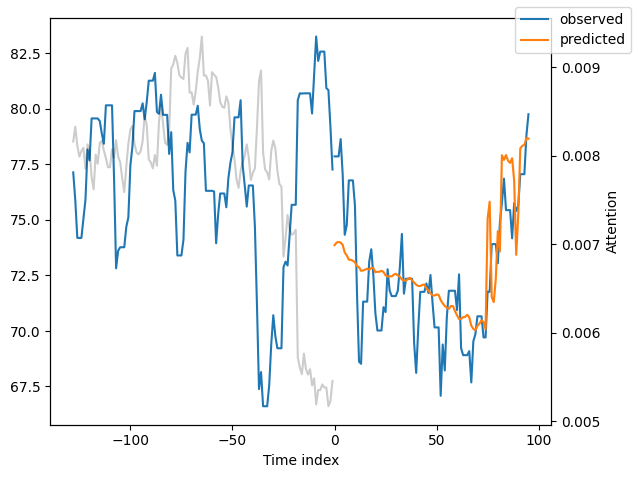

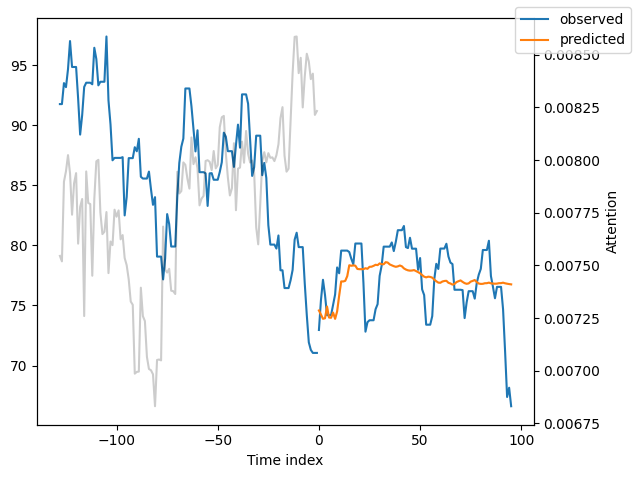

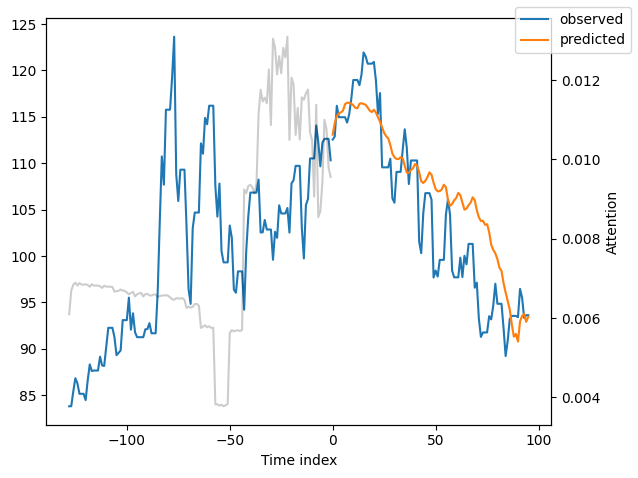

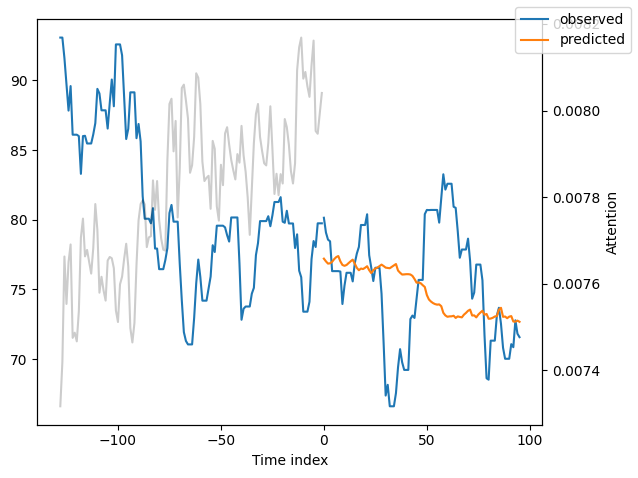

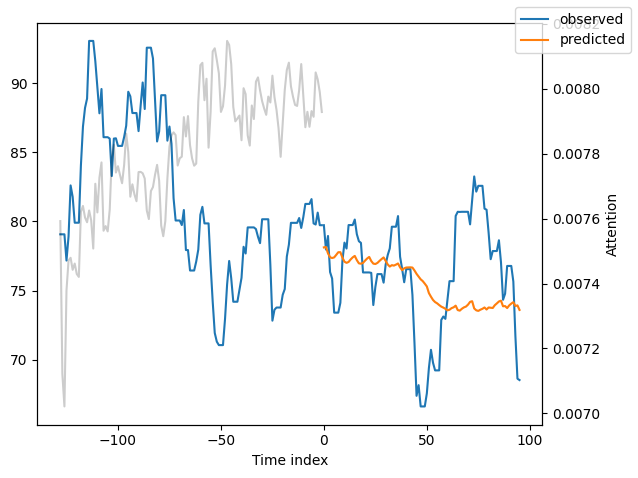

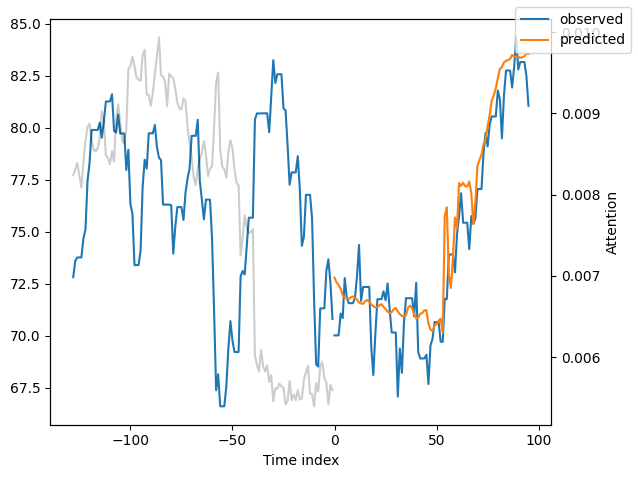

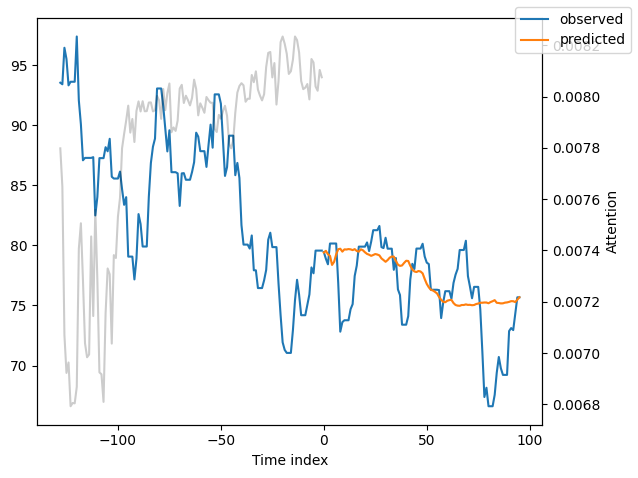

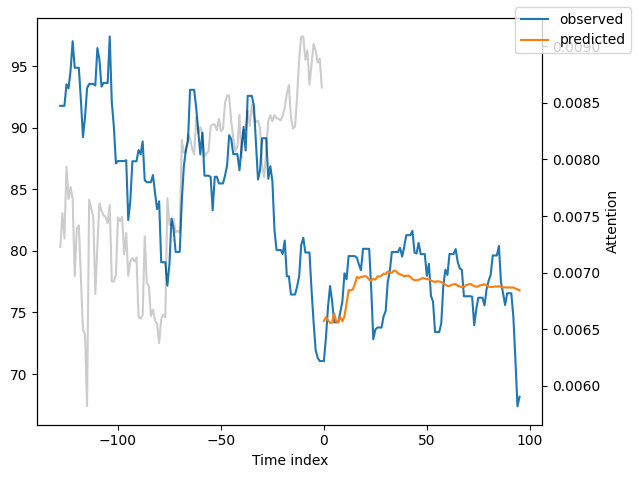

In [62]:
new_raw_predictions = tft.predict(train_dataloader, mode="raw", return_x=True)

for idx in range (0, 400, 50):
    tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=True)

In [63]:
new_raw_predictions.output['decoder_variables'][0][0]

tensor([[0.1382, 0.0946, 0.0798, 0.0167, 0.3563, 0.2159, 0.0984]],
       device='cuda:0')

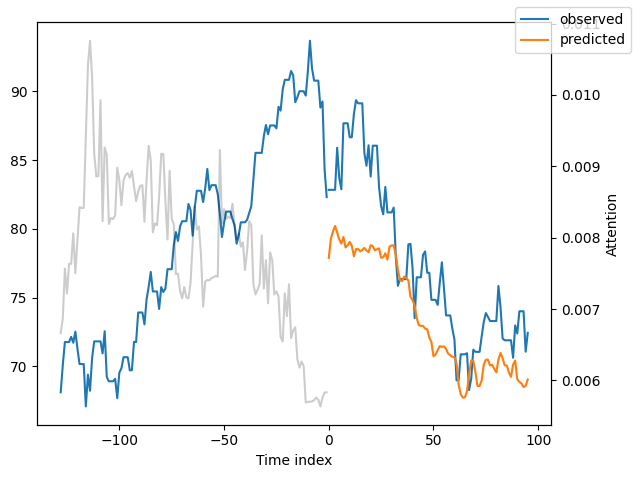

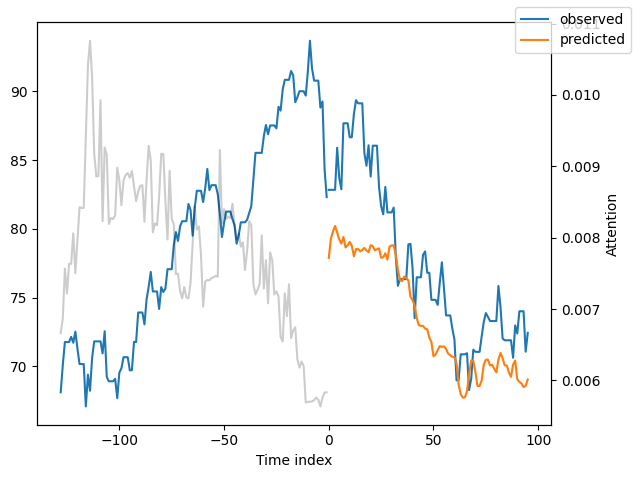

In [64]:
new_raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)


tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

In [79]:
# Create test dataset

con["time_idx"]+=train["time_idx"].max()+1


# Vertically stack the test df at the end of the training df
con= pd.concat([train, con], ignore_index=True).fillna(0.0)
test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        con, 
                                        predict=True, 
                                        stop_randomization=True)

# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

# Get prediction results
test_prediction_results = best_tft.predict(
    test_dataloader,
    mode="raw",
    return_index=True, # return the prediction index in the same order as the output
    return_x=True, # return network inputs in the same order as prediction output
    )

AssertionError: Time difference between steps has been idenfied as larger than 1 - set allow_missing_timesteps=True

In [80]:
con

index  s_p_500  interest_rate    vix    ovx    uso     dxy  crude  \
0         0  3700.65           0.09  26.97  42.12  32.38   89.87  47.47   
1         1  3726.86           0.09  25.34  40.39  33.94   89.44  49.78   
2         2  3748.14           0.09  25.07  39.31  34.11   89.53  50.45   
3         3  3803.79           0.09  22.37  36.06  34.53   89.83  50.63   
4         4  3824.68           0.09  21.56  36.65  35.43   90.10  52.14   
...     ...      ...            ...    ...    ...    ...     ...    ...   
1371   1371  5751.07           5.13  19.21  46.37  76.35  102.52  74.93   
1372   1372  5695.94           5.13  22.64  48.32  79.20  102.54  77.76   
1373   1373  5751.13           5.13  21.42  52.35  75.79  102.55  74.26   
1374   1374  5792.04           5.13  20.86  48.80  75.25  102.93  73.85   
1375   1375  5780.05           5.13  20.93  52.36  77.77  102.99  76.46   

      arabnews_b    cnbc_b  ...    mees_b  oilprice_b  weekday_sin  \
0       0.519839  0.000000  ...  0.000000    0.000000     0.000000   
1       0.519839  0.000000  ...  0.000000   -0.526396     0.781831   
2       0.519839  0.000000  ...  0.000000   -0.526396     0.974928   
3       0.519839  0.848916  ...  0.000000    0.000000     0.433884   
4       0.519839  0.848916  ... -0.626426    0.711697    -0.433884   
...          ...       ...  ...       ...         ...          ...   
1371    0.000000  0.652695  ...  0.000000   -0.788622    -0.781831   
1372    0.000000  0.000000  ...  0.000000    0.000000     0.000000   
1373    0.586104  0.000000  ...  0.000000    0.000000     0.781831   
1374    0.586104  0.000000  ...  0.000000    0.000000     0.974928   
1375    0.586104  0.000000  ...  0.000000    0.000000     0.433884   

      weekday_cos  week_sin  week_cos  month_sin  month_cos  time_idx  \
0        1.000000  0.120537  0.992709   0.500000   0.866025         0   
1        0.623490  0.120537  0.992709   0.500000   0.866025         1   
2       -0.222521  0.120537  0.992709   0.500000   0.866025         2   
3       -0.900969  0.120537  0.992709   0.500000   0.866025         3   
4       -0.900969  0.120537  0.992709   0.500000   0.866025         4   
...           ...       ...       ...        ...        ...       ...   
1371     0.623490 -0.992709  0.120537  -0.866025   0.500000      3435   
1372     1.000000 -0.970942  0.239316  -0.866025   0.500000      3436   
1373     0.623490 -0.970942  0.239316  -0.866025   0.500000      3437   
1374    -0.222521 -0.970942  0.239316  -0.866025   0.500000      3438   
1375    -0.900969 -0.970942  0.239316  -0.866025   0.500000      3439   

      constant  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
1371         1  
1372         1  
1373         1  
1374         1  
1375         1  

[1376 rows x 22 columns]

In [70]:
con.shape

(275, 22)

In [73]:
HPs['max_encoder_length'] +96

224

In [65]:
test_windows = get_test_windows(test, HPs['max_encoder_length'], 96)
len(test_windows)
#a, b, c, d = get_total_loss(tft, test_windows, train, training_dataset, 192+48)

get_all_plots(0, 25, 5, tft, test_windows, train, training_dataset, HPs['max_encoder_length']+48 )

IndexError: list index out of range

In [146]:
val_windows = get_test_windows(val, HPs['max_encoder_length'], 48)
a,b,c,d = get_total_loss(tft, val_windows, train, training_dataset, HPs['max_encoder_length']+48 )

Window: 100%|██████████| 27/27 [00:18<00:00,  1.45it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.0435
  - Mean SMAPE: 0.0436
  - Mean MAE: 3.6292
  - Mean RMSE: 4.2385


In [145]:
a,b,c,d = get_total_loss(tft, test_windows, train, training_dataset, HPs['max_encoder_length']+48 )

Window: 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]

Mean Losses Across Windows:
  - Mean MAPE: 0.1592
  - Mean SMAPE: 0.1443
  - Mean MAE: 11.3646
  - Mean RMSE: 12.8249


In [ ]:
a,b,c,d = get_total_loss(tft, test_windows, train, training_dataset, HPs['max_encoder_length']+48 )

# Optuna Med Model

## Run

In [51]:
def objective(trial):

    HPs = {   'epochs': trial.suggest_int("epochs", 5, 15, step = 5), 
              'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
              'hidden_size': trial.suggest_int("hidden_size", 8, 12, step=2),
              'lstm_layers': trial.suggest_int("lstm_layers", 1, 4, step=1), 
              'attention_head_size': trial.suggest_int("attention_head_size", 1, 4, step=1), 
              'hidden_continous_size': trial.suggest_int("hidden_continous_size", 8, 12, step= 2), 
              'dropout': trial.suggest_float("dropout", 0.1, 0.5, step=0.1), 
              'loss': trial.suggest_categorical("loss", ['SMAPE', 'MAPE', 'MAE', 'RMSE', 'MSE']),
              'gradient_clip_val': trial.suggest_float("gradient_clip_val", 0.1, 1, step=0.1), # using percentages
              'batch_size': trial.suggest_int("batch_size", 32, 128, step= 16), 
              'max_encoder_length': trial.suggest_int('max_encoder_length', 32, 256, step = 32 )
              }

    try: 
        loss = train_model(HPs)
        return loss
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None

In [55]:
def train_model(HPs): 



    max_encoder_length = HPs['max_encoder_length']#history
    max_prediction_length = 48 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
           'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
           'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)


    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )
    

    loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

    # set this between 32 to 128
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=HPs['batch_size'], num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=HPs['batch_size'] * 10, num_workers=8)

    tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate =  HPs['learning_rate'], 
    hidden_size= HPs['hidden_size'],
    lstm_layers= HPs['lstm_layers'],
    attention_head_size=HPs['attention_head_size'],
    dropout= HPs['dropout'],
    hidden_continuous_size=HPs['hidden_continous_size'],
    loss= loss_functions[HPs['loss']],
        
    
    )

    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer = pl.Trainer(
    max_epochs= HPs['epochs'], 
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
    )

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

    predictions = tft.predict(val_dataloader, return_y=True)
    smape = SMAPE()(predictions.output, predictions.y).item()
    mape = MAPE()(predictions.output, predictions.y).item()
    rmse = RMSE()(predictions.output, predictions.y).item()
    mae = MAE()(predictions.output, predictions.y).item()
    mse = MSE()(predictions.output, predictions.y).item()

    print(f"""
    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): {smape*100:.2f}%
    MAPE  (Mean Absolute Percentage Error):          {mape*100:.2f}%
    RMSE  (Root Mean Squared Error):                {rmse:.2f}
    MAE   (Mean Absolute Error):                    {mae:.2f}
    MSE   (Mean Squared Error):                    {mse:.2f}
    """)

    

   
    return mse


    




    

In [61]:
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(),
                            study_name='tft_medium_refined_tuning', 
                            storage='sqlite:///tft_medium_refined_tuning.db', # sql file which has all the 
                                                                   # info; use optuna-dashbord to visualize it 
                            load_if_exists=True) # If True, it loads previous study.db 

# file and continues the hyperparameer tuning
study.optimize(objective, n_trials=20)

    # save the 'study' object into a pickle file for analysis
joblib.dump(study, "tft_medium_refined_tuning.pkl")

[I 2024-12-13 01:53:53,413] Using an existing study with name 'tft_medium_refined_tuning' instead of creating a new one.


Number of parameters in network: 30.7k
Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 11.83it/s, v_num=5.47e+7, train_loss_step=0.106] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:01<00:00,  6.79it/s, v_num=5.47e+7, train_loss_step=0.087, val_loss=0.107, train_loss_epoch=0.111] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  6.58it/s, v_num=5.47e+7, train_loss_step=0.0915, val_loss=0.0925, train_loss_epoch=0.0959]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  6.97it/s, v_num=5.47e+7, train_loss_step=0.0765, val_loss=0.0834, train_loss_epoch=0.0886]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 8/8 [00:01<00:00,  6.51it/s, v_num=5.47e+7, train_loss_step=0.0784, val_loss=0.0825, train_loss_epoch=0.0855]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s, v_num=5.47e+7, train_loss_step=0.0779, v

[I 2024-12-13 01:54:24,490] Trial 81 finished with value: 40.522621154785156 and parameters: {'epochs': 15, 'learning_rate': 0.0007502727690573272, 'hidden_size': 10, 'lstm_layers': 2, 'attention_head_size': 4, 'hidden_continous_size': 10, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 64, 'max_encoder_length': 128}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 8.02%
    MAPE  (Mean Absolute Percentage Error):          8.39%
    RMSE  (Root Mean Squared Error):                6.37
    MAE   (Mean Absolute Error):                    6.07
    MSE   (Mean Squared Error):                    40.52
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  5.77it/s, v_num=5.47e+7, train_loss_step=12.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s, v_num=5.47e+7, train_loss_step=11.50, val_loss=7.610, train_loss_epoch=12.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s, v_num=5.47e+7, train_loss_step=11.70, val_loss=7.160, train_loss_epoch=11.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s, v_num=5.47e+7, train_loss_step=10.70, val_loss=6.730,

[I 2024-12-13 01:54:43,605] Trial 82 finished with value: 21.060380935668945 and parameters: {'epochs': 10, 'learning_rate': 0.0002490085024780764, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 128, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.69%
    MAPE  (Mean Absolute Percentage Error):          5.89%
    RMSE  (Root Mean Squared Error):                4.59
    MAE   (Mean Absolute Error):                    4.23
    MSE   (Mean Squared Error):                    21.06
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s, v_num=5.47e+7, train_loss_step=6.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s, v_num=5.47e+7, train_loss_step=5.980, val_loss=1.570, train_loss_epoch=7.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s, v_num=5.47e+7, train_loss_step=4.800, val_loss=3.220, train_loss_epoch=6.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s, v_num=5.47e+7, train_loss_step=4.650, val_los

[I 2024-12-13 01:54:55,415] Trial 83 finished with value: 9.130316734313965 and parameters: {'epochs': 5, 'learning_rate': 0.0025027780063086175, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.2, 'batch_size': 48, 'max_encoder_length': 160}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.48%
    MAPE  (Mean Absolute Percentage Error):          3.55%
    RMSE  (Root Mean Squared Error):                3.02
    MAE   (Mean Absolute Error):                    2.57
    MSE   (Mean Squared Error):                    9.13
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s, v_num=5.47e+7, train_loss_step=10.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  3.52it/s, v_num=5.47e+7, train_loss_step=9.220, val_loss=4.770, train_loss_epoch=10.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:02<00:00,  3.54it/s, v_num=5.47e+7, train_loss_step=8.840, val_loss=4.250, train_loss_epoch=9.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s, v_num=5.47e+7, train_loss_step=8.730, val_loss=3.790, 

[I 2024-12-13 01:55:12,707] Trial 84 finished with value: 11.8676118850708 and parameters: {'epochs': 5, 'learning_rate': 0.00018770028540472322, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.2, 'loss': 'MAE', 'gradient_clip_val': 0.1, 'batch_size': 48, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.09%
    MAPE  (Mean Absolute Percentage Error):          4.20%
    RMSE  (Root Mean Squared Error):                3.44
    MAE   (Mean Absolute Error):                    3.01
    MSE   (Mean Squared Error):                    11.87
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  9.53it/s, v_num=5.47e+7, train_loss_step=8.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s, v_num=5.47e+7, train_loss_step=7.250, val_loss=5.580, train_loss_epoch=8.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s, v_num=5.47e+7, train_loss_step=7.000, val_loss=4.400, train_loss_epoch=7.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s, v_num=5.47e+7, train_loss_step=7.050, val_loss=3.460,

[I 2024-12-13 01:55:41,573] Trial 85 finished with value: 7.223901271820068 and parameters: {'epochs': 15, 'learning_rate': 0.00034440050500141956, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 80, 'max_encoder_length': 160}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.10%
    MAPE  (Mean Absolute Percentage Error):          3.16%
    RMSE  (Root Mean Squared Error):                2.69
    MAE   (Mean Absolute Error):                    2.27
    MSE   (Mean Squared Error):                    7.22
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s, v_num=5.47e+7, train_loss_step=7.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s, v_num=5.47e+7, train_loss_step=7.320, val_loss=2.370, train_loss_epoch=8.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s, v_num=5.47e+7, train_loss_step=7.540, val_loss=2.030, train_loss_epoch=7.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s, v_num=5.47e+7, train_loss_step=6.930, val_loss=1.810, 

[I 2024-12-13 01:56:11,897] Trial 86 finished with value: 4.737497806549072 and parameters: {'epochs': 10, 'learning_rate': 0.0004394601982706644, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.28%
    MAPE  (Mean Absolute Percentage Error):          2.25%
    RMSE  (Root Mean Squared Error):                2.18
    MAE   (Mean Absolute Error):                    1.66
    MSE   (Mean Squared Error):                    4.74
    
Number of parameters in network: 31.7k
Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s, v_num=5.47e+7, train_loss_step=9.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  3.63it/s, v_num=5.47e+7, train_loss_step=6.350, val_loss=7.610, train_loss_epoch=9.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:02<00:00,  3.76it/s, v_num=5.47e+7, train_loss_step=5.210, val_loss=3.460, train_loss_epoch=7.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  3.71it/s, v_num=5.47e+7, train_loss_step=4.540, val_loss=3.890, 

[I 2024-12-13 01:56:28,340] Trial 87 finished with value: 18.224946975708008 and parameters: {'epochs': 5, 'learning_rate': 0.01235689201106243, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'RMSE', 'gradient_clip_val': 0.5, 'batch_size': 64, 'max_encoder_length': 128}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 5.20%
    MAPE  (Mean Absolute Percentage Error):          5.38%
    RMSE  (Root Mean Squared Error):                4.27
    MAE   (Mean Absolute Error):                    3.86
    MSE   (Mean Squared Error):                    18.22
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  9.78it/s, v_num=5.47e+7, train_loss_step=12.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s, v_num=5.47e+7, train_loss_step=11.30, val_loss=8.240, train_loss_epoch=13.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  5.63it/s, v_num=5.47e+7, train_loss_step=8.920, val_loss=5.840, train_loss_epoch=11.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s, v_num=5.47e+7, train_loss_step=8.130, val_loss=3.820,

[I 2024-12-13 01:56:49,068] Trial 88 finished with value: 29.79345703125 and parameters: {'epochs': 10, 'learning_rate': 0.0009209403353805805, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 64, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.10%
    MAPE  (Mean Absolute Percentage Error):          6.36%
    RMSE  (Root Mean Squared Error):                5.46
    MAE   (Mean Absolute Error):                    4.62
    MSE   (Mean Squared Error):                    29.79
    
Number of parameters in network: 40.4k
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s, v_num=5.47e+7, train_loss_step=0.098] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s, v_num=5.47e+7, train_loss_step=0.0881, val_loss=0.089, train_loss_epoch=0.103]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s, v_num=5.47e+7, train_loss_step=0.0797, val_loss=0.0545, train_loss_epoch=0.0881]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s, v_num=5.47e+7, train_loss_step=0.0742, val_loss=

[I 2024-12-13 01:57:08,623] Trial 89 finished with value: 9.930793762207031 and parameters: {'epochs': 10, 'learning_rate': 0.0005414296528916709, 'hidden_size': 12, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 160}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 3.59%
    MAPE  (Mean Absolute Percentage Error):          3.68%
    RMSE  (Root Mean Squared Error):                3.15
    MAE   (Mean Absolute Error):                    2.65
    MSE   (Mean Squared Error):                    9.93
    
Number of parameters in network: 33.5k
Epoch 0: 100%|██████████| 14/14 [00:02<00:00,  6.25it/s, v_num=5.47e+7, train_loss_step=160.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 14/14 [00:02<00:00,  5.03it/s, v_num=5.47e+7, train_loss_step=63.10, val_loss=51.30, train_loss_epoch=241.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 14/14 [00:02<00:00,  5.08it/s, v_num=5.47e+7, train_loss_step=60.20, val_loss=5.410, train_loss_epoch=92.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 14/14 [00:02<00:00,  5.22it/s, v_num=5.47e+7, train_loss_step=34.40, val_loss

[I 2024-12-13 01:57:27,741] Trial 90 finished with value: 59.09428024291992 and parameters: {'epochs': 5, 'learning_rate': 0.001177824871506111, 'hidden_size': 10, 'lstm_layers': 2, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MSE', 'gradient_clip_val': 0.9, 'batch_size': 32, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.78%
    MAPE  (Mean Absolute Percentage Error):          8.27%
    RMSE  (Root Mean Squared Error):                7.69
    MAE   (Mean Absolute Error):                    6.04
    MSE   (Mean Squared Error):                    59.09
    
Number of parameters in network: 25.4k
Epoch 0: 100%|██████████| 12/12 [00:01<00:00,  9.47it/s, v_num=5.47e+7, train_loss_step=6.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:01<00:00,  6.81it/s, v_num=5.47e+7, train_loss_step=5.280, val_loss=4.250, train_loss_epoch=8.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:01<00:00,  6.99it/s, v_num=5.47e+7, train_loss_step=4.660, val_loss=8.510, train_loss_epoch=5.810]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:01<00:00,  7.03it/s, v_num=5.47e+7, train_loss_step=4.700, val_los

[I 2024-12-13 01:57:55,212] Trial 91 finished with value: 79.8178482055664 and parameters: {'epochs': 10, 'learning_rate': 0.022787643020819044, 'hidden_size': 8, 'lstm_layers': 3, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'RMSE', 'gradient_clip_val': 0.2, 'batch_size': 48, 'max_encoder_length': 64}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 11.28%
    MAPE  (Mean Absolute Percentage Error):          12.00%
    RMSE  (Root Mean Squared Error):                8.93
    MAE   (Mean Absolute Error):                    8.70
    MSE   (Mean Squared Error):                    79.82
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s, v_num=5.47e+7, train_loss_step=8.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s, v_num=5.47e+7, train_loss_step=8.160, val_loss=1.900, train_loss_epoch=9.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s, v_num=5.47e+7, train_loss_step=7.880, val_loss=1.730, train_loss_epoch=8.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s, v_num=5.47e+7, train_loss_step=7.720, val_loss=1.68

[I 2024-12-13 01:58:25,382] Trial 92 finished with value: 4.876248836517334 and parameters: {'epochs': 10, 'learning_rate': 0.00041621053712623187, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.46%
    MAPE  (Mean Absolute Percentage Error):          2.43%
    RMSE  (Root Mean Squared Error):                2.21
    MAE   (Mean Absolute Error):                    1.79
    MSE   (Mean Squared Error):                    4.88
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s, v_num=5.47e+7, train_loss_step=8.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s, v_num=5.47e+7, train_loss_step=7.500, val_loss=2.230, train_loss_epoch=8.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s, v_num=5.47e+7, train_loss_step=7.650, val_loss=1.800, train_loss_epoch=7.840]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s, v_num=5.47e+7, train_loss_step=7.210, val_loss=1.640, 

[I 2024-12-13 01:58:56,250] Trial 93 finished with value: 11.731013298034668 and parameters: {'epochs': 10, 'learning_rate': 0.00028901259256965204, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.6, 'batch_size': 80, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 4.08%
    MAPE  (Mean Absolute Percentage Error):          3.97%
    RMSE  (Root Mean Squared Error):                3.43
    MAE   (Mean Absolute Error):                    2.93
    MSE   (Mean Squared Error):                    11.73
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  4.75it/s, v_num=5.47e+7, train_loss_step=6.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s, v_num=5.47e+7, train_loss_step=8.430, val_loss=2.300, train_loss_epoch=8.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s, v_num=5.47e+7, train_loss_step=7.770, val_loss=1.740, train_loss_epoch=7.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s, v_num=5.47e+7, train_loss_step=6.280, val_loss=1.940,

[I 2024-12-13 01:59:45,626] Trial 94 finished with value: 35.321533203125 and parameters: {'epochs': 15, 'learning_rate': 0.0007163085141029715, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.7000000000000001, 'batch_size': 48, 'max_encoder_length': 192}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 7.39%
    MAPE  (Mean Absolute Percentage Error):          7.72%
    RMSE  (Root Mean Squared Error):                5.94
    MAE   (Mean Absolute Error):                    5.55
    MSE   (Mean Squared Error):                    35.32
    
Number of parameters in network: 23.1k
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, v_num=5.47e+7, train_loss_step=8.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=5.47e+7, train_loss_step=6.940, val_loss=1.780, train_loss_epoch=10.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=5.47e+7, train_loss_step=5.710, val_loss=3.060, train_loss_epoch=7.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, v_num=5.47e+7, train_loss_step=6.360, val_loss=3.300,

[I 2024-12-13 02:00:02,127] Trial 95 finished with value: 4.043964862823486 and parameters: {'epochs': 5, 'learning_rate': 0.0036481658879659743, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 0.8, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.19%
    MAPE  (Mean Absolute Percentage Error):          2.17%
    RMSE  (Root Mean Squared Error):                2.01
    MAE   (Mean Absolute Error):                    1.59
    MSE   (Mean Squared Error):                    4.04
    
Number of parameters in network: 31.8k
Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s, v_num=5.47e+7, train_loss_step=10.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s, v_num=5.47e+7, train_loss_step=7.470, val_loss=2.300, train_loss_epoch=11.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s, v_num=5.47e+7, train_loss_step=6.680, val_loss=1.570, train_loss_epoch=8.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s, v_num=5.47e+7, train_loss_step=5.990, val_loss=1.910, 

[I 2024-12-13 02:00:18,132] Trial 96 finished with value: 6.314725399017334 and parameters: {'epochs': 5, 'learning_rate': 0.003828754838880079, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'MAE', 'gradient_clip_val': 1.0, 'batch_size': 112, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.50%
    MAPE  (Mean Absolute Percentage Error):          2.54%
    RMSE  (Root Mean Squared Error):                2.51
    MAE   (Mean Absolute Error):                    1.83
    MSE   (Mean Squared Error):                    6.31
    
Number of parameters in network: 31.7k
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=5.47e+7, train_loss_step=0.0729]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=5.47e+7, train_loss_step=0.0718, val_loss=0.0537, train_loss_epoch=0.0929]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=5.47e+7, train_loss_step=0.0594, val_loss=0.125, train_loss_epoch=0.0694] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=5.47e+7, train_loss_step=0.0528, val_loss

[I 2024-12-13 02:00:35,740] Trial 97 finished with value: 417.4295654296875 and parameters: {'epochs': 5, 'learning_rate': 0.006196482791859688, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.5, 'loss': 'SMAPE', 'gradient_clip_val': 0.30000000000000004, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 24.56%
    MAPE  (Mean Absolute Percentage Error):          28.05%
    RMSE  (Root Mean Squared Error):                20.43
    MAE   (Mean Absolute Error):                    20.33
    MSE   (Mean Squared Error):                    417.43
    
Number of parameters in network: 31.7k
Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s, v_num=5.47e+7, train_loss_step=8.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s, v_num=5.47e+7, train_loss_step=7.370, val_loss=2.340, train_loss_epoch=10.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s, v_num=5.47e+7, train_loss_step=5.840, val_loss=4.720, train_loss_epoch=7.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s, v_num=5.47e+7, train_loss_step=4.860, val_loss=7

[I 2024-12-13 02:00:52,890] Trial 98 finished with value: 41.00082015991211 and parameters: {'epochs': 5, 'learning_rate': 0.007401652929273947, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.30000000000000004, 'loss': 'RMSE', 'gradient_clip_val': 0.4, 'batch_size': 112, 'max_encoder_length': 256}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 6.38%
    MAPE  (Mean Absolute Percentage Error):          6.72%
    RMSE  (Root Mean Squared Error):                6.40
    MAE   (Mean Absolute Error):                    4.92
    MSE   (Mean Squared Error):                    41.00
    
Number of parameters in network: 29.1k
Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, v_num=5.47e+7, train_loss_step=0.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=5.47e+7, train_loss_step=0.0818, val_loss=0.0236, train_loss_epoch=0.113]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=5.47e+7, train_loss_step=0.0719, val_loss=0.0309, train_loss_epoch=0.087]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=5.47e+7, train_loss_step=0.0766, val_loss=0

[I 2024-12-13 02:01:03,770] Trial 99 finished with value: 3.526397705078125 and parameters: {'epochs': 5, 'learning_rate': 0.002526626130695399, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 2, 'hidden_continous_size': 10, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.08%
    MAPE  (Mean Absolute Percentage Error):          2.08%
    RMSE  (Root Mean Squared Error):                1.88
    MAE   (Mean Absolute Error):                    1.51
    MSE   (Mean Squared Error):                    3.53
    
Number of parameters in network: 21.8k
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=5.47e+7, train_loss_step=0.0752]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, v_num=5.47e+7, train_loss_step=0.0645, val_loss=0.0353, train_loss_epoch=0.0848]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, v_num=5.47e+7, train_loss_step=0.0649, val_loss=0.0498, train_loss_epoch=0.067] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, v_num=5.47e+7, train_loss_step=0.0586, val_loss

[I 2024-12-13 02:01:21,129] Trial 100 finished with value: 5.688180923461914 and parameters: {'epochs': 5, 'learning_rate': 0.0018681301802036029, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 10, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.8, 'batch_size': 96, 'max_encoder_length': 224}. Best is trial 28 with value: 2.955333948135376.



    Model Evaluation Metrics:
    -------------------------
    SMAPE (Symmetric Mean Absolute Percentage Error): 2.84%
    MAPE  (Mean Absolute Percentage Error):          2.83%
    RMSE  (Root Mean Squared Error):                2.38
    MAE   (Mean Absolute Error):                    2.06
    MSE   (Mean Squared Error):                    5.69
    


['tft_medium_refined_tuning.pkl']

In [81]:
# joblib.dump(study, "tft_medium_tuning.pkl")

['tft_medium_tuning.pkl']

In [63]:
study.best_trials

[FrozenTrial(number=28, state=1, values=[2.955333948135376], datetime_start=datetime.datetime(2024, 12, 13, 1, 24, 18, 108478), datetime_complete=datetime.datetime(2024, 12, 13, 1, 24, 34, 325066), params={'epochs': 5, 'learning_rate': 0.00588052466230126, 'hidden_size': 8, 'lstm_layers': 1, 'attention_head_size': 3, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'RMSE', 'gradient_clip_val': 0.2, 'batch_size': 112, 'max_encoder_length': 256}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'epochs': IntDistribution(high=15, log=False, low=5, step=5), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'hidden_size': IntDistribution(high=12, log=False, low=8, step=2), 'lstm_layers': IntDistribution(high=4, log=False, low=1, step=1), 'attention_head_size': IntDistribution(high=4, log=False, low=1, step=1), 'hidden_continous_size': IntDistribution(high=12, log=False, low=8, step=2), 'dropout': FloatDistribution(high=0.5, log=False, l

In [143]:
sorted_trials = sorted(study.trials, key=lambda trial: trial.values[0] if trial.values else float('inf'))

sorted_trials[2]

FrozenTrial(number=73, state=1, values=[3.4772346019744873], datetime_start=datetime.datetime(2024, 12, 13, 1, 49, 7, 527351), datetime_complete=datetime.datetime(2024, 12, 13, 1, 49, 38, 993142), params={'epochs': 10, 'learning_rate': 0.0004044500344979071, 'hidden_size': 10, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continous_size': 12, 'dropout': 0.4, 'loss': 'MAPE', 'gradient_clip_val': 0.1, 'batch_size': 80, 'max_encoder_length': 160}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'epochs': IntDistribution(high=15, log=False, low=5, step=5), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'hidden_size': IntDistribution(high=12, log=False, low=8, step=2), 'lstm_layers': IntDistribution(high=4, log=False, low=1, step=1), 'attention_head_size': IntDistribution(high=4, log=False, low=1, step=1), 'hidden_continous_size': IntDistribution(high=12, log=False, low=8, step=2), 'dropout': FloatDistribution(high=0.5, log=False,

In [286]:
HPs = sorted_trials[2].params
HPs
sorted_trials[2].value

3.4772346019744873

## Best Medium Model

In [127]:
# study = joblib.load("tft_medium_tuning.pkl")

# HPs = study.best_params
# HPs

{'epochs': 15,
 'learning_rate': 0.00367249822320984,
 'hidden_size': 16,
 'lstm_layers': 2,
 'attention_head_size': 3,
 'hidden_continous_size': 16,
 'dropout': 0.2,
 'loss': 'RMSE',
 'gradient_clip_val': 0.8,
 'batch_size': 128,
 'max_encoder_length': 160}

In [301]:
loss_functions = {
    'SMAPE': SMAPE(),
    'MAPE': MAPE(),
    'MAE': MAE(),
    'RMSE': RMSE(), 
    'MSE': MSE()
    }

In [302]:
    max_encoder_length = HPs['max_encoder_length']
    max_prediction_length = 48 #forecast
    training_cutoff = train["time_idx"].max() - max_prediction_length #validation on 2020


    training_dataset = TimeSeriesDataSet(
        train[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="crude", # target variable
        max_encoder_length=max_encoder_length, # maximum size of lookup window
        max_prediction_length=max_prediction_length, # maximum size of horizon window
        group_ids = ['constant'], 
        time_varying_known_reals=[
            "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
           'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
           'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
           'oilprice_b'], 
        target_normalizer=EncoderNormalizer(),
        lags={'crude': [7,30, 365]}, # add lagged values of target variable
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
)




    validation_dataset = TimeSeriesDataSet.from_dataset(
      training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
      train, # data from which new dataset will be generated
      predict=True, # predict the decoder length on the last entries in the time index
      stop_randomization=True,
    )


    # con[["time_idx"]]+=train[["time_idx"]].max()+1
    # con = pd.concat([train, con], ignore_index=True).fillna(0.0)

    # validation_dataset = TimeSeriesDataSet.from_dataset(
    # training_dataset, 
    # con, 
    # predict= False,
    # stop_randomization=True,
    # min_prediction_idx=training_cutoff + 1)
    
    tests = get_test_windows(test, max_encoder_length, max_prediction_length)
    val_windows = get_test_windows(val, max_encoder_length, max_prediction_length)


In [311]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    lstm_layers = HPs['lstm_layers'], 
    learning_rate = HPs['learning_rate'], 
    hidden_size=HPs['hidden_size'],
    attention_head_size=HPs['attention_head_size'],
    #dropout=HPs['dropout'],
    hidden_continuous_size=HPs['hidden_continous_size'], 
    loss=loss_functions[HPs['loss']],


)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Number of parameters in network: 31.7k


In [290]:
trainer = pl.Trainer(
    accelerator="gpu"
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Finding best initial lr:  20%|██        | 20/100 [00:13<00:47,  1.67it/s]

NameError: name 'exit' is not defined

In [304]:

batch_size = HPs['batch_size']  # set this between 32 to 12
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [312]:
trainer = pl.Trainer(
    max_epochs=HPs['epochs'],
    accelerator="gpu", #if torch.cuda.is_available() else "cpu",
    devices = 1,
    #num_nodes=1,
    #strategy='ddp_notebook',
    gradient_clip_val= HPs['gradient_clip_val'],
    
)


In [313]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s, v_num=5.47e+7, train_loss_step=0.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s, v_num=5.47e+7, train_loss_step=0.101, val_loss=0.101, train_loss_epoch=0.120] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s, v_num=5.47e+7, train_loss_step=0.0887, val_loss=0.0812, train_loss_epoch=0.107]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s, v_num=5.47e+7, train_loss_step=0.0892, val_loss=0.0637, train_loss_epoch=0.096]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s, v_num=5.47e+7, train_loss_step=0.0807, val_loss=0.0484, train_loss_epoch=0.0868]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s, v_num=5.47e+7, train_loss_step=0.0818, val_loss=0.0376, train_loss_epoch=0.0788]
V

In [315]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape

0.023683853447437286

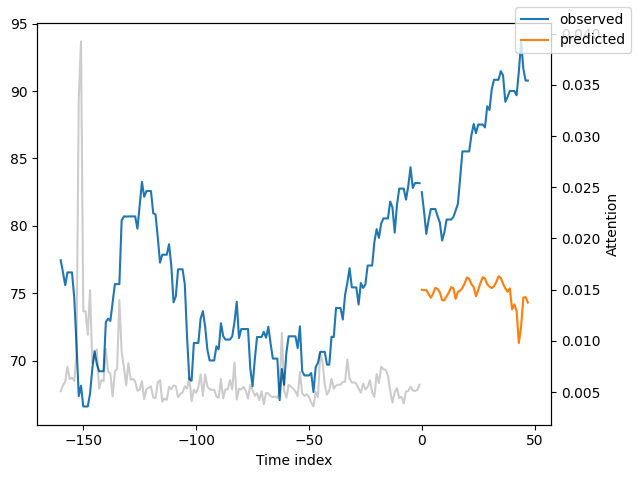

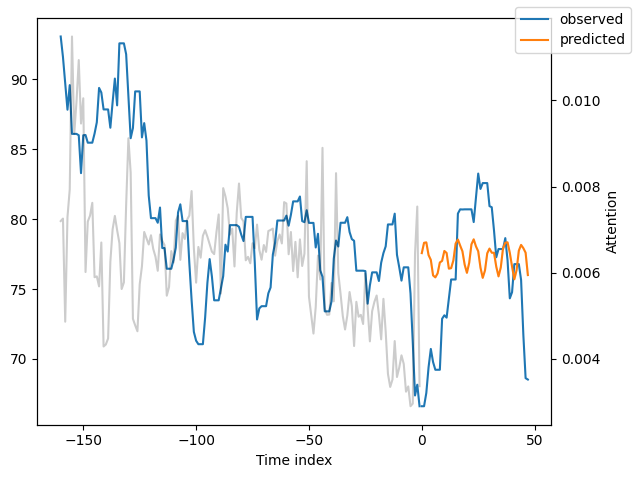

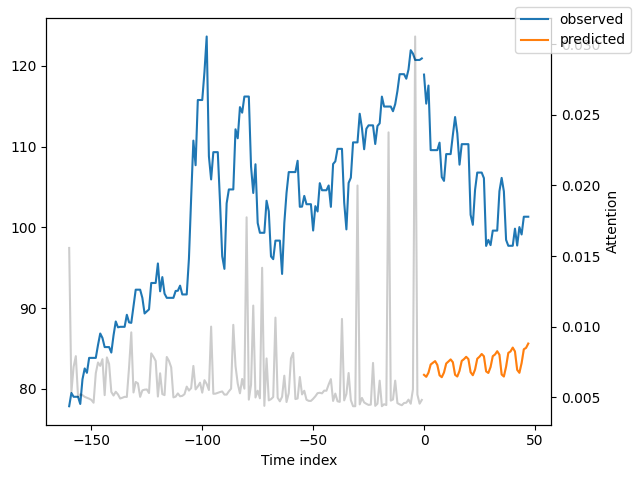

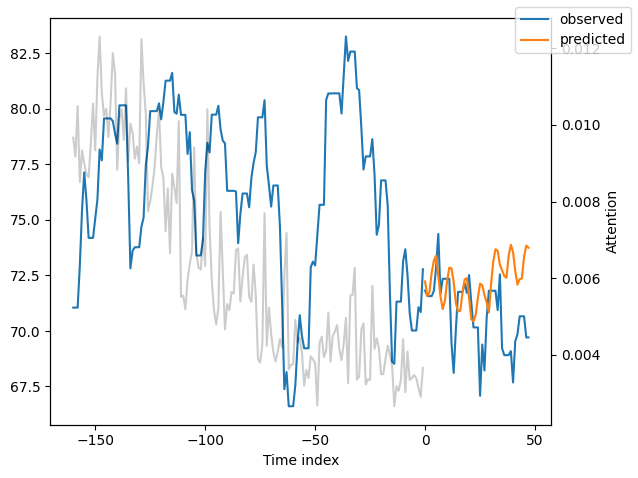

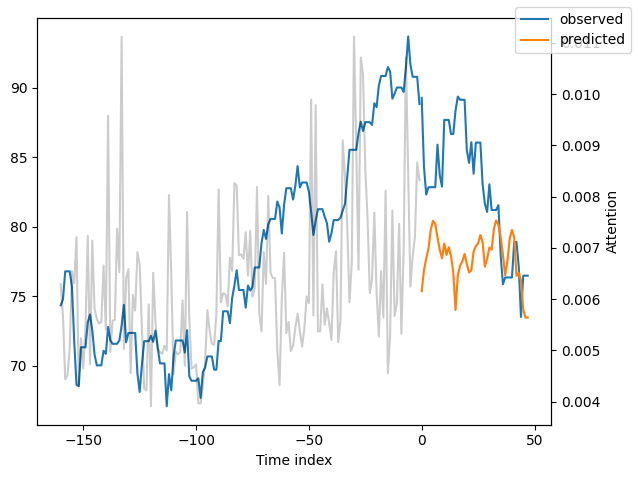

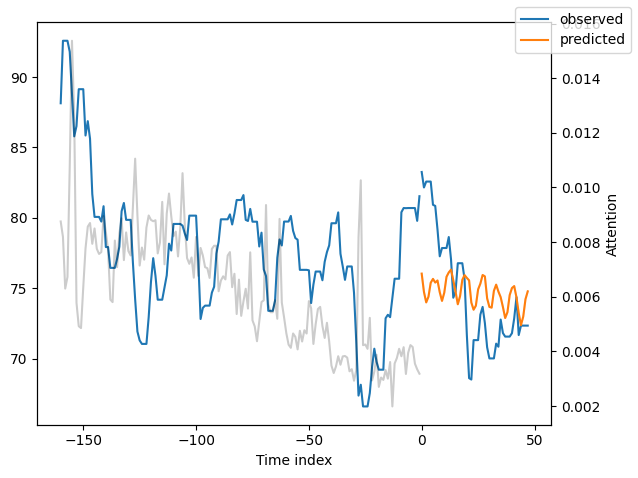

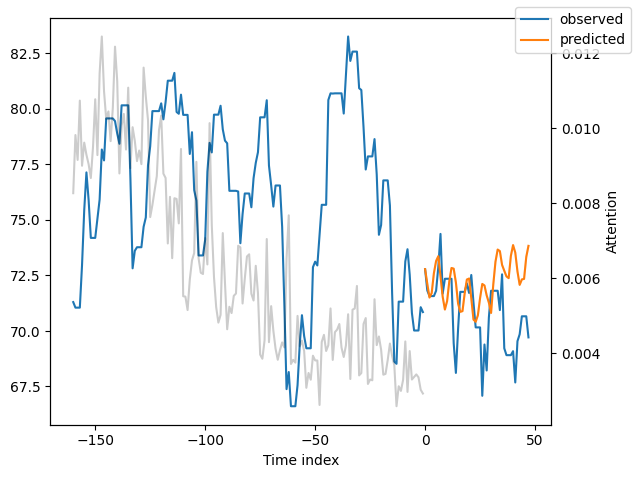

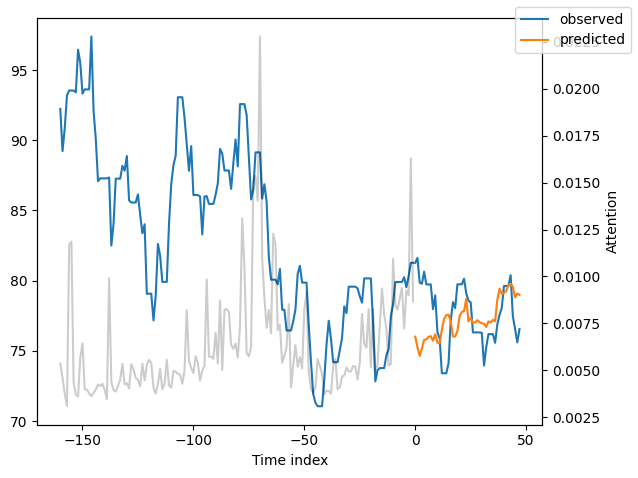

In [316]:
predictions = tft.predict(val_dataloader, return_y=True)
smape = SMAPE()(predictions.output, predictions.y).item()
smape

new_raw_predictions = tft.predict(train_dataloader, mode="raw", return_x=True)

for idx in range (0, 400, 50):
    tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=True)

In [317]:
test_windows = get_test_windows(con, HPs['max_encoder_length'], 48)
len(test_windows)
#a, b, c, d = get_total_loss(tft, test_windows, train, training_dataset, 192+48)

68

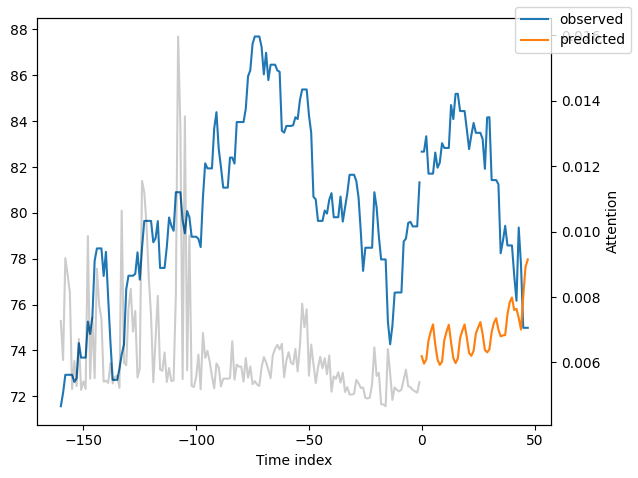

Plot for Window 0


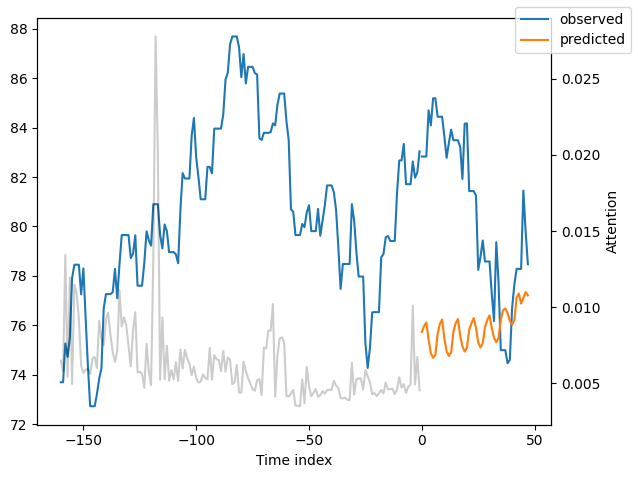

Plot for Window 10


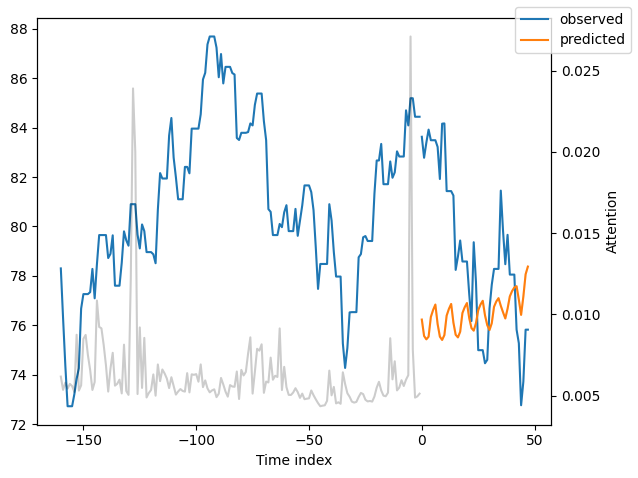

Plot for Window 20


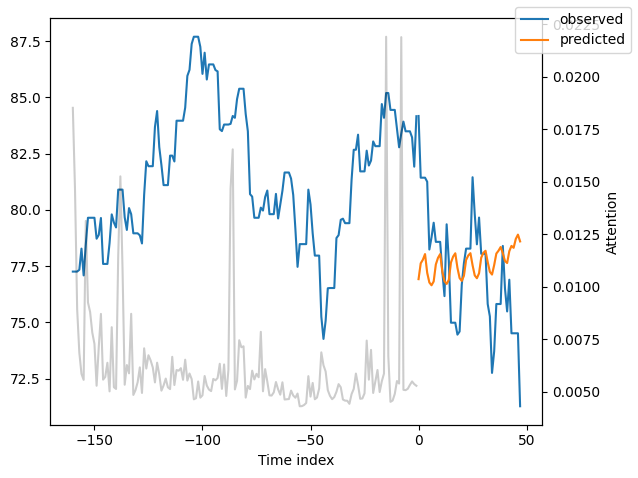

Plot for Window 30


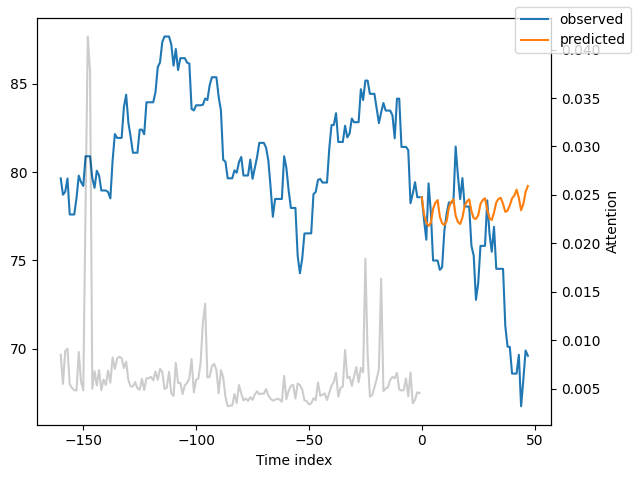

Plot for Window 40


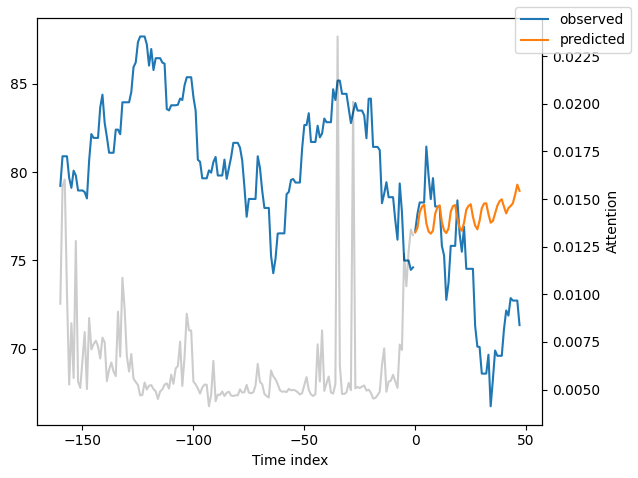

Plot for Window 50


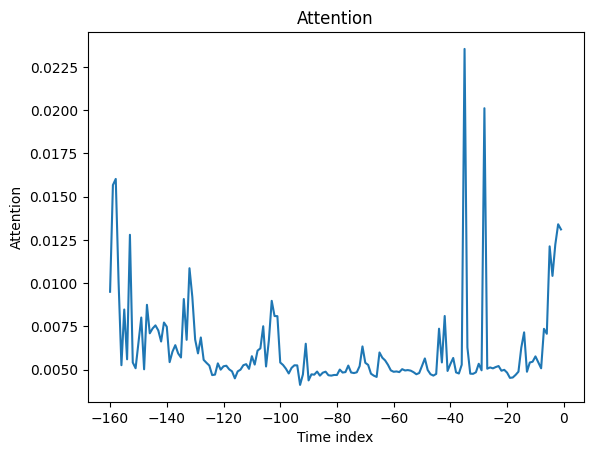

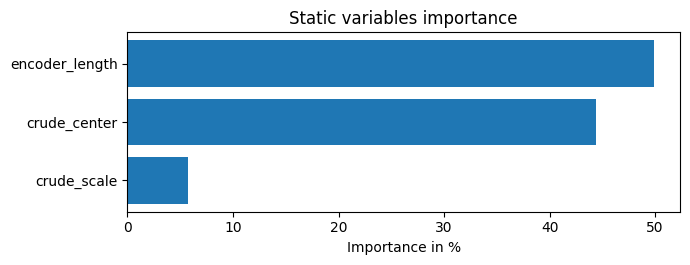

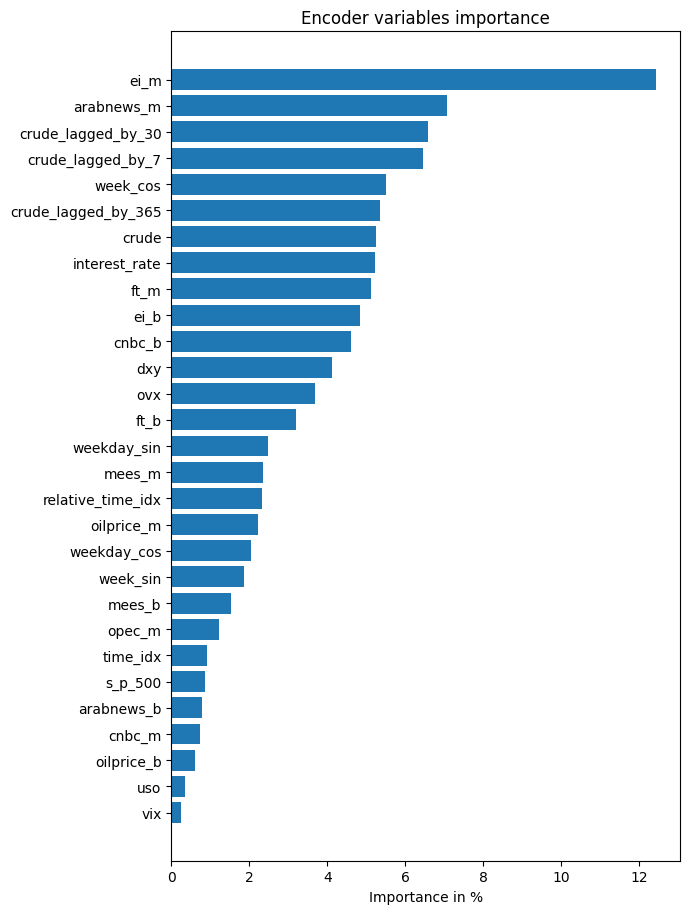

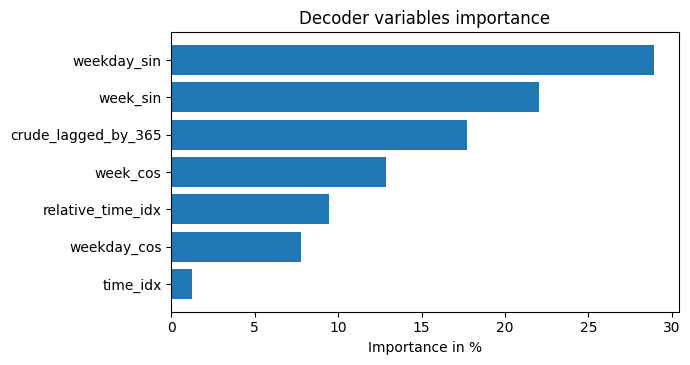

In [318]:
get_all_plots(0, 60, 10, tft, test_windows, train, training_dataset, HPs['max_encoder_length']+48 )

83

In [44]:
test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        con, 
                                        predict=True, 
                                        stop_randomization=True)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

AssertionError: data index has to be unique

In [ ]:
mape, smape, mae, rmse = get_total_loss(tft, val_windows, train, training_dataset, 112)



In [ ]:

mape, smape, mae, rmse = get_total_loss(tft, tests, train, training_dataset, 112)


In [ ]:
get_all_plots(0, 26, 5, tft, val_windows, train, training_dataset, 112)

# MISC

In [154]:
predictions = tft.predict(test_dataloader, return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(6.9737, device='cuda:0')

In [156]:
predictions = tft.predict(test_dataloader, return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(6.9737, device='cuda:0')

In [130]:
one.time_idx

0          0
1          1
2          2
3          3
4          4
        ... 
1160    1160
1161    1161
1162    1162
1163    1163
1164    1164
Name: time_idx, Length: 1165, dtype: int64

In [132]:
one.time_idx

0          0
1          1
2          2
3          3
4          4
        ... 
1160    1160
1161    1161
1162    1162
1163    1163
1164    1164
Name: time_idx, Length: 1165, dtype: int64

In [137]:
predictions = tft.predict(test_dataloader, return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(4.7324, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


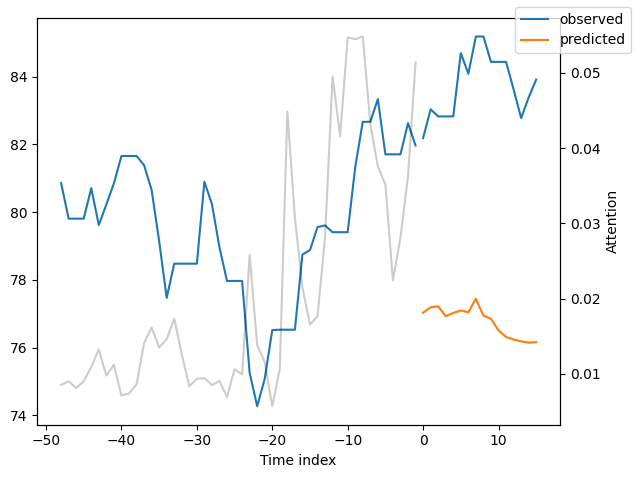

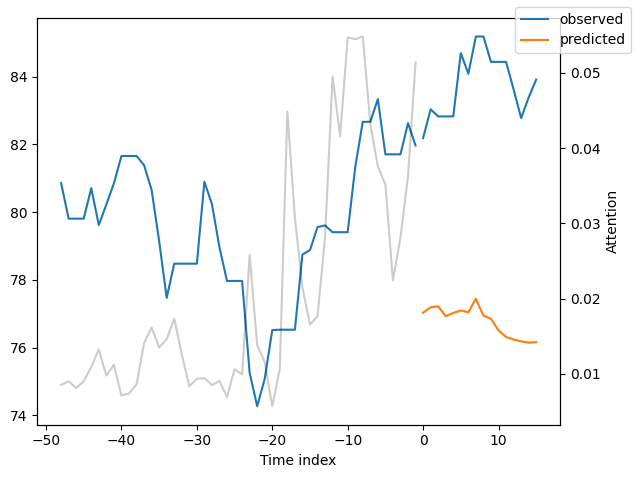

In [157]:
new_raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True)

  # plot 10 examples
tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x925 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

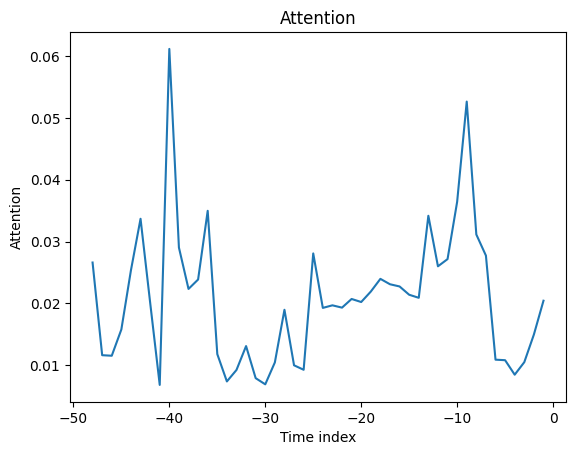

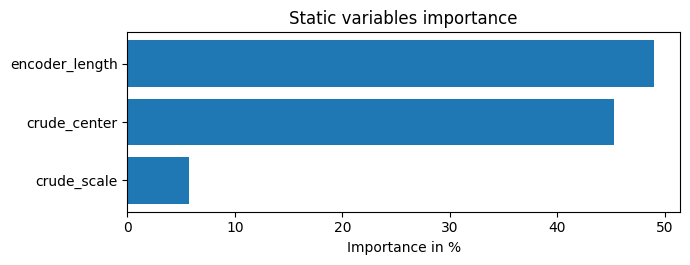

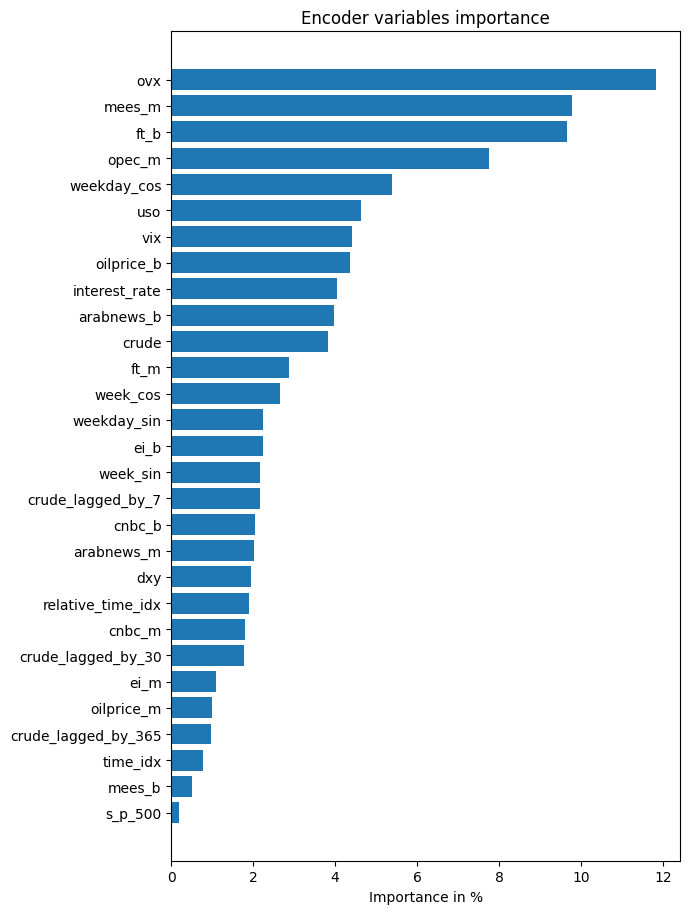

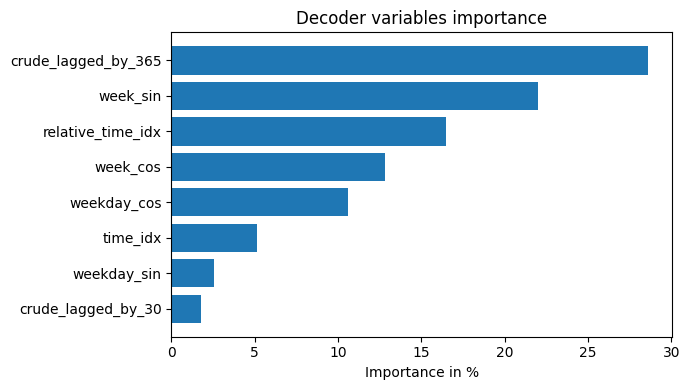

In [158]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [119]:
new_raw_predictions.x['encoder_target']

tensor([[81.9400, 81.9400, 81.9400, 83.6800, 84.3900, 82.7900, 81.9900, 81.1000,
         81.1000, 81.1000, 82.4100, 82.4100, 82.1500, 83.9600, 83.9600, 83.9600,
         83.9600, 84.5400, 85.9500, 86.2200, 87.3700, 87.6900, 87.6900, 87.6900,
         87.2400, 86.0400, 86.9800, 85.7900, 86.4600, 86.4600, 86.4600, 86.2100,
         86.1500, 83.5800, 83.5000, 83.7900, 83.7900, 83.7900, 83.8200, 84.1700,
         84.0900, 84.9200, 85.3800, 85.3800, 85.3800, 84.2600, 83.4900, 80.7000]],
       device='cuda:0')

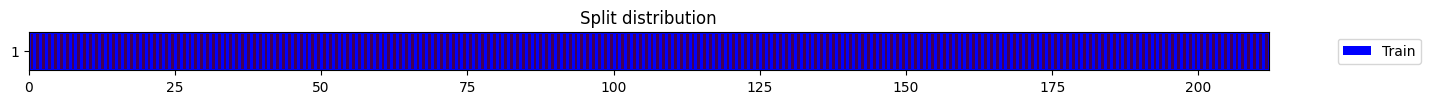

((#212) [0,1,2,3,4,5,6,7,8,9...],)

In [181]:
datetime_col = 'index'
fcst_history = 48 # # steps in the past
fcst_horizon = 16  # # steps in the future
test_size = 0
splits = get_forecasting_splits(test, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                 test_size=test_size)
splits


In [178]:
test

index  s_p_500  interest_rate    vix    ovx    uso     dxy  crude  \
0     1101  4783.45           5.33  12.69  36.35  66.56  102.36  71.57   
1     1102  4780.24           5.33  12.44  36.78  67.65  102.29  72.15   
2     1103  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
3     1104  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
4     1105  4783.83           5.33  12.70  40.64  68.02  102.40  72.94   
..     ...      ...            ...    ...    ...    ...     ...    ...   
270   1371  5751.07           5.13  19.21  46.37  76.35  102.52  74.93   
271   1372  5695.94           5.13  22.64  48.32  79.20  102.54  77.76   
272   1373  5751.13           5.13  21.42  52.35  75.79  102.55  74.26   
273   1374  5792.04           5.13  20.86  48.80  75.25  102.93  73.85   
274   1375  5780.05           5.13  20.93  52.36  77.77  102.99  76.46   

     arabnews_m  cnbc_m  ...    mees_b  oilprice_b  weekday_sin  weekday_cos  \
0           0.5     0.5  ...  0.507777    0.000000     0.974928    -0.222521   
1           0.5     0.5  ...  0.507777    0.000000     0.433884    -0.900969   
2           0.5    -0.3  ... -0.635409    0.000000    -0.433884    -0.900969   
3           0.5    -0.3  ... -0.635409    0.000000    -0.974928    -0.222521   
4           0.5    -0.3  ... -0.635409    0.000000    -0.781831     0.623490   
..          ...     ...  ...       ...         ...          ...          ...   
270         0.0     0.0  ...  0.000000   -0.788622    -0.781831     0.623490   
271         0.0     0.5  ...  0.000000    0.000000     0.000000     1.000000   
272         0.0    -0.3  ...  0.000000    0.000000     0.781831     0.623490   
273         0.0     0.3  ...  0.000000    0.000000     0.974928    -0.222521   
274         0.0    -0.3  ...  0.000000    0.000000     0.433884    -0.900969   

     week_sin  week_cos  month_sin  month_cos  time_idx  constant  
0    0.239316  0.970942   0.500000   0.866025         0         1  
1    0.239316  0.970942   0.500000   0.866025         1         1  
2    0.239316  0.970942   0.500000   0.866025         2         1  
3    0.239316  0.970942   0.500000   0.866025         3         1  
4    0.239316  0.970942   0.500000   0.866025         4         1  
..        ...       ...        ...        ...       ...       ...  
270 -0.992709  0.120537  -0.866025   0.500000       270         1  
271 -0.970942  0.239316  -0.866025   0.500000       271         1  
272 -0.970942  0.239316  -0.866025   0.500000       272         1  
273 -0.970942  0.239316  -0.866025   0.500000       273         1  
274 -0.970942  0.239316  -0.866025   0.500000       274         1  

[275 rows x 29 columns]

In [245]:
test_dataloader

In [655]:
test_preds = tft.predict(test_dataloader, return_x=True)
test_preds.x['encoder_cont'].shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


torch.Size([1, 48, 32])

In [439]:
test_preds.y

(tensor([[79.8000, 79.4400, 79.2200, 80.9000, 80.9000, 80.9000, 79.6700, 79.1100,
          80.0800, 79.8100, 78.9600, 78.9600, 78.9600, 78.8700, 78.5100, 80.6700]],
        device='cuda:0'),
 None)

In [440]:
test[['crude']].iloc[-1]

crude    80.85
Name: 1164, dtype: float64

In [169]:
test_preds.output

Output(prediction=tensor([[[73.3783],
         [74.1104],
         [74.6518],
         [74.3036],
         [74.9997],
         [74.9527],
         [74.9613],
         [74.9330],
         [74.8693],
         [74.8555],
         [74.9176],
         [74.9193],
         [74.8611],
         [74.8594],
         [74.8491],
         [74.8025]]], device='cuda:0'), encoder_attention=tensor([[[[2.1063e-02, 1.9097e-02, 1.8591e-02,  ..., 1.9546e-02,
           1.9840e-02, 1.8457e-02],
          [2.0236e-02, 2.3074e-02, 2.1707e-02,  ..., 2.1185e-02,
           1.9858e-02, 2.1430e-02],
          [2.1603e-02, 2.2817e-02, 2.4871e-02,  ..., 2.2304e-02,
           2.0575e-02, 2.1753e-02],
          [1.3108e-02, 9.2318e-03, 8.9675e-03,  ..., 1.3883e-02,
           2.0501e-02, 1.3632e-02]],

         [[2.0523e-02, 1.9039e-02, 1.8788e-02,  ..., 1.9991e-02,
           2.0455e-02, 1.9434e-02],
          [2.0632e-02, 2.4168e-02, 2.2784e-02,  ..., 2.0751e-02,
           1.8937e-02, 2.1082e-02],
          [2.157

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


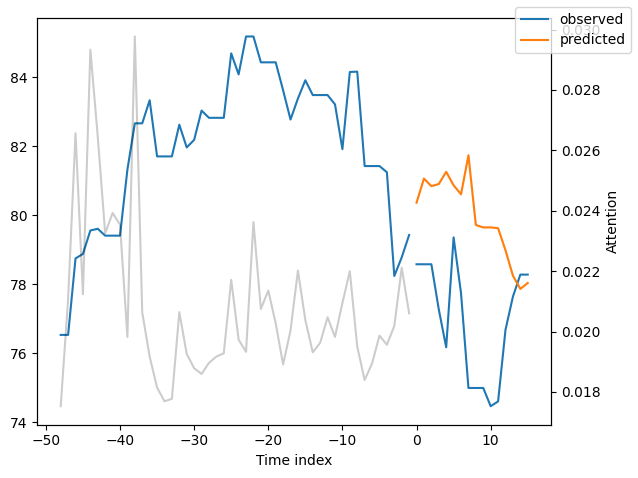

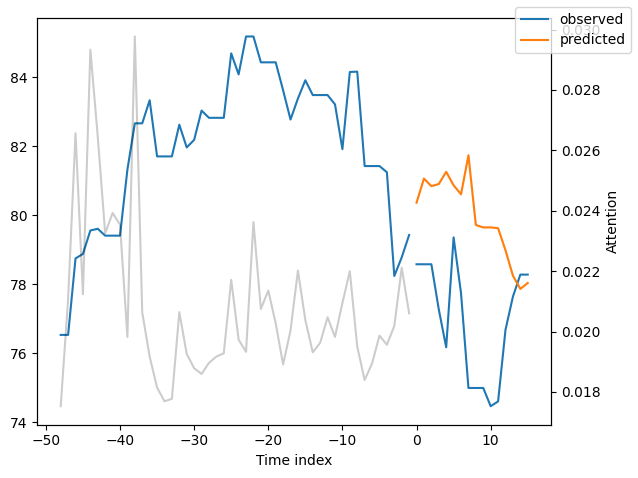

In [677]:
new_raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True)

  # plot 10 examples
tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

In [37]:
test_dataset

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='crude',
	group_ids=['constant'],
	weight=None,
	max_encoder_length=48,
	min_encoder_length=48,
	min_prediction_idx=0,
	min_prediction_length=16,
	max_prediction_length=16,
	static_categoricals=None,
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['time_idx', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m', 'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b', 'oilprice_b'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags={'crude': [7, 30, 365]},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	meth

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x925 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

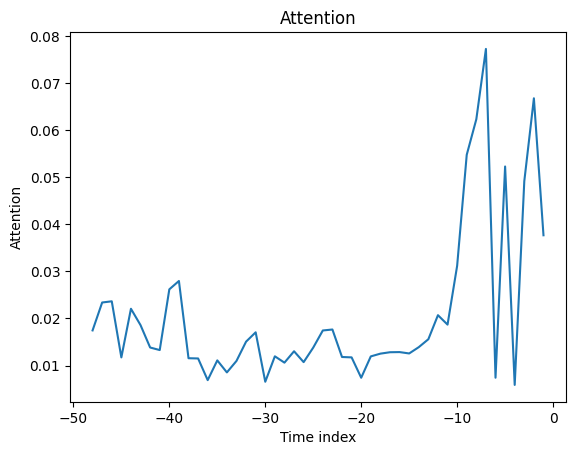

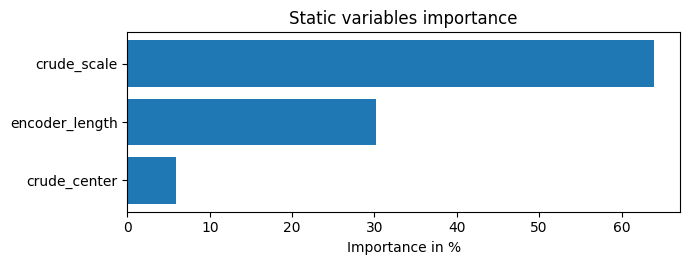

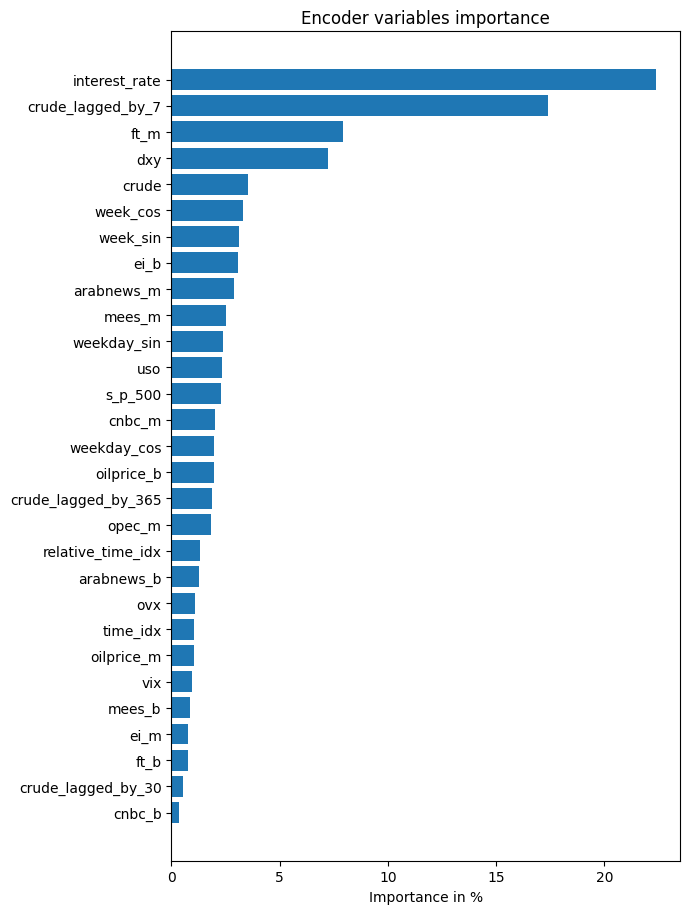

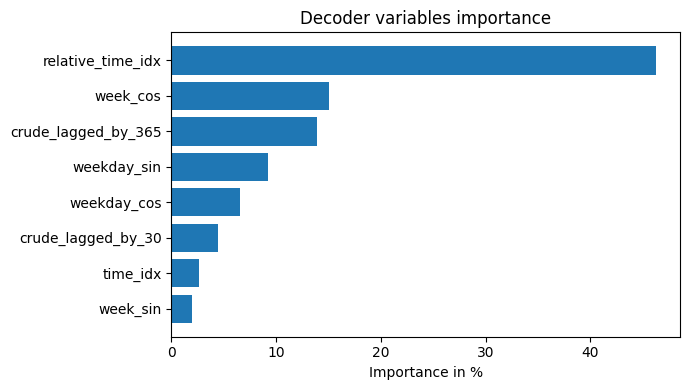

In [678]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [151]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=4,
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder = False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)


[I 2024-11-25 00:43:56,867] A new study created in memory with name: no-name-3b9a2ce5-de8f-45b4-bdf5-35a958500fc6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=4` reached.
[I 2024-11-25 00:44:02,571] Trial 0 finished with value: 0.09407633543014526 and parameters: {'gradient_clip_val': 0.26018679204303763, 'hidden_size': 43, 'dropout': 0.16092719697370744, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.026488058745987336}. Best is trial 0 with value: 0.09407633543014526.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=4` reached.
[I 2024-11-25 00:44:08,328] Tria

{'gradient_clip_val': 0.5265323531175049, 'hidden_size': 25, 'dropout': 0.25271711318725854, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.002743886795577542}


In [152]:
print(study.best_trial.params)

{'gradient_clip_val': 0.5265323531175049, 'hidden_size': 25, 'dropout': 0.25271711318725854, 'hidden_continuous_size': 22, 'attention_head_size': 1, 'learning_rate': 0.002743886795577542}


In [28]:
os.getcwd()

'/scratch/us2055/Oil_Price/Notebooks'

In [156]:
best_tft = TemporalFusionTransformer.load_from_checkpoint("optuna_test/trial_65/epoch=3.ckpt")


In [157]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(0.1025)

In [158]:
predictions = best_tft.predict(test_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(0.2218)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


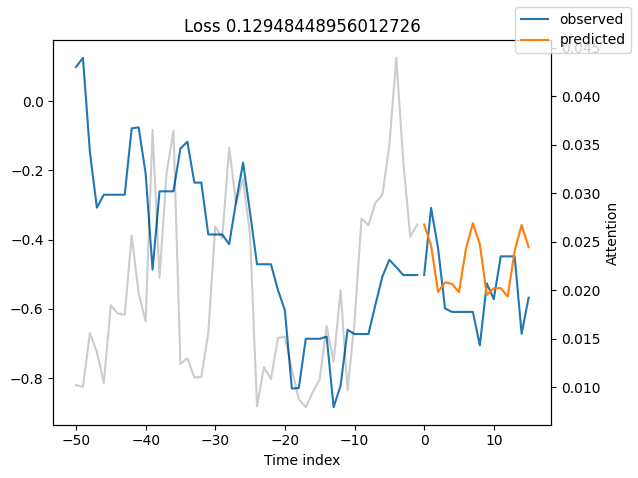

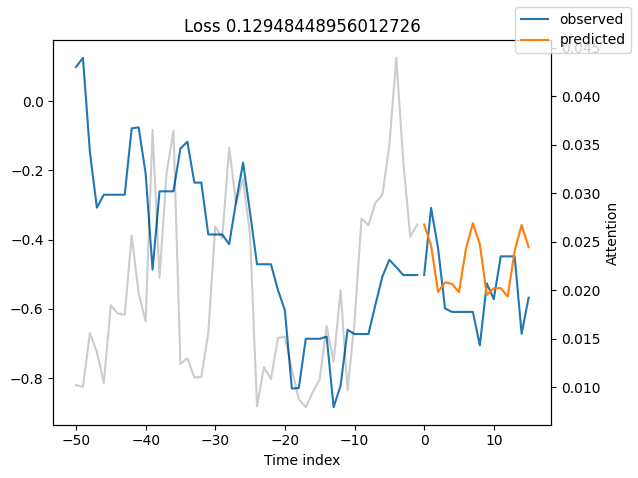

In [159]:
  # plot 10 examples
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


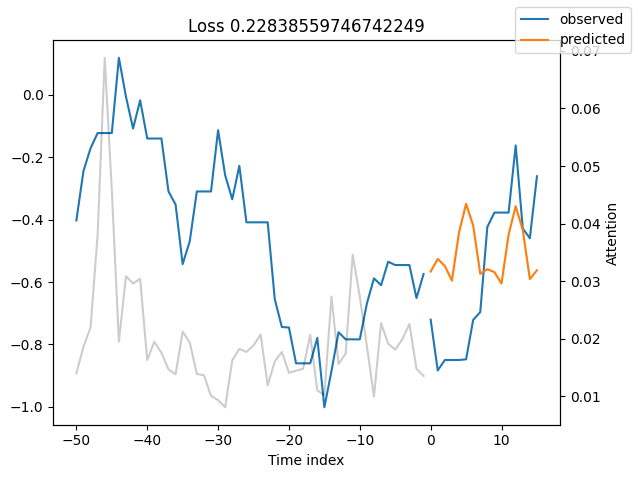

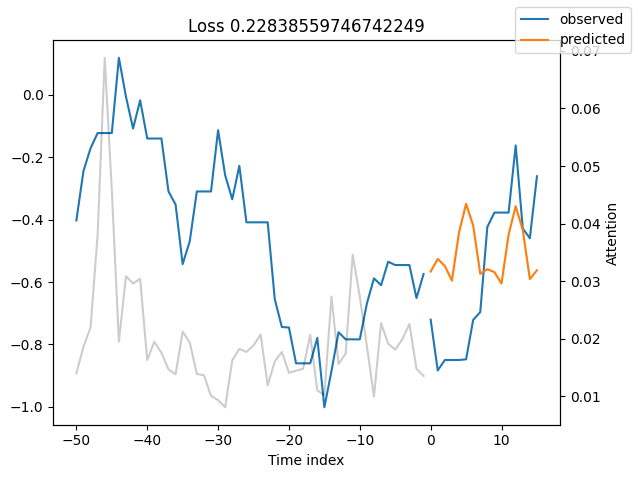

In [161]:
  # plot 10 examples
raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True)
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (324938846.py, line 1)